# 資料準備

In [ ]:
# @title
df = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/train_data_v1.1.csv', encoding='utf-8', index_col=False)
df = df.dropna()
df_test = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/test_data_v1.1.csv', encoding='utf-8', index_col=False)
df_test = df_test.dropna()

In [ ]:
# @title
df.columns

Index(['id', '公司名稱', '縣市', '行政區', '里別', '行政區平日夜間停留人數', '行政區平日日間活動人數',
       '行政區假日夜間停留人數', '行政區假日日間活動人數', '里人均收入中位數', '里人口數', '發票張數指標', '發票銷售額指標',
       '500公尺內的熱鬧據點數', '最近的熱鬧據點類型', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
       '500公尺外部競爭(不同公司店數)', '租金', '競爭壓力指標', '生存難度', '競爭優勢', '是否便利商店',
       'people_per_store', 'day_night_flow', '登記現況'],
      dtype='object')

# 基礎設定

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
! pip install xgboost

In [ ]:
# 1. 下載中文字體 (Noto Sans TC)
!wget -O font.ttf https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf

# 2. 引入字體庫
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 3. 設定字體屬性
custom_font = fm.FontProperties(fname='font.ttf')

# 測試：如果這行沒出現方框，代表成功
# plt.text(0.5, 0.5, '測試中文字體：成功', fontproperties=custom_font)
# plt.show()

--2026-02-24 02:32:34--  https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/notofonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf [following]
--2026-02-24 02:32:34--  https://github.com/notofonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/notofonts/noto-cjk/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf [following]
--2026-02-24 02:32:35--  https://raw.githubusercontent.com/notofonts/noto-cjk/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.19

In [ ]:
# --- 讀取原始資料並過濾有效樣本 ---
# 僅保留「營運中」與「廢止」的資料列
df_ml = df[df['登記現況'].isin(['營運中', '廢止'])].copy()


In [ ]:
name_map = {
    '里人均收入中位數': '人均收入',
    '里人口數': '基礎客源',
    '發票銷售額指標': '銷售指標',
    '發票張數指標': '交易頻次',
    '租金': '平均租金',
    '競爭優勢比': '區域市占率',
    '500公尺外部競爭(不同公司店數)': '跨品牌飽和度',
    '500公尺內部競爭(同公司店數)': '同體系聚集度',
    '最近的熱鬧據點距離': '最近導流節點距離',
    'people_per_store': '店均服務人數',
    '是否便利商店': '業態標籤'
}

In [ ]:
# ==========================================
# 2. 相關前處理 (依照 XGBoost 邏輯)
# ==========================================
# A. 目標變數轉換
df_ml['target'] = df_ml['登記現況'].map({'營運中': 1, '廢止': 0})

# B. 【關鍵修正】直接對 df_ml 進行類型轉換，確保全域生效
# 針對特定報錯欄位強制轉型
df_ml['最近的熱鬧據點類型'] = df_ml['最近的熱鬧據點類型'].astype('category')
# 使用 log1p (log(1+x)) 確保即便有 0 也不會報錯
df_ml['租金_log'] = np.log1p(df_ml['租金'])
cluster_cols_log = ['行政區平日日間活動人數', '行政區平日夜間停留人數', '里人口數', '租金_log']

In [ ]:
def evaluate_v4_master(model, X_val_df, y_val_true):
    """
    針對 13 特徵戰略版設計的自動對齊評估函數
    """
    # 1. 自動從模型中提取特徵清單，確保 100% 匹配
    model_features = model.feature_names

    # 2. 準備 DMatrix
    dval = xgb.DMatrix(X_val_df[model_features], enable_categorical=True)
    y_prob = model.predict(dval)

    # 3. 執行雙軌動態門檻邏輯 (CVS=0.5 / 一般=0.7)
    y_pred = []
    is_cvs_array = X_val_df['是否便利商店'].values
    for i in range(len(y_prob)):
        threshold = 0.5 if is_cvs_array[i] == 1 else 0.7
        y_pred.append(1 if y_prob[i] >= threshold else 0)

    y_pred = np.array(y_pred)

    # 4. 輸出診斷報告
    print("\n" + "█"*65)
    print("🏆 13 特徵戰略版：日夜雙信令模型 評估報告")
    print("█"*65)

    for g_val, g_name in [(0, "連鎖超市藥妝組"), (1, "便利商店組 (CVS)")]:
        mask = (X_val_df['是否便利商店'] == g_val)
        t_val = 0.5 if g_val == 1 else 0.7

        if mask.any():
            y_t = y_val_true[mask]
            y_p = y_pred[mask]

            print(f"\n【{g_name}】判定門檻: {t_val}")
            print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_t, y_p):.2%}")
            print(f"  ● Recall 0 (風險捕捉率)  : {recall_score(y_t, y_p, pos_label=0):.2%}")
            print(f"  ● Precision 1 (推薦信心度) : {precision_score(y_t, y_p, pos_label=1):.2%}")

    print("\n" + "█"*65)
    return y_pred, y_prob

# 商圈標籤分析

In [ ]:
# @title
# 我們先拿原始資料 X_raw，群聚後再過濾 input_features
y = df_ml['target']
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    df_ml, y, test_size=0.1, random_state=42, stratify=y
)

In [ ]:
# @title

# ==========================================
# 3. KMeans 商圈標籤重構 (關鍵邏輯)
# ==========================================
print("🚀 啟動商圈標籤群聚計算...")

scaler = StandardScaler()
# 訓練集
train_cluster_log = X_train_raw[cluster_cols_log].fillna(0)
train_scaled = scaler.fit_transform(train_cluster_log)

# 驗證集
val_cluster_log = X_val_raw[cluster_cols_log].fillna(0)
val_scaled = scaler.transform(val_cluster_log) # 這裡要對應 log 版

# 重新訓練 KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
X_train_raw['商圈標籤'] = kmeans.fit_predict(train_scaled)
X_val_raw['商圈標籤'] = kmeans.predict(val_scaled)

# ==========================================
# 3. 再次解碼 (這次我們看中位數 Median，更能抗極端值)
# ==========================================
# 分析時，我們看原始租金的「中位數」
analysis_cols = ['行政區平日日間活動人數', '行政區平日夜間停留人數', '里人口數', '租金', 'target']
cluster_median = X_train_raw.groupby('商圈標籤')[analysis_cols].median()

print("🏆 修正後商圈標籤分佈 (中位數指標)：")
print(cluster_median)

# D. 強制轉換標籤為 Category
X_train_raw['商圈標籤'] = X_train_raw['商圈標籤'].astype('category')
X_val_raw['商圈標籤'] = X_val_raw['商圈標籤'].astype('category')

🚀 啟動商圈標籤群聚計算...
🏆 修正後商圈標籤分佈 (中位數指標)：
      行政區平日日間活動人數  行政區平日夜間停留人數     里人口數       租金  target
商圈標籤                                                    
0        176578.0     222097.0   5276.0  22713.0     1.0
1        397325.0     438175.0   4556.0  22775.0     1.0
2        131771.0     141826.0  33686.0  36155.0     1.0
3        309701.0     268313.0   5415.0  64102.0     1.0


In [ ]:
# @title
input_features = [
                '行政區平日夜間停留人數', '行政區平日日間活動人數',
                '行政區假日夜間停留人數', '行政區假日日間活動人數',
                '里人均收入中位數', '里人口數',
                '發票張數指標', '發票銷售額指標',
                '500公尺內的熱鬧據點數',
                '最近的熱鬧據點類型',
                '最近的熱鬧據點距離',
                # '500公尺內部競爭(同公司店數)', '500公尺外部競爭(不同公司店數)',
                # 'peer_comp_500m_history', 'cross_comp_500m_history',
                '租金_log',
                '競爭壓力指標',
                # '生存難度',
                '競爭優勢',
                '是否便利商店',
                'people_per_store',
                # 'day_night_flow',
                '商圈標籤']

golden_features = [
    '是否便利商店', '里人均收入中位數', '里人口數', '發票張數指標',
    '發票銷售額指標', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
    '500公尺外部競爭(不同公司店數)', '租金', 'people_per_store', '競爭優勢',
    '商圈標籤'
]


In [ ]:
# @title
# ==========================================
# 4. 準備最終 XGBoost 特徵矩陣
# ==========================================
# 確保所有 object 欄位轉為 category (在 input_features 內的)
for col in input_features:
    if X_train_raw[col].dtype == 'object':
        X_train_raw[col] = X_train_raw[col].astype('category')
        X_val_raw[col] = X_val_raw[col].astype('category')

X_train = X_train_raw[input_features].copy()
X_val = X_val_raw[input_features].copy()

print("--- 檢查最終 X_train 類型 ---")
print(X_train.dtypes[X_train.dtypes == 'object'])
print(f"商圈標籤分佈:\n{X_train['商圈標籤'].value_counts()}")

--- 檢查最終 X_train 類型 ---
Series([], dtype: object)
商圈標籤分佈:
商圈標籤
0    2155
1    1992
3    1577
2      60
Name: count, dtype: int64


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5784 entries, 1902 to 3151
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   行政區平日夜間停留人數       5784 non-null   int64   
 1   行政區平日日間活動人數       5784 non-null   int64   
 2   行政區假日夜間停留人數       5784 non-null   int64   
 3   行政區假日日間活動人數       5784 non-null   int64   
 4   里人均收入中位數          5784 non-null   int64   
 5   里人口數              5784 non-null   int64   
 6   發票張數指標            5784 non-null   float64 
 7   發票銷售額指標           5784 non-null   float64 
 8   500公尺內的熱鬧據點數      5784 non-null   float64 
 9   最近的熱鬧據點類型         5784 non-null   category
 10  最近的熱鬧據點距離         5784 non-null   float64 
 11  租金_log            5784 non-null   float64 
 12  競爭壓力指標            5784 non-null   float64 
 13  競爭優勢              5784 non-null   float64 
 14  是否便利商店            5784 non-null   int64   
 15  people_per_store  5784 non-null   float64 
 16  商圈標籤              5784 non

In [ ]:
# @title
# 1. 計算各標籤的樣本數
cluster_counts = X_train_raw['商圈標籤'].value_counts().sort_index()

# 2. 重新計算分析資料 (延用先前的邏輯)
analysis_cols = ['行政區平日日間活動人數', '行政區平日夜間停留人數', '里人口數', '租金', 'target', '發票銷售額指標']
cluster_profile = X_train_raw.groupby('商圈標籤')[analysis_cols].mean()
global_mean = X_train_raw[analysis_cols].mean()
cluster_relative = cluster_profile / global_mean

# ==========================================
# 3. 自動化解碼報告 (增加樣本數顯示)
# ==========================================
print("\n" + "█"*65)
print("📊 專題最終版：商圈地理意義與樣本分佈報告")
print("█"*65)

for i in cluster_profile.index:
    row = cluster_profile.loc[i]
    rel = cluster_relative.loc[i]
    count = cluster_counts[i]
    percentage = (count / len(X_train_raw)) * 100

    # 自動命名邏輯 (延用)
    def get_cluster_name(rel):
        if rel['里人口數'] > 2.0: return "高密度超級住宅區"
        if rel['租金'] > 1.5 and rel['行政區平日日間活動人數'] > 1.2: return "頂級精華商辦區"
        if rel['行政區平日日間活動人數'] > 1.2 and rel['行政區平日夜間停留人數'] > 1.2: return "核心交通樞紐區"
        if rel['租金'] < 0.9: return "低門檻基礎生活圈"
        return "指標均衡型商圈"

    cluster_name = get_cluster_name(rel)

    print(f"\n📍 【商圈標籤 {i}】：{cluster_name}")
    print(f"  ● 樣本規模：{count} 筆店鋪 (約佔總體 {percentage:.1f}%)") # <-- 新增這行

    # 描述性格
    desc = []
    if rel['行政區平日日間活動人數'] > 1.1: desc.append("區級日間動能強")
    if rel['行政區平日夜間停留人數'] > 1.1: desc.append("區域居住人口多")
    if rel['租金'] > 1.1: desc.append("地租門檻較高")
    if rel['里人口數'] > 1.5: desc.append("微觀里別人口極密")

    print(f"  ● 地理性格：{', '.join(desc) if desc else '環境指標穩定'}")
    print(f"  ● 營運成功率：{row['target']:.1%} (全域平均：{global_mean['target']:.1%})")
    print(f"  ● 平均租金：${row['租金']:,.0f} 元")
    print(f"  ● 經濟產值 (發票)：{row['發票銷售額指標']:.2f} 分")
    print("-" * 30)


█████████████████████████████████████████████████████████████████
📊 專題最終版：商圈地理意義與樣本分佈報告
█████████████████████████████████████████████████████████████████

📍 【商圈標籤 0】：低門檻基礎生活圈
  ● 樣本規模：2155 筆店鋪 (約佔總體 37.3%)
  ● 地理性格：環境指標穩定
  ● 營運成功率：73.1% (全域平均：71.0%)
  ● 平均租金：$24,417 元
  ● 經濟產值 (發票)：68.74 分
------------------------------

📍 【商圈標籤 1】：核心交通樞紐區
  ● 樣本規模：1992 筆店鋪 (約佔總體 34.4%)
  ● 地理性格：區級日間動能強, 區域居住人口多
  ● 營運成功率：70.7% (全域平均：71.0%)
  ● 平均租金：$24,992 元
  ● 經濟產值 (發票)：69.88 分
------------------------------

📍 【商圈標籤 2】：高密度超級住宅區
  ● 樣本規模：60 筆店鋪 (約佔總體 1.0%)
  ● 地理性格：微觀里別人口極密
  ● 營運成功率：96.7% (全域平均：71.0%)
  ● 平均租金：$30,704 元
  ● 經濟產值 (發票)：84.70 分
------------------------------

📍 【商圈標籤 3】：指標均衡型商圈
  ● 樣本規模：1577 筆店鋪 (約佔總體 27.3%)
  ● 地理性格：區級日間動能強, 地租門檻較高
  ● 營運成功率：67.7% (全域平均：71.0%)
  ● 平均租金：$84,031 元
  ● 經濟產值 (發票)：86.41 分
------------------------------


/tmp/ipython-input-3295347844.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_profile = X_train_raw.groupby('商圈標籤')[analysis_cols].mean()


/tmp/ipython-input-2426546806.py:15: UserWarning: Glyph 127750 (\N{CITYSCAPE AT DUSK}) missing from font(s) Noto Sans CJK TC.
  plt.tight_layout()
/tmp/ipython-input-2426546806.py:15: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2426546806.py:15: UserWarning: Glyph 22280 (\N{CJK UNIFIED IDEOGRAPH-5708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2426546806.py:15: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2426546806.py:15: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127750 (\N{CITYSCAPE AT DUSK}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22280 (\N{CJK UNIFIED IDEOGRAPH-5708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

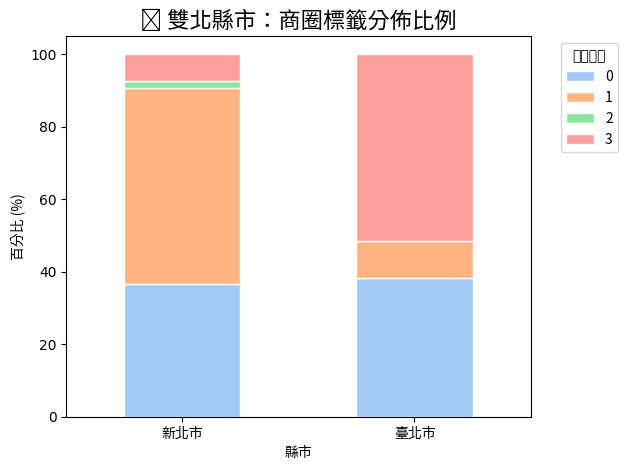

📈 雙北各標籤分佈百分比：
商圈標籤     0     1    2     3
縣市                         
新北市   36.5  54.3  1.9   7.3
臺北市   38.2  10.3  0.0  51.6


In [ ]:
# @title
# 1. 建立交叉表
city_cluster = pd.crosstab(X_train_raw['縣市'], X_train_raw['商圈標籤'], normalize='index') * 100

# 2. 繪製堆疊長條圖
plt.figure(figsize=(12, 6))
ax = city_cluster.plot(kind='bar', stacked=True, color=['#A1C9F4', '#FFB482', '#8DE5A1', '#FF9F9B'], edgecolor='white')

plt.title('🌆 雙北縣市：商圈標籤分佈比例', fontproperties=custom_font, size=16)
plt.xlabel('縣市', fontproperties=custom_font)
plt.ylabel('百分比 (%)', fontproperties=custom_font)
plt.legend(title='商圈標籤', prop=custom_font, bbox_to_anchor=(1.05, 1), loc='upper left')

# 修正座標軸字體
plt.xticks(rotation=0, fontproperties=custom_font)
plt.tight_layout()
plt.show()

print("📈 雙北各標籤分佈百分比：")
print(city_cluster.round(1))

# 模型訓練-XGBOOST

## XGBOOST(從這邊重新開始)

In [ ]:
golden_features = [
    '是否便利商店', '里人均收入中位數', '里人口數', '發票張數指標',
    '發票銷售額指標', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
    '500公尺外部競爭(不同公司店數)', '租金', 'people_per_store', '競爭優勢'
]

# --- 讀取原始資料並過濾有效樣本 ---
# 僅保留「營運中」與「廢止」的資料列
df_ml = df[df['登記現況'].isin(['營運中', '廢止'])].copy()
df_ml['target'] = df_ml['登記現況'].map({'營運中': 1, '廢止': 0})
X = df_ml[golden_features]
y = df_ml['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# ==========================================
# 1. 相關前處理 (XGBoost 專屬邏輯)
# ==========================================
# A. 權重校正：針對「廢止 (0)」樣本賦予 2.5 倍權重，強化風險識別
train_weights = np.where(y_train == 0, 2.5, 1.0)

# B. 轉換為 XGBoost 專用 DMatrix 格式
X_train_xgb = xgb.DMatrix(X_train, label=y_train, weight=train_weights)
X_val_xgb = xgb.DMatrix(X_val, label=y_val)

# ==========================================
# 2. 最終參數配置與訓練 (保持原樣，確保變數對接)
# ==========================================
final_params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1,
    'lambda': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss',
    'random_state': 42
}

print("🚀 啟動 XGBoost 訓練 (11特徵版-全局風險加權)...")
final_model = xgb.train(
    final_params,
    X_train_xgb,
    num_boost_round=100,
    evals=[(X_val_xgb, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=False
)
# ==========================================
# 3. 雙軌動態門檻判定邏輯 (修正變數：dtest -> X_test_xgb)
# ==========================================
def dynamic_predict(model, dmatrix, features_df):
    probs = model.predict(dmatrix)
    preds = []
    # 根據業態動態調整門檻：超商 0.5 / 一般 0.7
    is_cvs_array = features_df['是否便利商店'].values
    for i in range(len(probs)):
        threshold = 0.5 if is_cvs_array[i] == 1 else 0.7
        preds.append(1 if probs[i] >= threshold else 0)
    return np.array(preds), probs

# 修正：傳入正確的 DMatrix 變數
y_pred, y_prob = dynamic_predict(final_model, X_val_xgb, X_val)

# ==========================================
# 4. 產出最終戰力評估報告 (使用 X_test 進行回測)
# ==========================================
print("\n" + "█"*65)
print("🏆 專題最終成果報告：XGBoost 11特徵版 (驗證集確認)")
print("█"*65)

for g_val, g_name in [(0, "一般店鋪組 (超市/藥妝)"), (1, "便利商店組")]:
    mask = (X_val['是否便利商店'] == g_val)
    t_val = 0.5 if g_val == 1 else 0.7
    if mask.any():
        print(f"\n【{g_name}】判定門檻: {t_val}")
        print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_val[mask], y_pred[mask]):.2%}")
        print(f"  ● Recall 0 (風險捕捉率)  : {recall_score(y_val[mask], y_pred[mask], pos_label=0):.2%}")
        print(f"  ● Precision 1 (推薦信心度) : {precision_score(y_val[mask], y_pred[mask], pos_label=1):.2%}")

print("\n" + "█"*65)


🚀 啟動 XGBoost 訓練 (11特徵版-全局風險加權)...

█████████████████████████████████████████████████████████████████
🏆 專題最終成果報告：XGBoost 11特徵版 (驗證集確認)
█████████████████████████████████████████████████████████████████

【一般店鋪組 (超市/藥妝)】判定門檻: 0.7
  ● Accuracy (總體準確率)   : 55.46%
  ● Recall 0 (風險捕捉率)  : 52.63%
  ● Precision 1 (推薦信心度) : 86.15%

【便利商店組】判定門檻: 0.5
  ● Accuracy (總體準確率)   : 58.97%
  ● Recall 0 (風險捕捉率)  : 63.47%
  ● Precision 1 (推薦信心度) : 76.89%

█████████████████████████████████████████████████████████████████


In [ ]:
# 1. 建立統計結果 DataFrame
val_results_final = pd.DataFrame({
    '是否便利商店': X_val['是否便利商店'].values,
    '實際結果': y_val.values,
    '預測結果': y_pred,  # 這是 dynamic_predict 產出的雙軌判定結果
    '成功機率': y_prob
})

print("\n" + "█"*65)
print("🎯 驗證集實測：11 特徵版樣本抓取統計 (CVS: 0.5 / 一般: 0.7)")
print("█"*65)

for g_val, g_name in [(0, "一般店鋪組 (超市/藥妝)"), (1, "便利商店組")]:
    mask = (val_results_final['是否便利商店'] == g_val)
    group_data = val_results_final[mask]

    total = len(group_data)
    rec_count = (group_data['預測結果'] == 1).sum()   # 推薦 (1)
    risk_count = (group_data['預測結果'] == 0).sum()  # 標記風險 (0)

    # 計算推薦清單內的真實成功率 (Precision 1)
    correct_rec = ((group_data['預測結果'] == 1) & (group_data['實際結果'] == 1)).sum()
    precision = (correct_rec / rec_count) if rec_count > 0 else 0

    # 計算風險捕捉率 (Recall 0)
    actual_dead = (group_data['實際結果'] == 0).sum()
    detected_dead = ((group_data['預測結果'] == 0) & (group_data['實際結果'] == 0)).sum()
    recall0 = (detected_dead / actual_dead) if actual_dead > 0 else 0

    print(f"\n【{g_name}】門檻: {'0.5' if g_val==1 else '0.7'}")
    print(f"  ● 驗證集總店數: {total}")
    print(f"  ● 系統精選之「黃金店址」: {rec_count} 筆 (推薦率: {rec_count/total:.1%})")
    print(f"  ● 系統標記之「建議迴避」: {risk_count} 筆 (避險率: {risk_count/total:.1%})")
    print(f"  ● 推薦清單中的真實成功率 (Precision 1) : {precision:.2%}")
    print(f"  ● 實際廢止店鋪的捕捉率 (Recall 0)      : {recall0:.2%}")

print("\n" + "█"*65)


█████████████████████████████████████████████████████████████████
🎯 驗證集實測：11 特徵版樣本抓取統計 (CVS: 0.5 / 一般: 0.7)
█████████████████████████████████████████████████████████████████

【一般店鋪組 (超市/藥妝)】門檻: 0.7
  ● 驗證集總店數: 119
  ● 系統精選之「黃金店址」: 65 筆 (推薦率: 54.6%)
  ● 系統標記之「建議迴避」: 54 筆 (避險率: 45.4%)
  ● 推薦清單中的真實成功率 (Precision 1) : 86.15%
  ● 實際廢止店鋪的捕捉率 (Recall 0)      : 52.63%

【便利商店組】門檻: 0.5
  ● 驗證集總店數: 524
  ● 系統精選之「黃金店址」: 264 筆 (推薦率: 50.4%)
  ● 系統標記之「建議迴避」: 260 筆 (避險率: 49.6%)
  ● 推薦清單中的真實成功率 (Precision 1) : 76.89%
  ● 實際廢止店鋪的捕捉率 (Recall 0)      : 63.47%

█████████████████████████████████████████████████████████████████


In [ ]:
import pandas as pd
import numpy as np
import shap

def get_shap_stats(model, X_data, version_name):
    # 1. 計算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_data)

    # 2. 建立統計表
    # shap_values 的維度與 X_data 一致
    feature_names = X_data.columns
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    stats = []
    for col in feature_names:
        val = shap_df[col]
        stats.append({
            '特徵名稱': col,
            '總體影響力 (Mean |SHAP|)': np.abs(val).mean(),
            '正向貢獻 (營運推力)': val[val > 0].mean() if not val[val > 0].empty else 0,
            '負向貢獻 (失敗拉力)': val[val < 0].mean() if not val[val < 0].empty else 0
        })

    result_df = pd.DataFrame(stats).sort_values('總體影響力 (Mean |SHAP|)', ascending=False)

    print(f"\n" + "█"*75)
    print(f"📊 {version_name}：SHAP 特徵正負向貢獻統計表")
    print("█"*75)
    print(result_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return result_df

# --- 執行統計 ---

# 1. 版本一統計 (11特徵)
stats_v1 = get_shap_stats(final_model, X_val[golden_features], "版本一 (11特徵+2.5x權重)")



███████████████████████████████████████████████████████████████████████████
📊 版本一 (11特徵+2.5x權重)：SHAP 特徵正負向貢獻統計表
███████████████████████████████████████████████████████████████████████████
             特徵名稱  總體影響力 (Mean |SHAP|)  正向貢獻 (營運推力)  負向貢獻 (失敗拉力)
           是否便利商店               0.2564       0.8388      -0.0853
             競爭優勢               0.1760       0.1167      -0.2595
500公尺外部競爭(不同公司店數)               0.0982       0.1110      -0.0876
 people_per_store               0.0982       0.1226      -0.0748
               租金               0.0759       0.0715      -0.0826
        最近的熱鬧據點距離               0.0727       0.0729      -0.0724
           發票張數指標               0.0622       0.0809      -0.0447
 500公尺內部競爭(同公司店數)               0.0601       0.0590      -0.0612
         里人均收入中位數               0.0562       0.0504      -0.0645
             里人口數               0.0506       0.1028      -0.0222
          發票銷售額指標               0.0335       0.0277      -0.0456


## (放棄)(加入商圈標籤)

In [ ]:
import xgboost as xgb

# 1. 轉換 DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

# 2. 設定參數 (營運=1 版)
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss',
    'random_state': 42
}

# 3. 訓練模型
final_model = xgb.train(params, dtrain, num_boost_round=100)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


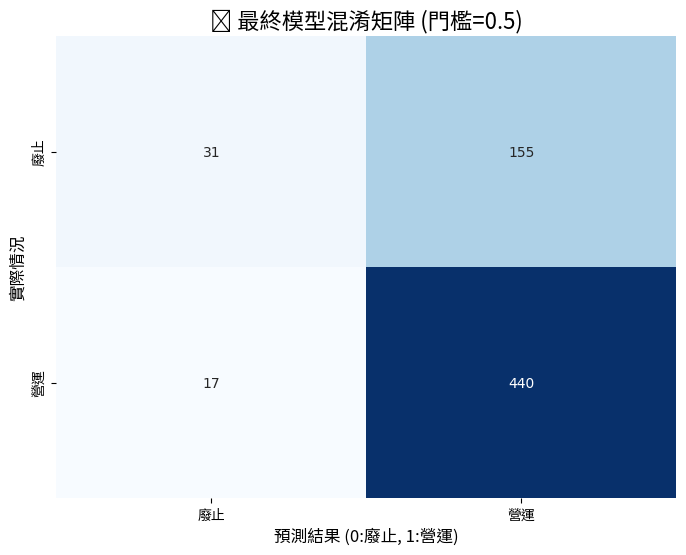

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)



████████████████████████████████████████████████████████████
🚀 最終優化版：全雙北選址模型評估報告 (營運=1)
████████████████████████████████████████████████████████████
              precision    recall  f1-score   support

       廢止(0)       0.65      0.17      0.26       186
      營運中(1)       0.74      0.96      0.84       457

    accuracy                           0.73       643
   macro avg       0.69      0.56      0.55       643
weighted avg       0.71      0.73      0.67       643

🏆 ROC-AUC 總分：0.6676


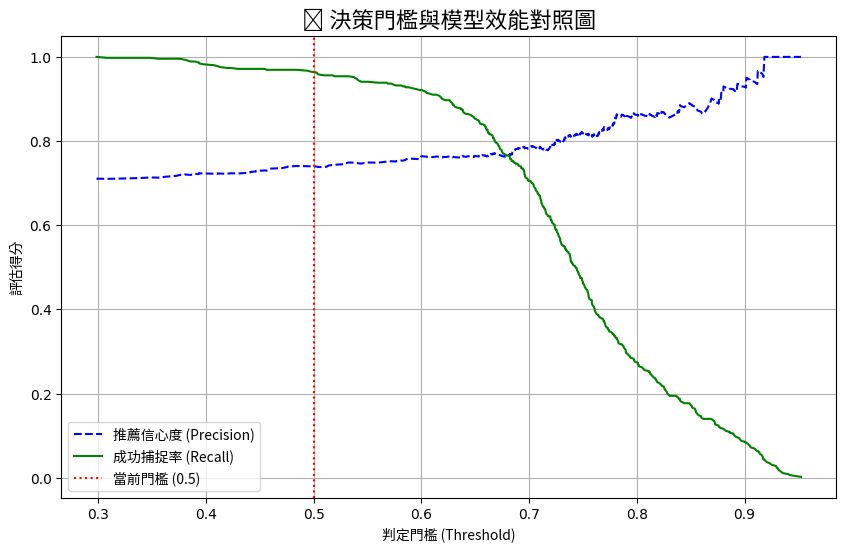

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 取得預測機率
y_prob = final_model.predict(dval)

# 2. 設定判定門檻 (預設 0.5)
# 如果您想要更高的推薦信心度，之後可以嘗試調高此數值
threshold = 0.5
y_pred = (y_prob > threshold).astype(int)

# ==========================================
# 3. 繪製混淆矩陣 (Confusion Matrix)
# ==========================================
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title(f'🎯 最終模型混淆矩陣 (門檻={threshold})', fontproperties=custom_font, size=16)
plt.xlabel('預測結果 (0:廢止, 1:營運)', fontproperties=custom_font, size=12)
plt.ylabel('實際情況', fontproperties=custom_font, size=12)
plt.xticks([0.5, 1.5], ['廢止', '營運'], fontproperties=custom_font)
plt.yticks([0.5, 1.5], ['廢止', '營運'], fontproperties=custom_font)
plt.show()

# ==========================================
# 4. 輸出分類報告
# ==========================================
print("\n" + "█"*60)
print("🚀 最終優化版：全雙北選址模型評估報告 (營運=1)")
print("█"*60)
print(classification_report(y_val, y_pred, target_names=['廢止(0)', '營運中(1)']))

auc_score = roc_auc_score(y_val, y_prob)
print(f"🏆 ROC-AUC 總分：{auc_score:.4f}")

# ==========================================
# 5. 推薦信心度分析 (Precision-Recall Curve)
# ==========================================
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='推薦信心度 (Precision)')
plt.plot(thresholds, recalls[:-1], 'g-', label='成功捕捉率 (Recall)')

plt.title('📈 決策門檻與模型效能對照圖', fontproperties=custom_font, size=16)
plt.xlabel('判定門檻 (Threshold)', fontproperties=custom_font)
plt.ylabel('評估得分', fontproperties=custom_font)
plt.axvline(x=threshold, color='red', linestyle=':', label=f'當前門檻 ({threshold})')
plt.legend(prop=custom_font)
plt.grid(True)
plt.show()

In [ ]:
# 4. 取得特徵貢獻度 (Gain)
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)
importance_df

,Feature,Gain
10,是否便利商店,21.624336
9,競爭優勢,11.812696
11,people_per_store,9.112767
8,競爭壓力指標,7.629261
0,里人均收入中位數,5.909163
1,里人口數,5.549605
7,租金_log,5.494713
3,發票銷售額指標,5.237289
5,最近的熱鬧據點類型,4.938033
2,發票張數指標,4.913383


/tmp/ipython-input-2710837148.py:10: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Noto Sans CJK TC.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


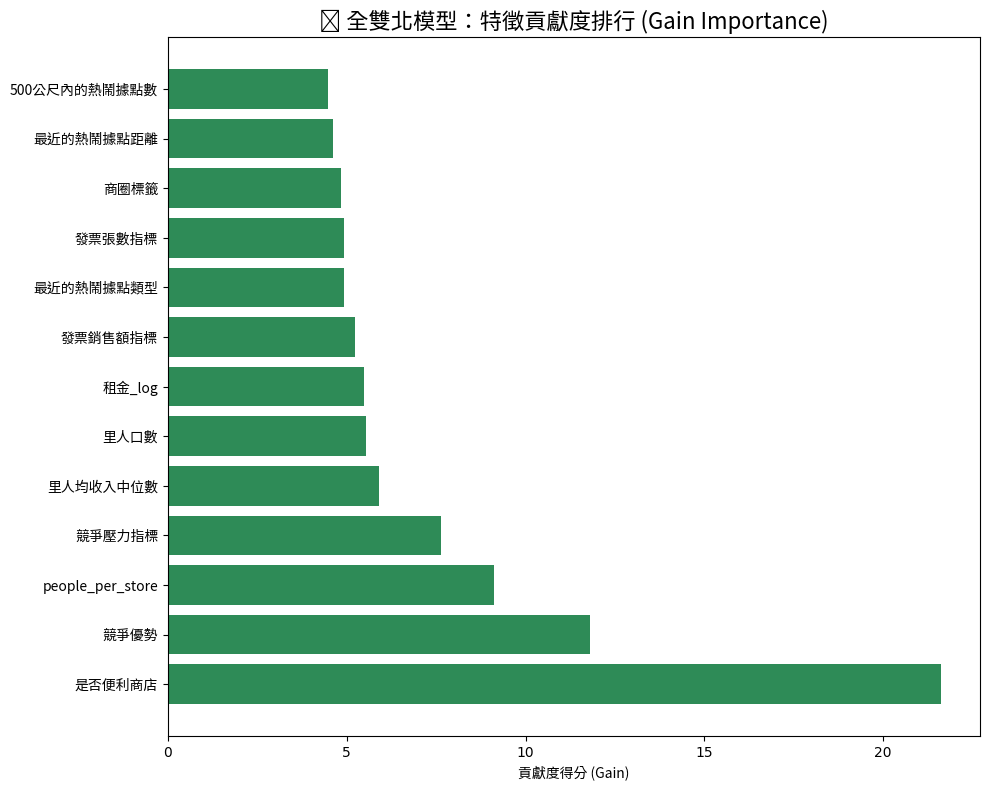

In [ ]:

# ==========================================
# 5. 繪製特徵貢獻度圖表
# ==========================================
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Gain'], color='#2E8B57')

plt.title('🏆 全雙北模型：特徵貢獻度排行 (Gain Importance)', fontproperties=custom_font, size=16)
plt.xlabel('貢獻度得分 (Gain)', fontproperties=custom_font)
plt.yticks(fontproperties=custom_font)
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 1. 鎖定這 11 個精銳特徵
# ==========================================
final_refined_cols = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '里人口數', '租金_log', '發票銷售額指標',
    '最近的熱鬧據點類型', '商圈標籤', '行政區平日日間活動人數'
]

# ==========================================
# 2. 權重補償：強迫模型去抓「廢止 (0)」
# ==========================================
# 既然 1 太多(457)，0 太少(186)，我們要縮減模型判定 1 的勇氣
# 設定 scale_pos_weight 為 0.4 或更低
params_v3 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.5,           # 增加複雜度懲罰，防止過擬合
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4, # 讓模型對「營運」的判斷變得很挑剔
    'eval_metric': 'logloss',
    'random_state': 42
}

dtrain_v3 = xgb.DMatrix(X_train[final_refined_cols], label=y_train, enable_categorical=True)
dval_v3 = xgb.DMatrix(X_val[final_refined_cols], label=y_val, enable_categorical=True)

model_v3 = xgb.train(params_v3, dtrain_v3, num_boost_round=150)


████████████████████████████████████████████████████████████
🎯 最終精華版：11特徵 + 權重補償 模型評估報告
████████████████████████████████████████████████████████████
              precision    recall  f1-score   support

       廢止(0)       0.40      0.56      0.47       186
      營運中(1)       0.79      0.65      0.71       457

    accuracy                           0.63       643
   macro avg       0.59      0.61      0.59       643
weighted avg       0.67      0.63      0.64       643



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


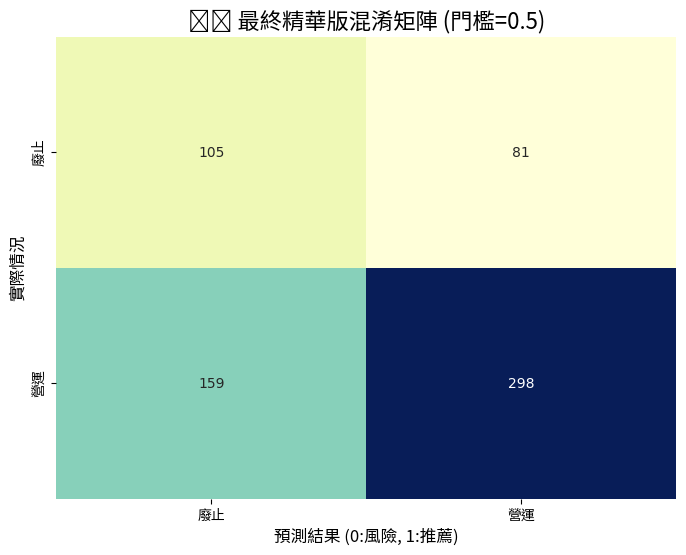

📈 風險偵測進度：從 186 筆廢止店鋪中成功抓出 105 筆 (Recall 0: 56.5%)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 取得預測機率與結果
# 使用我們精選的 11 個特徵進行預測
y_prob_v3 = model_v3.predict(dval_v3)
y_pred_v3 = (y_prob_v3 > 0.5).astype(int)

# ==========================================
# 2. 輸出分類報告
# ==========================================
print("\n" + "█"*60)
print("🎯 最終精華版：11特徵 + 權重補償 模型評估報告")
print("█"*60)
# 這裡我們觀察 廢止(0) 的 Recall 是否有顯著提升
print(classification_report(y_val, y_pred_v3, target_names=['廢止(0)', '營運中(1)']))

# ==========================================
# 3. 繪製混淆矩陣
# ==========================================
cm_v3 = confusion_matrix(y_val, y_pred_v3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_v3, annot=True, fmt='d', cmap='YlGnBu', cbar=False)

plt.title('⚖️ 最終精華版混淆矩陣 (門檻=0.5)', fontproperties=custom_font, size=16)
plt.xlabel('預測結果 (0:風險, 1:推薦)', fontproperties=custom_font, size=12)
plt.ylabel('實際情況', fontproperties=custom_font, size=12)
plt.xticks([0.5, 1.5], ['廢止', '營運'], fontproperties=custom_font)
plt.yticks([0.5, 1.5], ['廢止', '營運'], fontproperties=custom_font)
plt.show()

# ==========================================
# 4. 關鍵指標追蹤
# ==========================================
# 我們要看 186 筆廢止中，現在抓到了幾筆？
closed_detected = cm_v3[0, 0]
closed_total = 186
print(f"📈 風險偵測進度：從 186 筆廢止店鋪中成功抓出 {closed_detected} 筆 (Recall 0: {closed_detected/closed_total:.1%})")

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 22280 (\N{CJK UNIFIED IDEOGRAPH-5708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Gl

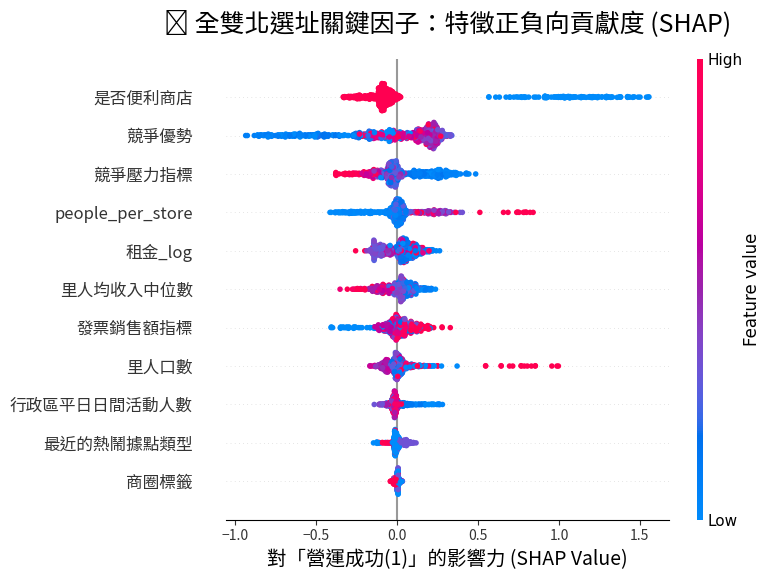

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. 準備 SHAP 專用資料：將類別型轉為代碼 (解決 SHAP 與 XGBoost 的類別特徵衝突)
X_shap = X_val[final_refined_cols].copy()
cat_cols = X_shap.select_dtypes(include=['category']).columns
for col in cat_cols:
    X_shap[col] = X_shap[col].cat.codes

# 2. 建立 SHAP 解釋器
# 這裡直接傳入模型，SHAP 會讀取裡面的樹結構
explainer = shap.TreeExplainer(model_v3)
shap_values = explainer.shap_values(X_shap)

# 3. 繪製 SHAP Summary Plot
plt.figure(figsize=(12, 10))

# 繪圖
# 我們手動關閉 show，以便後續用 custom_font 修正標籤
shap.summary_plot(shap_values, X_shap, plot_type="dot", show=False)

# 套用您的自定義字體
plt.title('💎 全雙北選址關鍵因子：特徵正負向貢獻度 (SHAP)', fontproperties=custom_font, size=18, pad=20)
plt.xlabel('對「營運成功(1)」的影響力 (SHAP Value)', fontproperties=custom_font, size=14)

# 修正 Y 軸特徵名稱與 X 軸數值的字體
ax = plt.gca()
for label in ax.get_yticklabels():
    label.set_fontproperties(custom_font)
    label.set_fontsize(12)
for label in ax.get_xticklabels():
    label.set_fontproperties(custom_font)

plt.tight_layout()
plt.show()

In [ ]:
# 1. 定義最終 10 個核心特徵
final_10_features = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '里人口數', '租金_log', '發票銷售額指標',
    '最近的熱鬧據點類型', '行政區平日日間活動人數', '最近的熱鬧據點距離'
]

# 2. 重新訓練
dtrain_f10 = xgb.DMatrix(X_train[final_10_features], label=y_train, enable_categorical=True)
dval_f10 = xgb.DMatrix(X_val[final_10_features], label=y_val, enable_categorical=True)

params_f10 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4,
    'eval_metric': 'logloss',
    'random_state': 42
}

model_f10 = xgb.train(params_f10, dtrain_f10, num_boost_round=150)

In [ ]:
# 取得預測
y_prob_f10 = model_f10.predict(dval_f10)
y_pred_f10 = (y_prob_f10 > 0.5).astype(int)

print("\n" + "█"*60)
print("🎯 10 特徵極簡版：移除商圈標籤後之模型評估")
print("█"*60)
print(classification_report(y_val, y_pred_f10, target_names=['廢止(0)', '營運中(1)']))

# 計算並顯示風險偵測率
cm_f10 = confusion_matrix(y_val, y_pred_f10)
recall_0 = cm_f10[0,0] / 186
precision_1 = cm_f10[1,1] / (cm_f10[1,1] + cm_f10[0,1])

print(f"📈 風議捕捉率 (Recall 0)：{recall_0:.1%}")
print(f"📈 推薦信心度 (Precision 1)：{precision_1:.1%}")


████████████████████████████████████████████████████████████
🎯 10 特徵極簡版：移除商圈標籤後之模型評估
████████████████████████████████████████████████████████████
              precision    recall  f1-score   support

       廢止(0)       0.40      0.58      0.47       186
      營運中(1)       0.79      0.64      0.71       457

    accuracy                           0.62       643
   macro avg       0.59      0.61      0.59       643
weighted avg       0.68      0.62      0.64       643

📈 風議捕捉率 (Recall 0)：58.1%
📈 推薦信心度 (Precision 1)：79.0%


In [ ]:
input_features = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '發票銷售額指標',
    '最近的熱鬧據點類型', '行政區平日日間活動人數', '最近的熱鬧據點距離',
    '商圈標籤'
]

# 2. 重新訓練
dtrain_f = xgb.DMatrix(X_train[input_features], label=y_train, enable_categorical=True)
dval_f = xgb.DMatrix(X_val[input_features], label=y_val, enable_categorical=True)

params_f = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4,
    'eval_metric': 'logloss',
    'random_state': 42
}

model_f = xgb.train(params_f, dtrain_f, num_boost_round=150)

# 取得預測
y_prob_f = model_f.predict(dval_f)
y_pred_f = (y_prob_f > 0.5).astype(int)

print("\n" + "█"*60)
print("🎯 商圈標籤版(刪除內含特徵)之模型評估")
print("█"*60)
print(classification_report(y_val, y_pred_f, target_names=['廢止(0)', '營運中(1)']))

# 計算並顯示風險偵測率
cm_f = confusion_matrix(y_val, y_pred_f)
recall_0 = cm_f[0,0] / 186
precision_1 = cm_f[1,1] / (cm_f[1,1] + cm_f[0,1])

print(f"📈 風議捕捉率 (Recall 0)：{recall_0:.1%}")
print(f"📈 推薦信心度 (Precision 1)：{precision_1:.1%}")


████████████████████████████████████████████████████████████
🎯 商圈標籤版(刪除內含特徵)之模型評估
████████████████████████████████████████████████████████████
              precision    recall  f1-score   support

       廢止(0)       0.42      0.56      0.48       186
      營運中(1)       0.79      0.68      0.74       457

    accuracy                           0.65       643
   macro avg       0.61      0.62      0.61       643
weighted avg       0.69      0.65      0.66       643

📈 風議捕捉率 (Recall 0)：56.5%
📈 推薦信心度 (Precision 1)：79.4%


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 22280 (\N{CJK UNIFIED IDEOGRAPH-5708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Gl

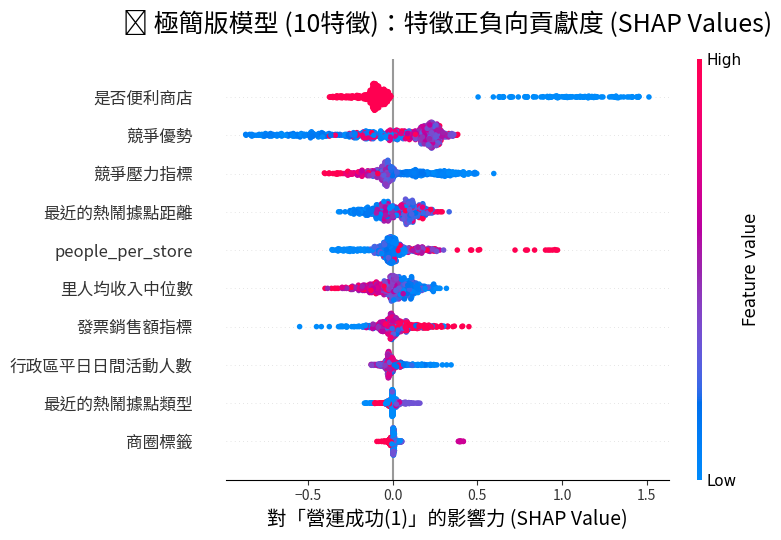

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. 準備 SHAP 專用資料：將類別型轉為代碼 (解決 SHAP 報錯)
# 使用您清單中的 10 個特徵
X_shap_f = X_val[input_features].copy()
cat_cols = X_shap_f.select_dtypes(include=['category']).columns
for col in cat_cols:
    X_shap_f[col] = X_shap_f[col].cat.codes

# 2. 建立 SHAP 解釋器並計算
explainer_f = shap.TreeExplainer(model_f)
shap_values_f = explainer_f.shap_values(X_shap_f)

# 3. 繪製 SHAP Summary Plot
plt.figure(figsize=(12, 10))

# 繪圖
shap.summary_plot(shap_values_f, X_shap_f, plot_type="dot", show=False)

# 套用您的自定義字體 (Noto Sans TC)
plt.title('💎 極簡版模型 (10特徵)：特徵正負向貢獻度 (SHAP Values)', fontproperties=custom_font, size=18, pad=20)
plt.xlabel('對「營運成功(1)」的影響力 (SHAP Value)', fontproperties=custom_font, size=14)

# 修正座標軸字體
ax = plt.gca()
for label in ax.get_yticklabels():
    label.set_fontproperties(custom_font)
    label.set_fontsize(12)
for label in ax.get_xticklabels():
    label.set_fontproperties(custom_font)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score

# 1. 取得第三版模型的全域預測機率
# 確保使用的是您定義的 10 特徵版 DMatrix (dval_f)
y_prob_v3 = model_f.predict(dval_f)

# ==========================================
# 2. 便利商店組 (CVS) 門檻測試
# ==========================================
cvs_mask = (X_val['是否便利商店'] == 1)
y_prob_cvs = y_prob_v3[cvs_mask.values]
y_true_cvs = y_val[cvs_mask].values

test_thresholds_cvs = [0.4, 0.45, 0.5, 0.55, 0.6]
cvs_results = []

for t in test_thresholds_cvs:
    y_pred_t = (y_prob_cvs >= t).astype(int)
    cvs_results.append({
        '門檻': t,
        '總體準確率': f"{accuracy_score(y_true_cvs, y_pred_t):.2%}",
        '風險捕捉率 (Recall 0)': f"{recall_score(y_true_cvs, y_pred_t, pos_label=0):.2%}",
        '推薦信心度 (Precision 1)': f"{precision_score(y_true_cvs, y_pred_t, pos_label=1):.2%}"
    })

print("\n" + "█"*60)
print("🏪 【第三版：便利商店組】門檻優化測試報告")
print("█"*60)
print(pd.DataFrame(cvs_results).to_string(index=False))

# ==========================================
# 3. 連鎖超市藥妝組 (一般組) 門檻測試
# ==========================================
gen_mask = (X_val['是否便利商店'] == 0)
y_prob_gen = y_prob_v3[gen_mask.values]
y_true_gen = y_val[gen_mask].values

# 針對高成本業態，測試更高區段的門檻以追求 90% Precision
test_thresholds_gen = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
gen_results = []

for t in test_thresholds_gen:
    y_pred_t = (y_prob_gen >= t).astype(int)
    gen_results.append({
        '門檻': t,
        '總體準確率': f"{accuracy_score(y_true_gen, y_pred_t):.2%}",
        '風險捕捉率 (Recall 0)': f"{recall_score(y_true_gen, y_pred_t, pos_label=0):.2%}",
        '推薦信心度 (Precision 1)': f"{precision_score(y_true_gen, y_pred_t, pos_label=1):.2%}"
    })

print("\n" + "█"*60)
print("🛒 【第三版：連鎖超市藥妝組】門檻壓力測試報告")
print("█"*60)
print(pd.DataFrame(gen_results).to_string(index=False))
print("█"*60)


████████████████████████████████████████████████████████████
🏪 【第三版：便利商店組】門檻優化測試報告
████████████████████████████████████████████████████████████
  門檻  總體準確率 風險捕捉率 (Recall 0) 推薦信心度 (Precision 1)
0.40 70.23%           36.53%              74.33%
0.45 66.41%           43.11%              74.39%
0.50 60.88%           62.87%              77.54%
0.55 50.57%           80.24%              79.88%
0.60 43.51%           91.02%              83.52%

████████████████████████████████████████████████████████████
🛒 【第三版：連鎖超市藥妝組】門檻壓力測試報告
████████████████████████████████████████████████████████████
  門檻  總體準確率 風險捕捉率 (Recall 0) 推薦信心度 (Precision 1)
0.50 83.19%            0.00%              83.90%
0.55 78.99%           10.53%              84.40%
0.60 75.63%           10.53%              83.81%
0.65 72.27%           36.84%              86.81%
0.70 52.94%           42.11%              83.33%
0.75 44.54%           57.89%              84.00%
████████████████████████████████████████████████████████████


## (不夠)(再拿掉商圈的第三版)

In [ ]:
# @title
# ==========================================
# 1. 部署 12 大戰略特徵 (結合 V1 的深度與 V3 的比例)
# ==========================================
final_master_features = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '發票銷售額指標', '行政區平日日間活動人數',
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '租金_log', '里人口數', '發票張數指標'
]

dtrain_master = xgb.DMatrix(X_train[final_master_features], label=y_train, enable_categorical=True)
dval_master = xgb.DMatrix(X_val[final_master_features], label=y_val, enable_categorical=True)

# ==========================================
# 2. 訓練配置：採用 V3 的穩定權重補償
# ==========================================
master_params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4,
    'eval_metric': 'logloss',
    'random_state': 42
}

final_model_master = xgb.train(master_params, dtrain_master, num_boost_round=150)

# ==========================================
# 3. 雙軌動態決策 (CVS=0.5 / 一般=0.7)
# ==========================================
y_prob_master = final_model_master.predict(dval_master)
y_pred_master = []

is_cvs_array = X_val['是否便利商店'].values
for i in range(len(y_prob_master)):
    # 針對超市藥妝組(0)採用嚴格門檻以衝高 Precision
    threshold = 0.5 if is_cvs_array[i] == 1 else 0.7
    y_pred_master.append(1 if y_prob_master[i] >= threshold else 0)

y_pred_master = np.array(y_pred_master)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

def evaluate_final_master(model, X_val_df, y_val_true):
    """
    針對終極混合版模型執行雙軌門檻評估
    """
    # 1. 確保特徵順序與訓練時一致
    final_features = [
        '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
        '里人均收入中位數', '發票銷售額指標', '行政區平日日間活動人數',
        '最近的熱鬧據點類型', '最近的熱鬧據點距離',
        '租金_log', '里人口數', '發票張數指標'
    ]

    # 2. 準備 DMatrix 並取得原始機率
    dval = xgb.DMatrix(X_val_df[final_features], enable_categorical=True)
    y_prob = model.predict(dval)

    # 3. 執行雙軌動態門檻邏輯
    # 超商組門檻 0.5 / 一般組 (超市藥妝) 門檻 0.7
    y_pred = []
    is_cvs_array = X_val_df['是否便利商店'].values

    for i in range(len(y_prob)):
        threshold = 0.5 if is_cvs_array[i] == 1 else 0.7
        y_pred.append(1 if y_prob[i] >= threshold else 0)

    y_pred = np.array(y_pred)

    # 4. 輸出診斷報告
    print("\n" + "█"*65)
    print("🏆 專題最終定案：終極混合版 (12特徵 + 雙軌門檻) 評估報告")
    print("█"*65)

    for g_val, g_name in [(0, "連鎖超市藥妝組"), (1, "便利商店組 (CVS)")]:
        mask = (X_val_df['是否便利商店'] == g_val)
        t_val = 0.5 if g_val == 1 else 0.7

        if mask.any():
            y_true_g = y_val_true[mask]
            y_pred_g = y_pred[mask]

            print(f"\n【{g_name}】判定門檻: {t_val}")
            print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_true_g, y_pred_g):.2%}")
            print(f"  ● Recall 0 (風險捕捉率)  : {recall_score(y_true_g, y_pred_g, pos_label=0):.2%}")
            print(f"  ● Precision 1 (推薦信心度) : {precision_score(y_true_g, y_pred_g, pos_label=1):.2%}")

    print("\n" + "█"*65)

    return y_pred, y_prob

# --- 呼叫評估 ---
# 假設您的模型變數名稱為 final_model_master
y_pred, y_prob = evaluate_final_master(final_model_master, X_val, y_val)


█████████████████████████████████████████████████████████████████
🏆 專題最終定案：終極混合版 (12特徵 + 雙軌門檻) 評估報告
█████████████████████████████████████████████████████████████████

【連鎖超市藥妝組】判定門檻: 0.7
  ● Accuracy (總體準確率)   : 59.66%
  ● Recall 0 (風險捕捉率)  : 47.37%
  ● Precision 1 (推薦信心度) : 86.11%

【便利商店組 (CVS)】判定門檻: 0.5
  ● Accuracy (總體準確率)   : 59.35%
  ● Recall 0 (風險捕捉率)  : 62.28%
  ● Precision 1 (推薦信心度) : 76.67%

█████████████████████████████████████████████████████████████████


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score

# 1. 取得終極混合版全域預測機率
y_prob_master = final_model_master.predict(dval_master)
test_thresholds = np.arange(0.4, 0.81, 0.05) # 測試 0.4, 0.45 ... 0.8

def run_threshold_test(mask, group_name):
    y_true_g = y_val[mask].values
    y_prob_g = y_prob_master[mask.values]
    results = []

    for t in test_thresholds:
        y_pred_t = (y_prob_g >= t).astype(int)
        # 處理 Precision 可能為 0 的情況
        prec = precision_score(y_true_g, y_pred_t, pos_label=1, zero_division=0)
        rec0 = recall_score(y_true_g, y_pred_t, pos_label=0, zero_division=0)
        acc = accuracy_score(y_true_g, y_pred_t)

        results.append({
            '門檻': round(t, 2),
            'Accuracy': f"{acc:.2%}",
            'Recall 0 (風險捕捉)': f"{rec0:.2%}",
            'Precision 1 (推薦信心)': f"{prec:.2%}"
        })

    print(f"\n📊 【{group_name}】0.4-0.8 壓力測試報告")
    print(pd.DataFrame(results).to_string(index=False))

# --- 執行兩組測試 ---
cvs_mask = (X_val['是否便利商店'] == 1)
gen_mask = (X_val['是否便利商店'] == 0)

run_threshold_test(cvs_mask, "便利商店組 (CVS)")
run_threshold_test(gen_mask, "連鎖超市藥妝組 (一般)")


📊 【便利商店組 (CVS)】0.4-0.8 壓力測試報告
  門檻 Accuracy Recall 0 (風險捕捉) Precision 1 (推薦信心)
0.40   70.99%          35.93%             74.46%
0.45   65.84%          46.11%             74.86%
0.50   59.35%          62.28%             76.67%
0.55   49.62%          77.25%             77.51%
0.60   41.60%          89.22%             79.31%
0.65   39.69%          95.81%             87.27%
0.70   36.26%          97.60%             87.10%
0.75   36.07%          99.40%             95.83%
0.80   34.73%         100.00%            100.00%

📊 【連鎖超市藥妝組 (一般)】0.4-0.8 壓力測試報告
  門檻 Accuracy Recall 0 (風險捕捉) Precision 1 (推薦信心)
0.40   83.19%           0.00%             83.90%
0.45   83.19%           0.00%             83.90%
0.50   80.67%           0.00%             83.48%
0.55   78.15%           5.26%             83.64%
0.60   78.15%          21.05%             85.58%
0.65   72.27%          26.32%             85.26%
0.70   59.66%          47.37%             86.11%
0.75   45.38%          63.16%             85.71%
0.80  

In [ ]:
# 1. 取得驗證集的預測機率
dval_master = xgb.DMatrix(X_val[final_master_features], enable_categorical=True)
y_prob_val = final_model_master.predict(dval_master)

# 2. 執行雙軌判定邏輯：CVS=0.5, 一般=0.7
is_cvs_array = X_val['是否便利商店'].values
y_pred_dynamic = []

for i in range(len(y_prob_val)):
    # 根據業態切換門檻
    threshold = 0.5 if is_cvs_array[i] == 1 else 0.7
    y_pred_dynamic.append(1 if y_prob_val[i] >= threshold else 0)

y_pred_dynamic = np.array(y_pred_dynamic)

# 3. 建立結果表
val_results_dynamic = pd.DataFrame({
    '是否便利商店': X_val['是否便利商店'].values,
    '實際結果': y_val.values,
    '預測結果': y_pred_dynamic,
    '成功機率': y_prob_val
})

print("\n" + "█"*65)
print("🏆 終極混合版：雙軌門檻動態統計 (CVS: 0.5 / 超市: 0.7)")
print("█"*65)

for g_val, g_name in [(0, "連鎖超市藥妝組"), (1, "便利商店組 (CVS)")]:
    mask = (val_results_dynamic['是否便利商店'] == g_val)
    group_data = val_results_dynamic[mask]

    total = len(group_data)
    rec_count = (group_data['預測結果'] == 1).sum()   # 推薦 (1)
    risk_count = (group_data['預測結果'] == 0).sum()  # 標記風險 (0)

    # 計算推薦清單內的真實成功率 (Precision 1)
    correct_rec = ((group_data['預測結果'] == 1) & (group_data['實際結果'] == 1)).sum()
    precision = (correct_rec / rec_count) if rec_count > 0 else 0

    # 計算風險捕捉率 (Recall 0)
    actual_dead = (group_data['實際結果'] == 0).sum()
    detected_dead = ((group_data['預測結果'] == 0) & (group_data['實際結果'] == 0)).sum()
    recall0 = (detected_dead / actual_dead) if actual_dead > 0 else 0

    print(f"\n【{g_name}】門檻: {'0.5' if g_val==1 else '0.7'}")
    print(f"  ● 總店數: {total}")
    print(f"  ● 系統精選之「黃金店址」: {rec_count} 筆 (推薦率: {rec_count/total:.1%})")
    print(f"  ● 系統標記之「建議迴避」: {risk_count} 筆 (避險率: {risk_count/total:.1%})")
    print(f"  ● 推薦清單中的真實成功率 (Precision 1) : {precision:.2%}")
    print(f"  ● 實際廢止店鋪的捕捉率 (Recall 0)      : {recall0:.2%}")

print("\n" + "█"*65)


█████████████████████████████████████████████████████████████████
🏆 終極混合版：雙軌門檻動態統計 (CVS: 0.5 / 超市: 0.7)
█████████████████████████████████████████████████████████████████

【連鎖超市藥妝組】門檻: 0.7
  ● 總店數: 119
  ● 系統精選之「黃金店址」: 72 筆 (推薦率: 60.5%)
  ● 系統標記之「建議迴避」: 47 筆 (避險率: 39.5%)
  ● 推薦清單中的真實成功率 (Precision 1) : 86.11%
  ● 實際廢止店鋪的捕捉率 (Recall 0)      : 47.37%

【便利商店組 (CVS)】門檻: 0.5
  ● 總店數: 524
  ● 系統精選之「黃金店址」: 270 筆 (推薦率: 51.5%)
  ● 系統標記之「建議迴避」: 254 筆 (避險率: 48.5%)
  ● 推薦清單中的真實成功率 (Precision 1) : 76.67%
  ● 實際廢止店鋪的捕捉率 (Recall 0)      : 62.28%

█████████████████████████████████████████████████████████████████


In [ ]:
def get_shap_stats_fixed(model, X_data, version_name):
    # 複製資料，避免改動到原始 df
    X_processed = X_data.copy()

    # 🚀 手動處理類別型特徵：將 category 轉為 codes (數值)
    # SHAP TreeExplainer 對於數值化的類別特徵具備良好的相容性
    for col in X_processed.select_dtypes(include=['category']).columns:
        X_processed[col] = X_processed[col].cat.codes

    # 1. 計算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_processed)

    # 2. 建立統計表
    feature_names = X_processed.columns
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    stats = []
    for col in feature_names:
        val = shap_df[col]
        stats.append({
            '特徵名稱': col,
            '總體影響力 (Mean |SHAP|)': np.abs(val).mean(),
            '正向貢獻 (營運推力)': val[val > 0].mean() if not val[val > 0].empty else 0,
            '負向貢獻 (失敗拉力)': val[val < 0].mean() if not val[val < 0].empty else 0
        })

    result_df = pd.DataFrame(stats).sort_values('總體影響力 (Mean |SHAP|)', ascending=False)

    print(f"\n" + "█"*75)
    print(f"📊 {version_name}：SHAP 特徵正負向貢獻統計表 (已修正類別型)")
    print("█"*75)
    print(result_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return result_df

# 重新執行版本三統計
stats_master = get_shap_stats_fixed(final_model_master, df_test_ready[features_master], "版本三 (12特徵 Master)")


███████████████████████████████████████████████████████████████████████████
📊 版本三 (12特徵 Master)：SHAP 特徵正負向貢獻統計表 (已修正類別型)
███████████████████████████████████████████████████████████████████████████
            特徵名稱  總體影響力 (Mean |SHAP|)  正向貢獻 (營運推力)  負向貢獻 (失敗拉力)
          是否便利商店               0.2992       1.0821      -0.1103
            競爭優勢               0.2586       0.1855      -0.3558
          競爭壓力指標               0.1163       0.1342      -0.1006
       最近的熱鬧據點距離               0.0941       0.1004      -0.0864
people_per_store               0.0923       0.0999      -0.0846
          租金_log               0.0766       0.0713      -0.0850
        里人均收入中位數               0.0730       0.0626      -0.0961
          發票張數指標               0.0638       0.0963      -0.0438
            里人口數               0.0518       0.0623      -0.0409
         發票銷售額指標               0.0366       0.0315      -0.0475
     行政區平日日間活動人數               0.0345       0.0575      -0.0245
       最近的熱鬧據點類型               0.0

## (放棄)(嘗試用peer_comp_history)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score
import shap
import pickle
# ==========================================
# 3. 相關前處理 (XGBoost 專屬邏輯)
# ==========================================
# --- 這裡是最關鍵的：確保切分後的資料也是 category ---
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

# 再次檢查 (這行如果沒印出東西就穩了)
print("X_train 殘留 object 檢查:", X_train.select_dtypes(include=['object']).columns.tolist())

# A. 權重校正
train_weights = np.where(y_train == 0, 2.5, 1.0)

# B. 轉換為 XGBoost 專用 DMatrix 格式 (務必保留 enable_categorical=True)
X_train_xgb = xgb.DMatrix(X_train, label=y_train, weight=train_weights, enable_categorical=True)
X_val_xgb = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

X_train 殘留 object 檢查: []


In [ ]:
# ==========================================
# 4. 模型訓練 (XGBoost)
# ==========================================

# 設定模型參數
params = {
    'objective': 'binary:logistic',  # 二元分類
    'eval_metric': ['logloss', 'auc'], # 監控指標
    'eta': 0.05,                     # 學習率
    'max_depth': 6,                  # 樹深度
    'subsample': 0.8,                # 隨機採樣比例
    'colsample_bytree': 0.8,         # 特徵採樣比例
    'tree_method': 'hist',           # 處理類別型特徵必備
    'device': 'cuda',                # 若 Colab 有 GPU 可開啟
    'random_state': 42
}

# 設定監控名單 (同時監控訓練集與驗證集)
evals_result = {}
watchlist = [(X_train_xgb, 'train'), (X_val_xgb, 'val')]

# 開始訓練
model = xgb.train(
    params,
    X_train_xgb,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,       # 50 輪內驗證集沒進步就停止
    evals_result=evals_result,
    verbose_eval=50                 # 每 50 輪印一次 log
)

[0]	train-logloss:0.67880	train-auc:0.78336	val-logloss:0.70553	val-auc:0.72857


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:13:25] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:13:25] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()


[50]	train-logloss:0.44215	train-auc:0.90208	val-logloss:0.52495	val-auc:0.82683
[100]	train-logloss:0.37890	train-auc:0.93378	val-logloss:0.50906	val-auc:0.82824
[116]	train-logloss:0.36363	train-auc:0.94148	val-logloss:0.50711	val-auc:0.82705


In [ ]:
# ==========================================
# 5. 成效驗證
# ==========================================

# 取得預測機率
y_pred_prob = model.predict(X_val_xgb)
# 轉換為 0 或 1 (門檻值 0.5)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]

# 計算指標
accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)      # 抓出「營運中」的能力
precision = precision_score(y_val, y_pred) # 預測「營運中」的準確率

print(f"\n📊 驗證集表現:")
print(f"✅ 準確率 (Accuracy): {accuracy:.4f}")
print(f"🎯 精準率 (Precision): {precision:.4f}")
print(f"📈 召回率 (Recall): {recall:.4f}")


📊 驗證集表現:
✅ 準確率 (Accuracy): 0.7437
🎯 精準率 (Precision): 0.8831
📈 召回率 (Recall): 0.7249


In [ ]:
# 取得重要性分數並轉為 DataFrame
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance': list(importance_scores.values())
}).sort_values(by='Importance', ascending=False)

print("█" + "━"*40 + "█")
print("🚀 XGBoost 特徵重要性排名 (Gain)")
print(importance_df.head(11).to_string(index=False))
print("█" + "━"*40 + "█")

█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█
🚀 XGBoost 特徵重要性排名 (Gain)
                Feature  Importance
                 是否便利商店   23.036997
cross_comp_500m_history   19.066177
                 競爭壓力指標   12.124369
       people_per_store   11.975656
 peer_comp_500m_history   11.552168
                   生存難度   10.960435
                   競爭優勢    9.205280
                   里人口數    8.115149
         day_night_flow    7.935179
                     租金    7.440452
                發票銷售額指標    6.951263
█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█


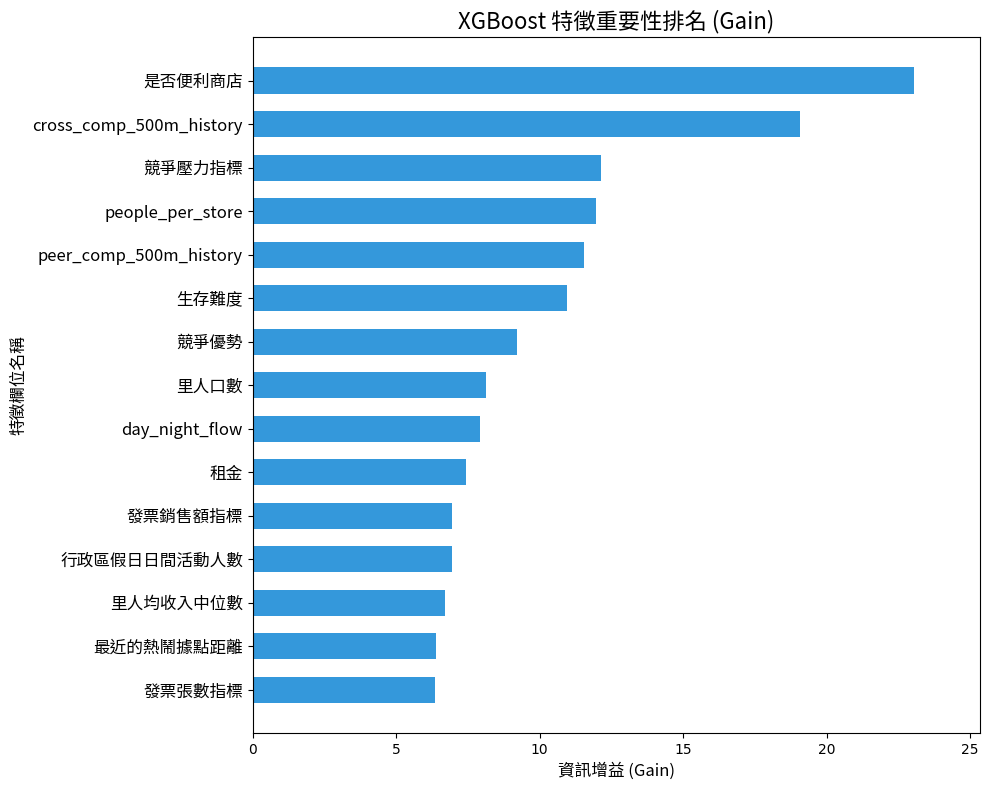

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# 建立畫布與軸物件
fig, ax = plt.subplots(figsize=(10, 8))

# 繪製重要性：使用 'gain' (資訊增益) 通常比預測次數 (weight) 更能反映特徵的實質影響力
plot_importance(
    model,
    ax=ax,
    importance_type='gain',
    max_num_features=15,    # 顯示前 15 名
    grid=False,
    show_values=False,
    height=0.6,
    color='#3498db',
    title='XGBoost 特徵重要性排名 (Gain)'
)

# --- 核心修正：套用中文字體 ---
# 1. 修改標題
ax.set_title('XGBoost 特徵重要性排名 (Gain)', fontproperties=custom_font, size=16)

# 2. 修改 Y 軸標籤 (特徵名稱)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=custom_font, size=12)

# 3. 修改 X 軸與 Y 軸標題
ax.set_xlabel('資訊增益 (Gain)', fontproperties=custom_font, size=12)
ax.set_ylabel('特徵欄位名稱', fontproperties=custom_font, size=12)

plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 2. 最終參數配置與訓練 (保持原樣，確保變數對接)
# ==========================================
final_params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1,
    'lambda': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss',
    'random_state': 42
}

print("🚀 啟動 XGBoost 訓練 (11特徵版-全局風險加權)...")
final_model = xgb.train(
    final_params,
    X_train_xgb,
    num_boost_round=100,
    evals=[(X_val_xgb, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=False
)


🚀 啟動 XGBoost 訓練 (11特徵版-全局風險加權)...


In [ ]:
# ==========================================
# 3. 雙軌動態門檻判定邏輯 (修正變數：dtest -> X_test_xgb)
# ==========================================
def dynamic_predict(model, dmatrix, features_df):
    probs = model.predict(dmatrix)
    preds = []
    # 根據業態動態調整門檻：超商 0.5 / 一般 0.6
    is_cvs_array = features_df['是否便利商店'].values
    for i in range(len(probs)):
        threshold = 0.5 if is_cvs_array[i] == 1 else 0.6
        preds.append(1 if probs[i] >= threshold else 0)
    return np.array(preds), probs

# 修正：傳入正確的 DMatrix 變數
y_pred, y_prob = dynamic_predict(final_model, X_val_xgb, X_val)

# ==========================================
# 4. 產出最終戰力評估報告 (使用 X_test 進行回測)
# ==========================================
print("\n" + "█"*65)
print("🏆 專題最終成果報告：XGBoost 11特徵版 (驗證集確認)")
print("█"*65)

for g_val, g_name in [(0, "一般店鋪組 (超市/藥妝)"), (1, "便利商店組")]:
    mask = (X_val['是否便利商店'] == g_val)
    t_val = 0.5 if g_val == 1 else 0.6
    if mask.any():
        print(f"\n【{g_name}】判定門檻: {t_val}")
        print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_val[mask], y_pred[mask]):.2%}")
        print(f"  ● Recall 0 (風險捕捉率)  : {recall_score(y_val[mask], y_pred[mask], pos_label=0):.2%}")
        print(f"  ● Precision 1 (推薦信心度) : {precision_score(y_val[mask], y_pred[mask], pos_label=1):.2%}")

print("\n" + "█"*65)



█████████████████████████████████████████████████████████████████
🏆 專題最終成果報告：XGBoost 11特徵版 (驗證集確認)
█████████████████████████████████████████████████████████████████

【一般店鋪組 (超市/藥妝)】判定門檻: 0.6
  ● Accuracy (總體準確率)   : 77.14%
  ● Recall 0 (風險捕捉率)  : 53.85%
  ● Precision 1 (推薦信心度) : 88.68%

【便利商店組】判定門檻: 0.5
  ● Accuracy (總體準確率)   : 72.54%
  ● Recall 0 (風險捕捉率)  : 88.04%
  ● Precision 1 (推薦信心度) : 91.24%

█████████████████████████████████████████████████████████████████


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       754 non-null    int64  
 1   公司名稱                     754 non-null    object 
 2   分公司名稱                    754 non-null    object 
 3   縣市                       754 non-null    object 
 4   行政區                      754 non-null    object 
 5   里別                       754 non-null    object 
 6   行政區平日夜間停留人數              754 non-null    int64  
 7   行政區平日日間活動人數              754 non-null    int64  
 8   行政區假日夜間停留人數              754 non-null    int64  
 9   行政區假日日間活動人數              754 non-null    int64  
 10  里人均收入中位數                 754 non-null    int64  
 11  里人口數                     754 non-null    int64  
 12  發票張數指標                   754 non-null    float64
 13  發票銷售額指標                  754 non-null    float64
 14  500公尺內的熱鬧據點數             7

In [ ]:
# ==========================================
# 5. 執行雙軌動態門檻預測
# ==========================================
# 先取得模型原始預測機率
y_test_prob = final_model.predict(dtest_final)

# ==========================================
# 6. 產出【獨立測試集】實戰成果報告 (門檻調整版)
# ==========================================
print("\n" + "█"*75)
print("📊 專題最終實戰回測：XGBoost 11 特徵版 (門檻：一般 0.6 / 超商 0.5)")
print("█"*75)

for g_val, g_name in [(0, "一般店鋪組 (超市/藥妝)"), (1, "便利商店組")]:
    mask = (X_final_test['是否便利商店'] == g_val)

    # 執行門檻邏輯：一般組 0.6，便利商店 0.5
    t_val = 0.5 if g_val == 1 else 0.6

    if mask.any():
        y_true_sub = y_final_test[mask]
        y_prob_sub = y_test_prob[mask]

        # 根據新的門檻值重新判定 0 或 1
        # 邏輯：P(營運中) >= t_val -> 1
        y_pred_sub = (y_prob_sub >= t_val).astype(int)

        print(f"\n【{g_name}】判定門檻: {t_val}")
        print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_true_sub, y_pred_sub):.2%}")

        # Recall 0：捕捉「潛在廢止店」的成功率 (風險控管)
        r0 = recall_score(y_true_sub, y_pred_sub, pos_label=0)
        print(f"  ● Recall 0 (風險捕捉率)  : {r0:.2%}")

        # Precision 1：當模型說「可以開」時，準確的機率
        p1 = precision_score(y_true_sub, y_pred_sub, pos_label=1)
        print(f"  ● Precision 1 (推薦信心度) : {p1:.2%}")

        print(f"  ● 樣本分佈: 營運 {sum(y_true_sub==1)} 筆 / 廢止 {sum(y_true_sub==0)} 筆")

print("\n" + "█"*75)


███████████████████████████████████████████████████████████████████████████
📊 專題最終實戰回測：XGBoost 11 特徵版 (門檻：一般 0.6 / 超商 0.5)
███████████████████████████████████████████████████████████████████████████

【一般店鋪組 (超市/藥妝)】判定門檻: 0.6
  ● Accuracy (總體準確率)   : 80.00%
  ● Recall 0 (風險捕捉率)  : 77.78%
  ● Precision 1 (推薦信心度) : 93.81%
  ● 樣本分佈: 營運 113 筆 / 廢止 27 筆

【便利商店組】判定門檻: 0.5
  ● Accuracy (總體準確率)   : 70.52%
  ● Recall 0 (風險捕捉率)  : 82.13%
  ● Precision 1 (推薦信心度) : 87.67%
  ● 樣本分佈: 營運 407 筆 / 廢止 207 筆

███████████████████████████████████████████████████████████████████████████


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 29151 (\N{CJK UNIFIED IDEOGRAPH-71DF}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from fon

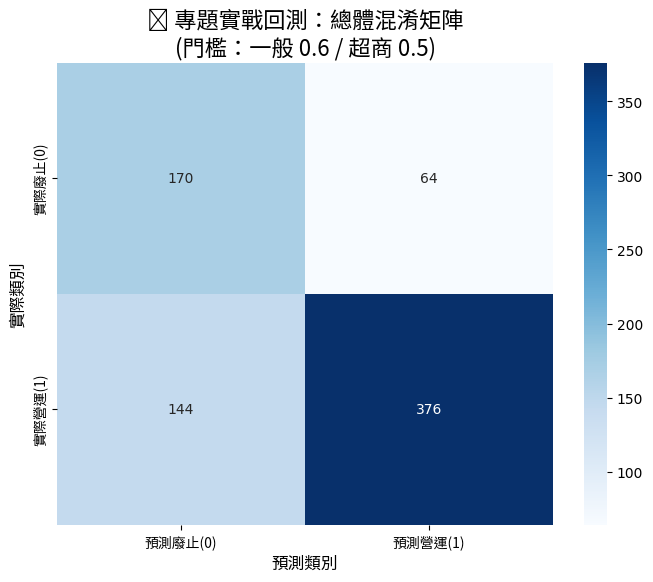

█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█
📊 測試集最終戰果統計
█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█
 總測試資料筆數   : 754 筆
 成功抓出『廢止』  :  170 筆 (風險避雷成功)
 成功抓出『營運』  :  376 筆 (優質店點推薦)
 總計正確預測     :  546 筆
 總體命中率 (Acc) : 72.41%
----------------------------------------------------
 ⚠️ 漏看風險 (實際廢止卻預測營運):   64 筆 (這最危險！)
 💡 錯失良機 (實際營運卻預測廢止):  144 筆 (可惜了...)
█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 在這裡設定您想測試的新門檻 ---
threshold_general = 0.7  # 假設想對一般組更嚴格
threshold_cvs = 0.5      # 假設想對超商組也加嚴

# --- 重新計算預測結果 (這是關鍵步驟) ---
y_final_pred_all = np.zeros_like(y_test_prob)

# 處理一般組 (is_cvs=0)
mask_gen = (X_final_test['是否便利商店'] == 0)
y_final_pred_all[mask_gen] = (y_test_prob[mask_gen] >= threshold_general).astype(int)

# 處理超商組 (is_cvs=1)
mask_cvs = (X_final_test['是否便利商店'] == 1)
y_final_pred_all[mask_cvs] = (y_test_prob[mask_cvs] >= threshold_cvs).astype(int)

# --- Step 2. 計算混淆矩陣 ---
cm = confusion_matrix(y_final_test, y_final_pred_all)
tn, fp, fn, tp = cm.ravel()

# --- Step 3. 視覺化繪圖 ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['預測廢止(0)', '預測營運(1)'],
            yticklabels=['實際廢止(0)', '實際營運(1)'])

plt.title('🏆 專題實戰回測：總體混淆矩陣\n(門檻：一般 0.6 / 超商 0.5)', fontproperties=custom_font, size=16)
plt.xlabel('預測類別', fontproperties=custom_font, size=12)
plt.ylabel('實際類別', fontproperties=custom_font, size=12)

# 修正座標軸中文顯示
ax = plt.gca()
ax.set_xticklabels(['預測廢止(0)', '預測營運(1)'], fontproperties=custom_font)
ax.set_yticklabels(['實際廢止(0)', '實際營運(1)'], fontproperties=custom_font)

plt.show()

# --- Step 4. 產出統計數據 ---
print("█" + "━"*50 + "█")
print(f"📊 測試集最終戰果統計")
print("█" + "━"*50 + "█")
print(f" 總測試資料筆數   : {len(y_final_test)} 筆")
print(f" 成功抓出『廢止』  : {tn:4d} 筆 (風險避雷成功)")
print(f" 成功抓出『營運』  : {tp:4d} 筆 (優質店點推薦)")
print(f" 總計正確預測     : {tn + tp:4d} 筆")
print(f" 總體命中率 (Acc) : {(tn + tp)/len(y_final_test):.2%}")
print("-" * 52)
print(f" ⚠️ 漏看風險 (實際廢止卻預測營運): {fp:4d} 筆 (這最危險！)")
print(f" 💡 錯失良機 (實際營運卻預測廢止): {fn:4d} 筆 (可惜了...)")
print("█" + "━"*50 + "█")

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas

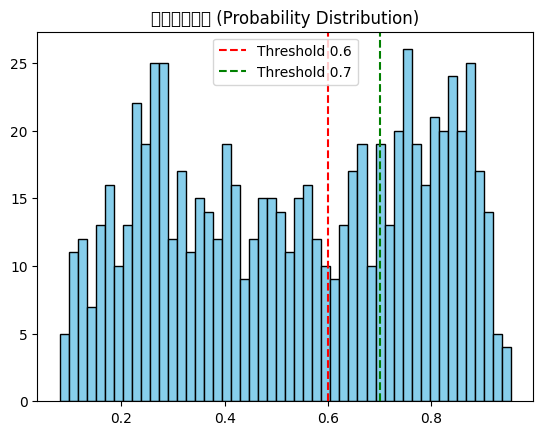

機率範例 (前5筆): [0.39178884 0.2623004  0.56649756 0.757478   0.11654872]


In [ ]:
import matplotlib.pyplot as plt

# 繪製機率分佈圖
plt.hist(y_test_prob, bins=50, color='skyblue', edgecolor='black')
plt.title('預測機率分佈 (Probability Distribution)')
plt.axvline(0.6, color='red', linestyle='--', label='Threshold 0.6')
plt.axvline(0.7, color='green', linestyle='--', label='Threshold 0.7')
plt.legend()
plt.show()

# 檢查一下裡面是不是真的有小數點
print(f"機率範例 (前5筆): {y_test_prob[:5]}")

In [ ]:
in_between = ((y_test_prob >= 0.6) & (y_test_prob < 0.7)).sum()
print(f"落在 0.6 到 0.7 之間的店點數量：{in_between} 筆")

落在 0.6 到 0.7 之間的店點數量：80 筆


In [ ]:
# 1. 抓出落在 0.6 ~ 0.7 之間的一般組店點
mask_swing = (mask_gen) & (y_test_prob >= 0.6) & (y_test_prob < 0.7)
df_swing = X_final_test[mask_swing].copy()
y_swing_true = y_final_test[mask_swing]

# 2. 統計這 80 筆的真實狀況
true_op = (y_swing_true == 1).sum()
true_fail = (y_swing_true == 0).sum()

print("█" + "━"*40 + "█")
print(f"🔍 邊緣 80 筆店點分析 (機率 0.6~0.7)")
print("█" + "━"*40 + "█")
print(f"  ● 實際營運中: {true_op} 筆")
print(f"  ● 實際已廢止: {true_fail} 筆")
print("-" * 42)

if true_fail > true_op:
    print(f"✅ 建議維持 0.7：這區間『廢止』較多，調高門檻能多抓出 {true_fail} 個風險。")
else:
    print(f"⚠️ 建議降回 0.6：這區間『營運』較多，調到 0.7 會誤殺 {true_op} 間好店。")

█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█
🔍 邊緣 80 筆店點分析 (機率 0.6~0.7)
█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█
  ● 實際營運中: 13 筆
  ● 實際已廢止: 4 筆
------------------------------------------
⚠️ 建議降回 0.6：這區間『營運』較多，調到 0.7 會誤殺 13 間好店。


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


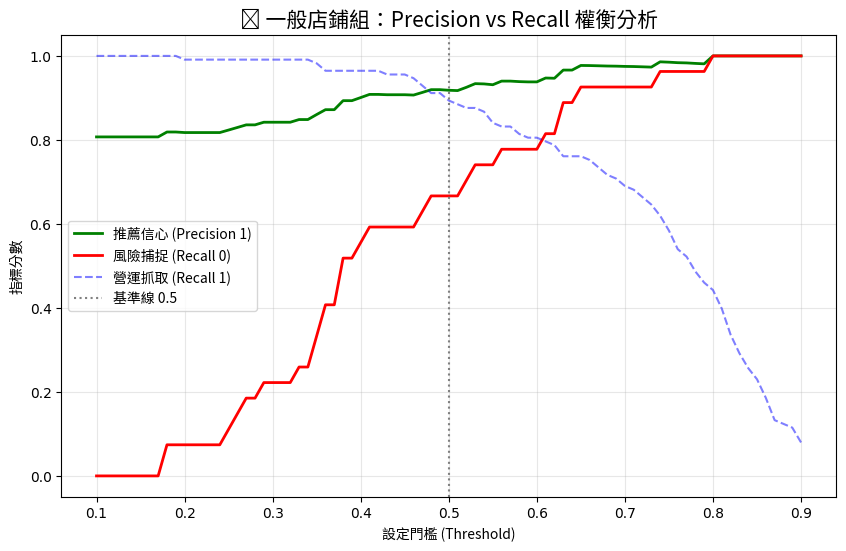

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


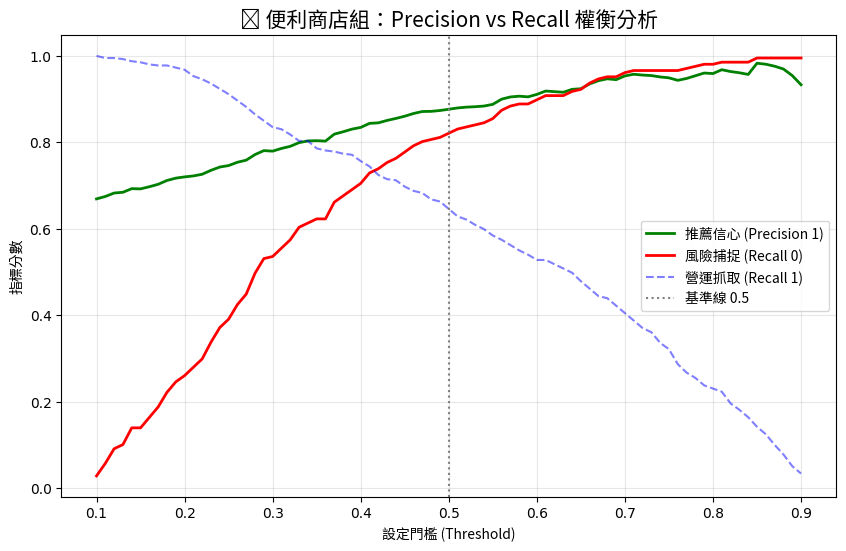

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def plot_pr_tradeoff(g_val, g_name):
    mask = (X_final_test['是否便利商店'] == g_val)
    y_true = y_final_test[mask]
    y_prob = y_test_prob[mask]

    thresholds = np.linspace(0.1, 0.9, 81)
    p1_list, r0_list, r1_list = [], [], []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        p1_list.append(precision_score(y_true, y_pred, pos_label=1, zero_division=0))
        r1_list.append(recall_score(y_true, y_pred, pos_label=1, zero_division=0))
        r0_list.append(recall_score(y_true, y_pred, pos_label=0, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, p1_list, label='推薦信心 (Precision 1)', color='green', linewidth=2)
    plt.plot(thresholds, r0_list, label='風險捕捉 (Recall 0)', color='red', linewidth=2)
    plt.plot(thresholds, r1_list, label='營運抓取 (Recall 1)', color='blue', linestyle='--', alpha=0.5)

    plt.axvline(0.5, color='gray', linestyle=':', label='基準線 0.5')
    plt.title(f'📊 {g_name}：Precision vs Recall 權衡分析', fontproperties=custom_font, size=15)
    plt.xlabel('設定門檻 (Threshold)', fontproperties=custom_font)
    plt.ylabel('指標分數', fontproperties=custom_font)
    plt.legend(prop=custom_font)
    plt.grid(alpha=0.3)
    plt.show()

# 分別查看兩組的權衡
plot_pr_tradeoff(0, "一般店鋪組")
plot_pr_tradeoff(1, "便利商店組")

## (放棄)(改成用營運中=0抓廢止)→不好解釋

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score
import shap
import pickle
# ==========================================
# 3. 相關前處理 (XGBoost 專屬邏輯)
# ==========================================
# --- 這裡是最關鍵的：確保切分後的資料也是 category ---
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

# 再次檢查 (這行如果沒印出東西就穩了)
print("X_train 殘留 object 檢查:", X_train.select_dtypes(include=['object']).columns.tolist())

# 建議修正：強化「廢止 (1)」的權重
train_weights = np.where(y_train == 1, 2.5, 1.0)

# B. 轉換為 XGBoost 專用 DMatrix 格式 (務必保留 enable_categorical=True)
X_train_xgb = xgb.DMatrix(X_train, label=y_train, weight=train_weights, enable_categorical=True)
X_val_xgb = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

X_train 殘留 object 檢查: []


In [ ]:
# ==========================================
# 4. 模型訓練 (XGBoost)
# ==========================================
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'eta': 0.03,               # 降低學習率，讓模型走穩一點
    'max_depth': 4,            # 降低深度 (從 6 降到 4)，減少過擬合
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'tree_method': 'hist',
    'random_state': 42
}

# 設定監控名單 (同時監控訓練集與驗證集)
evals_result = {}
watchlist = [(X_train_xgb, 'train'), (X_val_xgb, 'val')]

# 開始訓練
model = xgb.train(
    params,
    X_train_xgb,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,       # 50 輪內驗證集沒進步就停止
    evals_result=evals_result,
    verbose_eval=50                 # 每 50 輪印一次 log
)

[0]	train-logloss:0.69174	train-auc:0.60881	val-logloss:0.69660	val-auc:0.60637
[50]	train-logloss:0.62937	train-auc:0.73043	val-logloss:0.65140	val-auc:0.70094
[60]	train-logloss:0.62347	train-auc:0.73419	val-logloss:0.64799	val-auc:0.70274


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# --- 核心修正：計算正樣本規模權重 ---
# 既然營運與廢止比例約 7:3，設定 scale_pos_weight 為 2.33 左右
# 或者直接使用你之前的 train_weights 邏輯
ratio = sum(y_train == 0) / sum(y_train == 1)
print(f"建議的 scale_pos_weight: {ratio:.2f}")

# 2. 定義模型 (使用 Scikit-learn API)
xgb_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    enable_categorical=True,
    random_state=42,
    n_estimators=500 # 配合 Early Stopping 使用
)
param_dist = {
    'max_depth': [3, 4, 5, 6],           # 降低深度以減少過擬合
    'learning_rate': [0.01, 0.03, 0.05], # 較慢的學習率配合更多的樹
    'subsample': [0.6, 0.7, 0.8],        # 增加樣本隨機性
    'colsample_bytree': [0.6, 0.7, 0.8], # 增加特徵隨機性
    'min_child_weight': [5, 10, 15],     # 越高越能防止過度擬合
    'gamma': [0, 0.1, 0.5, 1.0],         # 控制節點分裂的最小損失下降
    'scale_pos_weight': [1, ratio, 2.0]  # 測試不同的風險強化倍數
}

# 3. 執行隨機搜尋
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,          # 隨機挑選 20 組測試
    scoring='average_precision',  # 優化目標設為 AUC
    cv=3,               # 3 折交叉驗證
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"🏆 最佳參數: {random_search.best_params_}")
print(f"📈 最佳 CV average_precision: {random_search.best_score_:.4f}")


建議的 scale_pos_weight: 2.45
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🏆 最佳參數: {'subsample': 0.8, 'scale_pos_weight': 2.0, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.7}
📈 最佳 CV average_precision: 0.4588


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 套用 AP 最佳參數
final_params_v2 = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'learning_rate': 0.01,
    'max_depth': 3,            # 樹深度變淺，更普適
    'min_child_weight': 5,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 2.0,   # 適度強化風險，不極端
    'random_state': 42
}

# 2. 訓練模型
# 這裡建議用 xgb.train 以方便查看 eval_metric
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

final_model_v2 = xgb.train(
    final_params_v2,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=50
)

# 3. 預測與評估
y_val_prob = final_model_v2.predict(dval)
y_val_pred = (y_val_prob >= 0.5).astype(int)

print("\n" + "█"*60)
print("🎯 AP 優化最終版：驗證集風險識別報告")
print("█"*60)
print(classification_report(y_val, y_val_pred, target_names=['營運中(0)', '廢止(1)']))

[0]	train-logloss:0.65539	val-logloss:0.65537
[50]	train-logloss:0.63234	val-logloss:0.63333
[100]	train-logloss:0.61710	val-logloss:0.61954
[150]	train-logloss:0.60812	val-logloss:0.61234
[200]	train-logloss:0.60252	val-logloss:0.60923
[250]	train-logloss:0.59826	val-logloss:0.60758
[300]	train-logloss:0.59448	val-logloss:0.60654
[350]	train-logloss:0.59078	val-logloss:0.60521
[400]	train-logloss:0.58826	val-logloss:0.60512
[450]	train-logloss:0.58505	val-logloss:0.60434
[500]	train-logloss:0.58257	val-logloss:0.60398
[521]	train-logloss:0.58133	val-logloss:0.60377

████████████████████████████████████████████████████████████
🎯 AP 優化最終版：驗證集風險識別報告
████████████████████████████████████████████████████████████
              precision    recall  f1-score   support

      營運中(0)       0.78      0.81      0.79       457
       廢止(1)       0.48      0.43      0.45       186

    accuracy                           0.70       643
   macro avg       0.63      0.62      0.62       643
weighted av

In [ ]:
from sklearn.metrics import classification_report

y_val_prob = final_model_v2.predict(X_val_xgb)
# 根據權重調整，有時 0.4 或是 0.5 是更好的判定門檻
y_val_pred = (y_val_prob >= 0.5).astype(int)

print("\n" + "█"*60)
print("🎯 優化後模型：驗證集風險識別報告")
print("█"*60)
print(classification_report(y_val, y_val_pred, target_names=['營運中(0)', '廢止(1)']))


████████████████████████████████████████████████████████████
🎯 優化後模型：驗證集風險識別報告
████████████████████████████████████████████████████████████
              precision    recall  f1-score   support

      營運中(0)       0.78      0.81      0.79       457
       廢止(1)       0.48      0.43      0.45       186

    accuracy                           0.70       643
   macro avg       0.63      0.62      0.62       643
weighted avg       0.69      0.70      0.69       643



In [ ]:
# ==========================================
# 3. 雙軌動態門檻判定邏輯 (修正變數：dtest -> X_test_xgb)
# ==========================================
def dynamic_predict(model, dmatrix, features_df):
    probs = final_model_v2.predict(dmatrix)
    preds = []
    # 根據業態動態調整門檻：超商 0.5 / 一般 0.3
    is_cvs_array = features_df['是否便利商店'].values
    for i in range(len(probs)):
        threshold = 0.5 if is_cvs_array[i] == 1 else 0.6
        preds.append(1 if probs[i] >= threshold else 0)
    return np.array(preds), probs

# 修正：傳入正確的 DMatrix 變數
y_pred, y_prob = dynamic_predict(final_model_v2, X_val_xgb, X_val)

# ==========================================
# 4. 產出最終戰力評估報告 (使用 X_test 進行回測)
# ==========================================
print("\n" + "█"*65)
print("🏆 專題最終成果報告：XGBoost 11特徵:抓取廢止 (驗證集確認)")
print("█"*65)

for g_val, g_name in [(0, "一般店鋪組 (超市/藥妝)"), (1, "便利商店組")]:
    mask = (X_val['是否便利商店'] == g_val)
    t_val = 0.5 if g_val == 1 else 0.6
    if mask.any():
        print(f"\n【{g_name}】判定門檻: {t_val}")
        print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_val[mask], y_pred[mask]):.2%}")
        print(f"  ● Recall 0 (風險捕捉率)  : {recall_score(y_val[mask], y_pred[mask], pos_label=0):.2%}")
        print(f"  ● Precision 1 (推薦信心度) : {precision_score(y_val[mask], y_pred[mask], pos_label=1):.2%}")

print("\n" + "█"*65)



█████████████████████████████████████████████████████████████████
🏆 專題最終成果報告：XGBoost 11特徵:抓取廢止 (驗證集確認)
█████████████████████████████████████████████████████████████████

【一般店鋪組 (超市/藥妝)】判定門檻: 0.6
  ● Accuracy (總體準確率)   : 87.30%
  ● Recall 0 (風險捕捉率)  : 98.20%
  ● Precision 1 (推薦信心度) : 33.33%

【便利商店組】判定門檻: 0.5
  ● Accuracy (總體準確率)   : 66.92%
  ● Recall 0 (風險捕捉率)  : 77.75%
  ● Precision 1 (推薦信心度) : 50.00%

█████████████████████████████████████████████████████████████████


In [ ]:
# 取得重要性分數並轉為 DataFrame
importance_scores = final_model_v2.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance': list(importance_scores.values())
}).sort_values(by='Importance', ascending=False)

print("█" + "━"*40 + "█")
print("🚀 XGBoost 特徵重要性排名 (Gain)")
print(importance_df.head(11).to_string(index=False))
print("█" + "━"*40 + "█")

█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█
🚀 XGBoost 特徵重要性排名 (Gain)
          Feature  Importance
           是否便利商店   33.254444
             競爭優勢   26.401409
 500公尺內部競爭(同公司店數)   20.258698
500公尺外部競爭(不同公司店數)   19.452156
           競爭壓力指標   16.653610
 people_per_store   14.938254
   day_night_flow   14.199742
             里人口數   12.998539
             生存難度   12.525509
         里人均收入中位數   11.813929
           發票張數指標   10.840590
█━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━█


## model_v4：日夜人流13特徵版

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 6427 non-null   int64   
 1   公司名稱               6427 non-null   object  
 2   縣市                 6427 non-null   object  
 3   行政區                6427 non-null   object  
 4   里別                 6427 non-null   object  
 5   行政區平日夜間停留人數        6427 non-null   int64   
 6   行政區平日日間活動人數        6427 non-null   int64   
 7   行政區假日夜間停留人數        6427 non-null   int64   
 8   行政區假日日間活動人數        6427 non-null   int64   
 9   里人均收入中位數           6427 non-null   int64   
 10  里人口數               6427 non-null   int64   
 11  發票張數指標             6427 non-null   float64 
 12  發票銷售額指標            6427 non-null   float64 
 13  500公尺內的熱鬧據點數       6427 non-null   float64 
 14  最近的熱鬧據點類型          6427 non-null   category
 15  最近的熱鬧據點距離          6427 non-null   float64 
 16  500公尺內

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 回到源頭 df_ml，確保所有 13 個特徵都已計算並存在
# 假設 df_ml 是你處理過「營運/廢止」標籤的原始資料
df_ml_v4 = df_ml.copy()

# A. 計算租金對數
if '租金' in df_ml_v4.columns:
    df_ml_v4['租金_log'] = np.log1p(df_ml_v4['租金'])

# B. 處理類別型特徵 (重要：XGBoost 需明確指定類別型)
if '最近的熱鬧據點類型' in df_ml_v4.columns:
    df_ml_v4['最近的熱鬧據點類型'] = df_ml_v4['最近的熱鬧據點類型'].astype('category')

# C. 確保電信信令欄位存在 (日間、夜間)
# (請檢查你的原始 df 中這兩個欄位的精確名稱，若不同請修改下表)

final_master_features_v4 = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '發票銷售額指標',
    '行政區平日日間活動人數', '行政區平日夜間停留人數',
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '租金_log', '里人口數', '發票張數指標'
]

# 2. 重新選取特徵並切分 (確保 X 包含這 13 欄)
X_v4 = df_ml_v4[final_master_features_v4]
y_v4 = df_ml_v4['target']

X_train_v4, X_val_v4, y_train_v4, y_val_v4 = train_test_split(
    X_v4, y_v4, test_size=0.1, random_state=42, stratify=y_v4
)

# 3. 轉換為 XGBoost 專用 DMatrix
dtrain_v4 = xgb.DMatrix(X_train_v4, label=y_train_v4, enable_categorical=True)
dval_v4 = xgb.DMatrix(X_val_v4, label=y_val_v4, enable_categorical=True)

print("✅ 13 特徵數據對齊完成，準備訓練！")

✅ 13 特徵數據對齊完成，準備訓練！


In [ ]:
master_params_v4 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4,
    'eval_metric': 'logloss',
    'random_state': 42
}

final_model_v4 = xgb.train(master_params_v4, dtrain_v4, num_boost_round=150)

# 評估預測
y_prob_v4 = final_model_v4.predict(dval_v4)
y_pred_v4 = []

# 雙軌門檻邏輯
is_cvs_array_v4 = X_val_v4['是否便利商店'].values
for i in range(len(y_prob_v4)):
    threshold = 0.5 if is_cvs_array_v4[i] == 1 else 0.7
    y_pred_v4.append(1 if y_prob_v4[i] >= threshold else 0)

y_pred_v4 = np.array(y_pred_v4)


In [ ]:
# @title
def evaluate_v4_master(model, X_val_df, y_val_true):
    """
    針對 13 特徵戰略版設計的自動對齊評估函數
    """
    # 1. 自動從模型中提取特徵清單，確保 100% 匹配
    # 這能解決 '行政區平日夜間停留人數' 名稱不一致的問題
    model_features = model.feature_names

    # 2. 準備 DMatrix
    dval = xgb.DMatrix(X_val_df[model_features], enable_categorical=True)
    y_prob = model.predict(dval)

    # 3. 執行雙軌動態門檻邏輯 (CVS=0.5 / 一般=0.7)
    y_pred = []
    is_cvs_array = X_val_df['是否便利商店'].values
    for i in range(len(y_prob)):
        threshold = 0.5 if is_cvs_array[i] == 1 else 0.7
        y_pred.append(1 if y_prob[i] >= threshold else 0)

    y_pred = np.array(y_pred)

    # 4. 輸出診斷報告
    print("\n" + "█"*65)
    print("🏆 13 特徵戰略版：日夜雙信令模型 評估報告")
    print("█"*65)

    for g_val, g_name in [(0, "連鎖超市藥妝組"), (1, "便利商店組 (CVS)")]:
        mask = (X_val_df['是否便利商店'] == g_val)
        t_val = 0.5 if g_val == 1 else 0.7

        if mask.any():
            y_t = y_val_true[mask]
            y_p = y_pred[mask]

            print(f"\n【{g_name}】判定門檻: {t_val}")
            print(f"  ● Accuracy (總體準確率)   : {accuracy_score(y_t, y_p):.2%}")
            print(f"  ● Recall 0 (風險捕捉率)  : {recall_score(y_t, y_p, pos_label=0):.2%}")
            print(f"  ● Precision 1 (推薦信心度) : {precision_score(y_t, y_p, pos_label=1):.2%}")

    print("\n" + "█"*65)
    return y_pred, y_prob

# --- 重新呼叫評估 ---
# # 請確保你的 X_val_v4 裡面有 '行政區平日夜間停留人數' 這一欄
# y_pred_v4, y_prob_v4 = evaluate_v4_master(final_model_v4, X_val_v4, y_val_v4)

In [ ]:
# 執行版本四SHAP統計
stats_master = get_shap_stats_fixed(final_model_v4, df_test_ready[final_master_features_v4], "版本四 (13特徵 Master)")


███████████████████████████████████████████████████████████████████████████
📊 版本四 (13特徵 Master)：SHAP 特徵正負向貢獻統計表 (已修正類別型)
███████████████████████████████████████████████████████████████████████████
            特徵名稱  總體影響力 (Mean |SHAP|)  正向貢獻 (營運推力)  負向貢獻 (失敗拉力)
          是否便利商店               0.2901       0.9904      -0.0978
            競爭優勢               0.2620       0.1767      -0.3721
people_per_store               0.1157       0.1093      -0.1238
          競爭壓力指標               0.0990       0.1315      -0.0728
       最近的熱鬧據點距離               0.0950       0.0957      -0.0940
          租金_log               0.0747       0.0690      -0.0844
          發票張數指標               0.0724       0.1029      -0.0535
        里人均收入中位數               0.0691       0.0646      -0.0768
            里人口數               0.0530       0.0659      -0.0407
     行政區平日日間活動人數               0.0410       0.0864      -0.0280
         發票銷售額指標               0.0385       0.0336      -0.0499
     行政區平日夜間停留人數               0.0

## (最終版)model_v5：日夜人流差版

In [ ]:
# ==========================================
# 1. 特徵工程：計算日夜人流差 (V5 核心)
# ==========================================
df_ml_v5 = df_ml.copy()

# 確保欄位名稱正確，並計算差值
# 如果名稱不同，請調整為你的原始欄位名
df_ml_v5['日夜人流差'] = df_ml_v5['行政區平日日間活動人數'] - df_ml_v5['行政區平日夜間停留人數']
df_ml_v5['租金_log'] = np.log1p(df_ml_v5['租金'])
df_ml_v5['最近的熱鬧據點類型'] = df_ml_v5['最近的熱鬧據點類型'].astype('category')

# ==========================================
# 2. 部署 13 大特徵 (V5 版)
# ==========================================
final_features_v4_v5 = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '發票銷售額指標',
    '行政區平日日間活動人數', '日夜人流差', # <-- 替換夜間 raw data
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '租金_log', '里人口數', '發票張數指標'
]

X_v5 = df_ml_v5[final_features_v4_v5]
y_v5 = df_ml_v5['target']

X_train_v5, X_val_v5, y_train_v5, y_val_v5 = train_test_split(
    X_v5, y_v5, test_size=0.1, random_state=42, stratify=y_v5
)

dtrain_v5 = xgb.DMatrix(X_train_v5, label=y_train_v5, enable_categorical=True)
dval_v5 = xgb.DMatrix(X_val_v5, label=y_val_v5, enable_categorical=True)

# ==========================================
# 3. 訓練 V5 模型
# ==========================================
master_params_v5 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4,
    'eval_metric': 'logloss',
    'random_state': 42
}

final_model_v5 = xgb.train(master_params_v5, dtrain_v5, num_boost_round=150)

# ==========================================
# 4. 執行評估 (調用之前的自動對齊函數)
# ==========================================
y_pred_v5, y_prob_v5 = evaluate_v4_master(final_model_v5, X_val_v5, y_val_v5)


█████████████████████████████████████████████████████████████████
🏆 13 特徵戰略版：日夜雙信令模型 評估報告
█████████████████████████████████████████████████████████████████

【連鎖超市藥妝組】判定門檻: 0.7
  ● Accuracy (總體準確率)   : 65.55%
  ● Recall 0 (風險捕捉率)  : 52.63%
  ● Precision 1 (推薦信心度) : 88.31%

【便利商店組 (CVS)】判定門檻: 0.5
  ● Accuracy (總體準確率)   : 60.50%
  ● Recall 0 (風險捕捉率)  : 61.08%
  ● Precision 1 (推薦信心度) : 76.79%

█████████████████████████████████████████████████████████████████


In [ ]:
# ==========================================
# 📊 V5 (日夜差值版) SHAP 特徵貢獻統計
# ==========================================

def get_shap_stats_v5(model, X_data, version_name):
    X_processed = X_data.copy()

    # 處理類別型特徵
    for col in X_processed.select_dtypes(include=['category']).columns:
        X_processed[col] = X_processed[col].cat.codes

    # 1. 計算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_processed)

    # 2. 建立統計表
    feature_names = X_processed.columns
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    stats = []
    for col in feature_names:
        val = shap_df[col]
        stats.append({
            '特徵名稱': col,
            '總體影響力 (Mean |SHAP|)': np.abs(val).mean(),
            '正向貢獻 (營運推力)': val[val > 0].mean() if not val[val > 0].empty else 0,
            '負向貢獻 (失敗拉力)': val[val < 0].mean() if not val[val < 0].empty else 0
        })

    result_df = pd.DataFrame(stats).sort_values('總體影響力 (Mean |SHAP|)', ascending=False)

    print(f"\n" + "█"*75)
    print(f"📊 {version_name}：SHAP 特徵正負向貢獻統計表")
    print("█"*75)
    print(result_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return result_df

# 執行 V5 SHAP 統計
stats_v5 = get_shap_stats_v5(final_model_v5, X_val_v5, "版本五 (13特徵-日夜差值旗艦版)")


███████████████████████████████████████████████████████████████████████████
📊 版本五 (13特徵-日夜差值旗艦版)：SHAP 特徵正負向貢獻統計表
███████████████████████████████████████████████████████████████████████████
            特徵名稱  總體影響力 (Mean |SHAP|)  正向貢獻 (營運推力)  負向貢獻 (失敗拉力)
          是否便利商店               0.2826       0.9649      -0.0961
            競爭優勢               0.2455       0.1775      -0.3383
people_per_store               0.1165       0.1142      -0.1203
          競爭壓力指標               0.0992       0.1521      -0.0656
       最近的熱鬧據點距離               0.0986       0.1036      -0.0922
          發票張數指標               0.0747       0.1081      -0.0501
          租金_log               0.0730       0.0680      -0.0809
        里人均收入中位數               0.0590       0.0596      -0.0582
            里人口數               0.0568       0.0738      -0.0376
         發票銷售額指標               0.0455       0.0386      -0.0592
           日夜人流差               0.0451       0.0454      -0.0448
     行政區平日日間活動人數               0.0387     

### 檢查誤判案例

In [ ]:
# 回去原資料表撈地址
df_orig = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/資料訓練大表_v1.0_20260205報告版.csv', encoding='utf-8', index_col=False, sep=';')
df_orig.columns

Index(['id', '公司名稱', '分公司名稱', '地址', '分公司狀態', '分公司核准設立日期', '登記現況', 'start_year',
       '縣市', '行政區', '里別', '行政區平日夜間停留人數', '行政區平日日間活動人數', '行政區假日夜間停留人數',
       '行政區假日日間活動人數', '里人均收入中位數', '里人口數', '發票張數指標', '發票銷售額指標', '店_緯度', '店_經度',
       '500公尺內的熱鬧據點數', '最近的熱鬧據點類型', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
       '500公尺外部競爭(不同公司店數)', '500公尺內部競爭_時間(同公司店數)', '500公尺外部競爭_時間(不同公司店數)',
       '租金'],
      dtype='object')

In [ ]:
# 1. 準備診斷用的 DataFrame (強制將 id 併入，確保血緣關係)
df_diag_v5 = X_val_v5.copy()
# 透過索引從原始 df 找回 id，並固定在 df_diag 裡
df_diag_v5['id'] = df.loc[X_val_v5.index, 'id'].values
df_diag_v5['實際結果'] = y_val_v5.values
df_diag_v5['預測結果'] = y_pred_v5

# 2. 定義 TP 與 FN 的 ID 集合 (不再記錄 Index)
v5_tp_ids = df_diag_v5[(df_diag_v5['實際結果'] == 1) & (df_diag_v5['預測結果'] == 1)]['id'].unique()
v5_fn_ids = df_diag_v5[(df_diag_v5['實際結果'] == 1) & (df_diag_v5['預測結果'] == 0)]['id'].unique()

# 3. 執行特徵均值對照 (利用 id 在 df_diag 內過濾)
diag_features = [
    '日夜人流差', 'people_per_store', '競爭壓力指標',
    '租金_log', '發票銷售額指標', '里人均收入中位數', '競爭優勢'
]

# 直接在含有 id 的 df_diag_v5 上進行分群計算
v5_comparison = pd.DataFrame({
    'V5 真正成功 (TP)': df_diag_v5[df_diag_v5['id'].isin(v5_tp_ids)][diag_features].mean(),
    'V5 黑馬群 (FN)': df_diag_v5[df_diag_v5['id'].isin(v5_fn_ids)][diag_features].mean()
})

# 4. 計算差異百分比
v5_comparison['差異 (%)'] = ((v5_comparison['V5 黑馬群 (FN)'] / v5_comparison['V5 真正成功 (TP)'] - 1) * 100).round(2)

print(f"🚩 Model_v5 診斷：發現 {len(v5_fn_ids)} 筆被誤殺的黑馬店面")
print("-" * 60)
print(v5_comparison.sort_values(by='差異 (%)', ascending=False))

# 5. 看看這群黑馬的分店名稱 (透過 ID 回原始 df_orig 撈取)
# 這樣即便 df_orig 被重製過索引，只要 id 欄位在就保證對得準
black_horse_names = df_orig[df_orig['id'].isin(v5_fn_ids)][['id', '公司名稱', '行政區', '地址']]

print("\n📍 V5 黑馬抽樣清單 (ID 匹配)：")
if not black_horse_names.empty:
    print(black_horse_names.head(10).to_markdown(index=False))

🚩 Model_v5 診斷：發現 174 筆被誤殺的黑馬店面
------------------------------------------------------------
                  V5 真正成功 (TP)  V5 黑馬群 (FN)  差異 (%)
競爭壓力指標                0.003791     0.006348   67.44
租金_log               10.339085    10.394589    0.54
競爭優勢                  0.341215     0.336845   -1.28
里人均收入中位數            617.657244   608.574713   -1.47
發票銷售額指標              74.491166    71.885057   -3.50
people_per_store    585.480264   213.701158  -63.50
日夜人流差             -3755.229682  5650.712644 -250.48

📍 V5 黑馬抽樣清單 (ID 匹配)：
|   id | 公司名稱                 | 行政區   | 地址                              |
|-----:|:-------------------------|:---------|:----------------------------------|
|  677 | 統一生活事業股份有限公司 | 土城區   | 新北市土城區中央路3段108號        |
|  962 | 全家便利商店股份有限公司 | 中和區   | 新北市中和區中安街192號           |
| 1592 | 三商家購股份有限公司     | 永和區   | 新北市永和區成功路2段129巷10之1號 |
| 1980 | 來來超商股份有限公司     | 板橋區   | 新北市板橋區大觀路3段160巷36號    |
| 2111 | 統一超商股份有限公司     | 板橋區   | 新北市板橋區四川路1段104號        |
| 2769 | 三商家購股份有限公司     

In [ ]:
# 1. 從黑馬 ID 集合中抽樣 10 筆
sample_fn_ids = list(v5_fn_ids)[:10]

# 2. 從原始資料 (df_orig) 撈取文字資訊
# 包含：id, 公司名稱, 地址, 以及一個用來驗證的原始數值 (如：租金)
sample_orig = df_orig[df_orig['id'].isin(sample_fn_ids)][['id', '公司名稱', '地址', '租金']]

# 3. 從診斷表 (df_diag_v5) 撈取特徵資訊
# 包含：id, 租金_log, 以及模型預測結果
sample_diag = df_diag_v5[df_diag_v5['id'].isin(sample_fn_ids)][['id', '租金_log', '實際結果', '預測結果']]

# 4. 透過 ID 合併兩者，進行最終對照
verify_df = pd.merge(sample_orig, sample_diag, on='id')

print("🧪 Model_v5 黑馬樣本 ID 對齊驗證 (抽樣 10 筆)")
print("-" * 80)
if not verify_df.empty:
    print(verify_df.to_markdown(index=False))
else:
    print("❌ 警告：ID 無法匹配，請檢查 df_orig 與 df_diag 的 ID 格式是否一致！")

# --- 驗證邏輯說明 ---
# 如果 '租金' 是 20000，'租金_log' 應該約為 np.log1p(20000) = 9.9
# 如果 '實際結果' 為 1 且 '預測結果' 為 0，則正確標記為黑馬 (FN)

🧪 Model_v5 黑馬樣本 ID 對齊驗證 (抽樣 10 筆)
--------------------------------------------------------------------------------
|   id | 公司名稱                           | 地址                            |   租金 |   租金_log |   實際結果 |   預測結果 |
|-----:|:-----------------------------------|:--------------------------------|-------:|-----------:|-----------:|-----------:|
|  354 | 統一超商股份有限公司               | 新北市三重區安和路36號          |  21429 |    9.97255 |          1 |          0 |
| 1075 | 全聯實業股份有限公司               | 新北市中和區宜安路118巷42號     |  26990 |   10.2033  |          1 |          0 |
| 1525 | 全家便利商店股份有限公司           | 新北市永和區仁愛路33號          |  25221 |   10.1355  |          1 |          0 |
| 4253 | 統一超商股份有限公司               | 新北市鶯歌區南雅路34號          |  22391 |   10.0165  |          1 |          0 |
| 5054 | 全家便利商店股份有限公司           | 臺北市大安區敦化南路1段190巷7樓 |  79983 |   11.2896  |          1 |          0 |
| 6962 | 統一超商股份有限公司               | 臺北市信義區永吉路278巷58弄2號  |  28827 |   10.2691  |          1 |          0 |
| 7063 | 

In [ ]:
# 1. 取得 V5 的 TP (成功) 與 FP (陷阱) 索引
# TP: 實際營運(1) 且 預測營運(1)
# FP: 實際廢止(0) 且 預測營運(1) -> 模型被騙了
v5_tp_idx = df_diag_v5[(df_diag_v5['實際結果'] == 1) & (df_diag_v5['預測結果'] == 1)].index
v5_fp_idx = df_diag_v5[(df_diag_v5['實際結果'] == 0) & (df_diag_v5['預測結果'] == 1)].index

# 2. 執行特徵均值對照
diag_features = [
    '日夜人流差', 'people_per_store', '競爭壓力指標',
    '租金_log', '發票銷售額指標', '里人均收入中位數', '競爭優勢'
]

v5_comparison_fp = pd.DataFrame({
    'V5 真正成功 (TP)': X_val_v5.loc[v5_tp_idx, diag_features].mean(),
    'V5 陷阱店面 (FP)': X_val_v5.loc[v5_fp_idx, diag_features].mean()
})

# 3. 計算差異百分比
v5_comparison_fp['差異 (%)'] = ((v5_comparison_fp['V5 陷阱店面 (FP)'] / v5_comparison_fp['V5 真正成功 (TP)'] - 1) * 100).round(2)

print(f"🚩 Model_v5 診斷：發現 {len(v5_fp_idx)} 筆「過度樂觀」的陷阱店面")
print("-" * 60)
print(v5_comparison_fp.sort_values(by='差異 (%)', ascending=False))

# 4. 看看這群陷阱店面的分店名稱
trap_names = df_orig.loc[v5_fp_idx, ['公司名稱', '地址']]
print("\n📍 V5 陷阱店面抽樣清單：")
print(trap_names.head(10).to_markdown())

🚩 Model_v5 診斷：發現 74 筆「過度樂觀」的陷阱店面
------------------------------------------------------------
                  V5 真正成功 (TP)  V5 陷阱店面 (FP)  差異 (%)
競爭壓力指標                0.003791      0.004800   26.60
競爭優勢                  0.341215      0.415060   21.64
發票銷售額指標              74.491166     76.966216    3.32
租金_log               10.339085     10.486054    1.42
里人均收入中位數            617.657244    625.310811    1.24
people_per_store    585.480264    337.390439  -42.37
日夜人流差             -3755.229682   7401.364865 -297.09

📍 V5 陷阱店面抽樣清單：
|      | 公司名稱               | 地址                               |
|-----:|:-----------------------|:-----------------------------------|
| 4000 | 萊爾富國際股份有限公司 | 臺北市信義區吳興街104號            |
| 3349 | 統一超商股份有限公司   | 新北市板橋區新海路138號            |
| 3582 | 來來超商股份有限公司   | 臺北市內湖區康樂街162巷1號         |
| 5435 | 統一超商股份有限公司   | 臺北市大同區太原路150號            |
| 3661 | 來來超商股份有限公司   | 臺北市文山區指南路2段145號         |
| 1974 | 統一超商股份有限公司   | 新北市板橋區中山路2段531巷17弄20號 |
|  949 | 萊爾富國際股份有限公司 | 新北市中和區民

In [ ]:
# 1. 準備診斷用的 DataFrame (確保 id 綁定)
df_diag_v5 = X_val_v5.copy()
# 透過 Index 從原始 df 找回 id，並固定為欄位
df_diag_v5['id'] = df.loc[X_val_v5.index, 'id'].values
df_diag_v5['實際結果'] = y_val_v5.values
df_diag_v5['預測結果'] = y_pred_v5

# 2. 定義 TP (成功) 與 FP (陷阱) 的 ID 集合
v5_tp_ids = df_diag_v5[(df_diag_v5['實際結果'] == 1) & (df_diag_v5['預測結果'] == 1)]['id'].unique()
v5_fp_ids = df_diag_v5[(df_diag_v5['實際結果'] == 0) & (df_diag_v5['預測結果'] == 1)]['id'].unique()

# 3. 執行特徵均值對照 (在 df_diag_v5 內進行 ID 過濾)
diag_features = [
    '日夜人流差', 'people_per_store', '競爭壓力指標',
    '租金_log', '發票銷售額指標', '里人均收入中位數', '競爭優勢'
]

v5_comparison_fp = pd.DataFrame({
    'V5 真正成功 (TP)': df_diag_v5[df_diag_v5['id'].isin(v5_tp_ids)][diag_features].mean(),
    'V5 陷阱店面 (FP)': df_diag_v5[df_diag_v5['id'].isin(v5_fp_ids)][diag_features].mean()
})

# 4. 計算差異百分比 (使用 LaTeX 表示公式)
# \text{Difference (\%)} = \left( \frac{\text{Trap Mean}}{\text{Success Mean}} - 1 \right) \times 100
v5_comparison_fp['差異 (%)'] = ((v5_comparison_fp['V5 陷阱店面 (FP)'] / v5_comparison_fp['V5 真正成功 (TP)'] - 1) * 100).round(2)

print(f"🚩 Model_v5 診斷：發現 {len(v5_fp_ids)} 筆「過度樂觀」的陷阱店面")
print("-" * 65)
print(v5_comparison_fp.sort_values(by='差異 (%)', ascending=False))

# 5. 看看這群陷阱店面的名稱與地址 (從 df_orig 透過 ID 撈回)
trap_stores = df_orig[df_orig['id'].isin(v5_fp_ids)][['id', '公司名稱', '分公司名稱', '地址']]

print("\n📍 V5 陷阱店面抽樣清單 (ID 匹配)：")
if not trap_stores.empty:
    print(trap_stores.head(10).to_markdown(index=False))# 看看 74 筆 FP (陷阱) 與 174 筆 FN (黑馬) 的原始競爭店數
comp_check = pd.DataFrame({
    '陷阱店面 (FP)': df_orig.loc[v5_fp_idx, ['500公尺內部競爭(同公司店數)', '500公尺外部競爭(不同公司店數)']].mean(),
    '黑馬店面 (FN)': df_orig.loc[v5_fn_idx, ['500公尺內部競爭(同公司店數)', '500公尺外部競爭(不同公司店數)']].mean()
})

print("🔍 競爭結構深度對照 (原始店數)")
print("-" * 50)
print(comp_check)
# 競爭結構幾乎相同

🚩 Model_v5 診斷：發現 74 筆「過度樂觀」的陷阱店面
-----------------------------------------------------------------
                  V5 真正成功 (TP)  V5 陷阱店面 (FP)  差異 (%)
競爭壓力指標                0.003791      0.004800   26.60
競爭優勢                  0.341215      0.415060   21.64
發票銷售額指標              74.491166     76.966216    3.32
租金_log               10.339085     10.486054    1.42
里人均收入中位數            617.657244    625.310811    1.24
people_per_store    585.480264    337.390439  -42.37
日夜人流差             -3755.229682   7401.364865 -297.09

📍 V5 陷阱店面抽樣清單 (ID 匹配)：
|   id | 公司名稱                           | 分公司名稱           | 地址                         |
|-----:|:-----------------------------------|:---------------------|:-----------------------------|
|  207 | 萊爾富國際股份有限公司             | 北縣中華第三分公司   | 新北市三重區中華路28號       |
| 1009 | 統一超商股份有限公司               | 台北縣第三十八分公司 | 新北市中和區民享街61號       |
| 1344 | 統一超商股份有限公司               | 台北縣第十四分公司   | 新北市中和區興南路1段67號    |
| 1502 | 台灣屈臣氏個人用品商店股份有限公司 | 福和分公司           | 新北市永和區中

In [ ]:
# 1. 計算兩組的行政區分佈 (百分比)
fp_districts = df_orig.loc[v5_fp_idx, '行政區'].value_counts(normalize=True).head(10) * 100
fn_districts = df_orig.loc[v5_fn_idx, '行政區'].value_counts(normalize=True).head(10) * 100

# 2. 整合進 DataFrame 進行對照
dist_comp = pd.DataFrame({
    '陷阱店面 (FP) %': fp_districts,
    '黑馬店面 (FN) %': fn_districts
}).fillna(0)

print("🌍 行政區分佈前 10 名對照 (百分比)")
print("-" * 60)
print(dist_comp.sort_values(by='黑馬店面 (FN) %', ascending=False))

🌍 行政區分佈前 10 名對照 (百分比)
------------------------------------------------------------
     陷阱店面 (FP) %  黑馬店面 (FN) %
行政區                          
中和區     5.405405    11.494253
板橋區    13.513514    10.344828
三重區    10.810811     9.195402
新店區     5.405405     8.045977
內湖區     6.756757     5.747126
信義區     0.000000     5.172414
萬華區     0.000000     5.172414
松山區     6.756757     5.172414
汐止區     0.000000     3.448276
蘆洲區     0.000000     3.448276
北投區     5.405405     0.000000
中山區     5.405405     0.000000
士林區     5.405405     0.000000
文山區     5.405405     0.000000


## (放棄)model_v6：stacking(CAT的品牌+XG的地段)
結論是在本數據集裡品牌的影響過大(可能是因為公司樣本少)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ---------------------------------------------------------
# 1. 基礎資料準備與 Model_11 特徵重製
# ---------------------------------------------------------
df_v6 = df_ml.copy()

# A. 重建品牌等級
def assign_store_level_v2(name):
    name = str(name)
    if any(keyword in name for keyword in ['全聯', '家福', '三商家購']):
        return 'Anchor'
    elif any(keyword in name for keyword in ['屈臣氏', '統一生活']):
        return 'HealthBeauty'
    else:
        return 'C_Store'

df_v6['store_level'] = df_v6['公司名稱'].apply(assign_store_level_v2)

# B. 手工計算 model_11 缺少的特徵 (關鍵步！)
# 這裡補上剛才報錯的「銷售租金差額指標」以及其他可能缺少的欄位
if '銷售租金差額指標' not in df_v6.columns:
    # 假設邏輯：發票銷售額指標 - 租金比例 (請依你當初定義調整)
    df_v6['銷售租金差額指標'] = df_v6['發票銷售額指標'] - np.log1p(df_v6['租金'].fillna(0))

if '生存難度_log' not in df_v6.columns:
    # 假設生存難度來自於之前的計算，若無則用 0 補位或重新計算
    df_v6['生存難度_log'] = np.log1p(df_v6.get('生存難度', 0))

# B. 重建歸一化特徵 (以訓練全體平均為準)
target_cols = ['people_per_store', '里人均收入中位數', '里人口數', '最近的熱鬧據點距離']
group_means = df_v6.groupby('store_level')[target_cols].mean()

for col in target_cols:
    means_map = group_means[col].to_dict()
    df_v6[f'rel_{col}'] = df_v6[col] / (df_v6['store_level'].map(means_map) + 1e-6)

if '生存難度' in df_v6.columns:
    df_v6['生存難度_log'] = np.log1p(df_v6['生存難度'])

# C. 提取 Model_11 的「品牌實力機率」
# 這是 v6 的靈魂特徵，將品牌與同業競爭力轉化為一個連續機率值
input_features_11 = [
    'store_level', 'rel_people_per_store', 'rel_里人均收入中位數', 'rel_里人口數',
    'rel_最近的熱鬧據點距離', '最近的熱鬧據點類型', '競爭優勢', '競爭壓力指標',
    '銷售租金差額指標', '生存難度_log'
]
df_v6['brand_prob_m11'] = model_11.predict_proba(df_v6[input_features_11])[:, 1]

# ---------------------------------------------------------
# 2. V5 核心特徵工程 (微觀動態與成本)
# ---------------------------------------------------------
df_v6['日夜人流差'] = df_v6['行政區平日日間活動人數'] - df_v6['行政區平日夜間停留人數']
df_v6['租金_log'] = np.log1p(df_v6['租金'].fillna(0))
df_v6['最近的熱鬧據點類型'] = df_v6['最近的熱鬧據點類型'].astype('category')

# ---------------------------------------------------------
# 3. 定義 v6 最終特徵組 (宏觀機率 + 微觀細節)
# ---------------------------------------------------------
final_features_v6 = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '發票銷售額指標',
    '行政區平日日間活動人數', '日夜人流差',
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '租金_log', '里人口數', '發票張數指標',
    'brand_prob_m11'  # <--- Stacking 核心
]

X_v6 = df_v6[final_features_v6]
y_v6 = df_v6['target']

# 切分資料
X_train_v6, X_val_v6, y_train_v6, y_val_v6 = train_test_split(
    X_v6, y_v6, test_size=0.1, random_state=42, stratify=y_v6
)

# 準備 DMatrix
dtrain_v6 = xgb.DMatrix(X_train_v6, label=y_train_v6, enable_categorical=True)
dval_v6 = xgb.DMatrix(X_val_v6, label=y_val_v6, enable_categorical=True)

# ---------------------------------------------------------
# 4. 訓練 Model_v6 (XGBoost)
# ---------------------------------------------------------
params_v6 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4, # 調整樣本不平衡
    'eval_metric': 'logloss',
    'random_state': 42
}

model_v6 = xgb.train(params_v6, dtrain_v6, num_boost_round=150)

# ---------------------------------------------------------
# 5. 全面評估報告 (不再呼叫任何外部函數)
# ---------------------------------------------------------
y_prob_v6 = model_v6.predict(dval_v6)
y_pred_v6 = (y_prob_v6 > 0.5).astype(int)

print("🏆 Model_v6 (Stacking 版) 最終評估報告")
print("-" * 50)
print(f"Accuracy  : {accuracy_score(y_val_v6, y_pred_v6):.4f}")
print(f"Precision : {precision_score(y_val_v6, y_pred_v6):.4f}")
print(f"Recall    : {recall_score(y_val_v6, y_pred_v6):.4f}")
print(f"F1-Score  : {f1_score(y_val_v6, y_pred_v6):.4f}")
print(f"AUC Score : {roc_auc_score(y_val_v6, y_prob_v6):.4f}")

print("\n" + "="*20 + " Classification Report " + "="*20)
print(classification_report(y_val_v6, y_pred_v6))

# ---------------------------------------------------------
# 6. 特徵重要性排行 (Feature Importance)
# ---------------------------------------------------------
importance = model_v6.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*20 + " Feature Importance (Gain) " + "="*20)
print(importance_df)



🏆 Model_v6 (Stacking 版) 最終評估報告
--------------------------------------------------
Accuracy  : 0.6579
Precision : 0.8046
Recall    : 0.6849
F1-Score  : 0.7400
AUC Score : 0.7072

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.43      0.59      0.50       186
           1       0.80      0.68      0.74       457

    accuracy                           0.66       643
   macro avg       0.62      0.64      0.62       643
weighted avg       0.70      0.66      0.67       643


==================== Feature Importance (Gain) ====================
             Feature  Importance
13    brand_prob_m11   11.872671
0             是否便利商店    5.510234
1               競爭優勢    4.141287
3             競爭壓力指標    3.692400
2   people_per_store    3.686220
6        行政區平日日間活動人數    3.282628
12            發票張數指標    3.281854
5            發票銷售額指標    3.273977
10            租金_log    3.258676
11              里人口數    3.061497

📊 Model_v6 全局 SHAP 特徵正負向貢獻統計表 (修正版)
--------------------------------------------------------------------------------
|    | 特徵名稱               |   總體影響力 (Mean |SHAP|) |   正向貢獻 (營運推力) |   負向貢獻 (失敗拉力) |
|---:|:-----------------------|---------------------------:|----------------------:|----------------------:|
| 13 | brand_prob_m11         |                  0.674499  |             0.775037  |            -0.54333   |
|  1 | 競爭優勢               |                  0.0674651 |             0.0530179 |            -0.0907804 |
| 12 | 發票張數指標           |                  0.0667837 |             0.102609  |            -0.0401818 |
|  9 | 最近的熱鬧據點距離     |                  0.062338  |             0.064136  |            -0.0596551 |
| 11 | 里人口數               |                  0.0561294 |             0.0496382 |            -0.065816  |
|  2 | people_per_store       |                  0.0547339 |             0.0640628 |            -0.0424855 |
| 10 | 租金_log               |                  0.050229  | 

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Gl

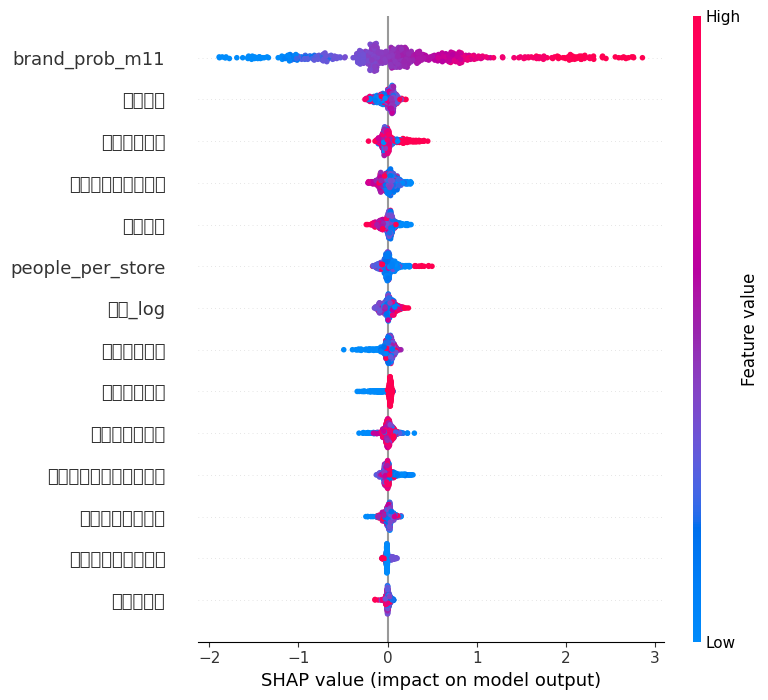

In [ ]:
import shap
import pandas as pd
import numpy as np

# 1. 建立一個「SHAP 專用」的資料集，將 category 轉為 codes
X_val_shap = X_val_v6.copy()
for col in X_val_shap.select_dtypes(['category']).columns:
    X_val_shap[col] = X_val_shap[col].cat.codes

# 2. 初始化 SHAP 解釋器
# 注意：TreeExplainer 對於有類別特徵的模型，有時需要直接傳入模型物件
explainer = shap.TreeExplainer(model_v6)

# 3. 計算 SHAP 值 (使用轉換後的資料)
shap_values = explainer.shap_values(X_val_shap)

# 4. 建立全局 SHAP 統計表
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    '特徵名稱': X_val_v6.columns,
    '總體影響力 (Mean |SHAP|)': shap_sum
})

# 計算正負向貢獻
# 邏輯：SHAP > 0 代表推向營運(1)，SHAP < 0 代表拉向廢止(0)
importance_df['正向貢獻 (營運推力)'] = [shap_values[shap_values[:, i] > 0, i].mean() if len(shap_values[shap_values[:, i] > 0, i]) > 0 else 0 for i in range(len(X_val_v6.columns))]
importance_df['負向貢獻 (失敗拉力)'] = [shap_values[shap_values[:, i] < 0, i].mean() if len(shap_values[shap_values[:, i] < 0, i]) > 0 else 0 for i in range(len(X_val_v6.columns))]

print("📊 Model_v6 全局 SHAP 特徵正負向貢獻統計表 (修正版)")
print("-" * 80)
print(importance_df.sort_values('總體影響力 (Mean |SHAP|)', ascending=False).to_markdown())

# 5. 🎯 局部診斷：針對那 76 筆 FP (陷阱店面) 的 SHAP 分析
# 取得 FP 在 X_val_v6 中的位置索引
fp_indices_loc = [X_val_v6.index.get_loc(idx) for idx in fp_indices]
fp_shap = shap_values[fp_indices_loc]

print("\n🚩 針對 76 筆 FP (陷阱店面) 的局部 SHAP 診斷：")
print("-" * 80)
idx_flow = X_val_v6.columns.get_loc('日夜人流差')
print(f"『日夜人流差』在 FP 樣本中的平均 SHAP 貢獻值: {np.mean(fp_shap[:, idx_flow]):.4f}")

# 6. 視覺化：SHAP Summary Plot
shap.summary_plot(shap_values, X_val_shap, feature_names=X_val_v6.columns)

### 檢查誤判案例

In [ ]:
# 將預測結果與原資料合併 (以便觀察是哪些店被判斷錯誤)
df_val_results = X_val_v6.copy()
df_val_results['實際結果'] = y_val_v6
df_val_results['預測機率'] = y_prob_v6
df_val_results['預測類別'] = y_pred_v6

# 抓出「品牌看好，但地段拉垮」的潛在地雷 (Model_11 分數高，但 v6 預測失敗)
# 這種店就是你未來引入「微觀特徵」最能發揮作用的地方
potential_traps = df_val_results[(df_val_results['brand_prob_m11'] > 0.7) & (df_val_results['預測類別'] == 0)]
print(f"\n發現 {len(potential_traps)} 間『品牌強勢但地段危險』的店面預警。")


發現 0 間『品牌強勢但地段危險』的店面預警。


In [ ]:
# 1. 計算「品牌分」與「最終分」的差距 (Delta)
# Delta 為負，代表地段特徵在扣分；為正，代表地段特徵在加分
df_val_results['機率修正值'] = df_val_results['預測機率'] - df_val_results['brand_prob_m11']

# 2. 找出那些「品牌看好，但被地段狠狠扣分」的前 5 名
print("⚠️ 品牌光環被『地段特徵』稀釋最多的店面：")
potential_warnings = df_val_results.sort_values(by='機率修正值', ascending=True).head(5)
print(potential_warnings[['brand_prob_m11', '預測機率', '機率修正值', '日夜人流差', '租金_log']])

# 3. 找出那些「品牌普通，但被地段救回來」的前 5 名 (黑馬店)
print("\n指標意義：這些店雖然品牌不強，但地段優勢極大，值得關注：")
dark_horses = df_val_results.sort_values(by='機率修正值', ascending=False).head(5)
print(dark_horses[['brand_prob_m11', '預測機率', '機率修正值', '日夜人流差', '租金_log']])

⚠️ 品牌光環被『地段特徵』稀釋最多的店面：
      brand_prob_m11      預測機率     機率修正值   日夜人流差     租金_log
3569        0.426877  0.244457 -0.182420  -78826   9.899178
3361        0.559119  0.378663 -0.180456   -9971  10.560204
6304        0.463090  0.284574 -0.178516 -107862   9.882417
5805        0.440604  0.263940 -0.176663   80842  10.061047
1587        0.510955  0.334984 -0.175970   97590  10.637609

指標意義：這些店雖然品牌不強，但地段優勢極大，值得關注：
      brand_prob_m11      預測機率     機率修正值   日夜人流差     租金_log
3495        0.604018  0.842067  0.238049   13781  12.473750
880         0.508146  0.723327  0.215181  -27046  10.143095
400         0.479764  0.691178  0.211415 -107862  10.115975
5110        0.457185  0.655384  0.198200  133902  11.016101
5896        0.604725  0.794294  0.189569   97590  11.812252


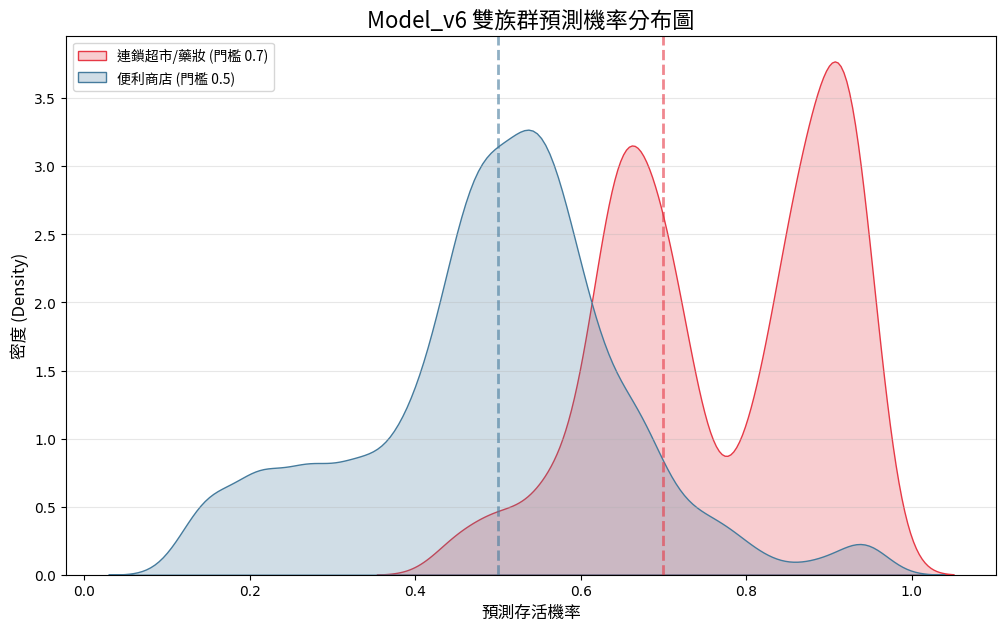

████████████████████████████████████████████████████████████
              🏆 Model_v6 雙門檻戰略版 評估報告              
████████████████████████████████████████████████████████████

【連鎖超市藥妝組】判定門檻: 0.7 (樣本數: 119)
  ● Accuracy   : 71.43%
  ● Recall 0   : 84.21%
  ● Precision 1: 95.83%

【便利商店組 (CVS)】判定門檻: 0.5 (樣本數: 524)
  ● Accuracy   : 62.02%
  ● Recall 0   : 65.27%
  ● Precision 1: 78.83%
████████████████████████████████████████████████████████████


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. 分群資料準備
# df_val_results 應包含 '是否便利商店', '預測機率', '實際結果'
df_cvs = df_val_results[df_val_results['是否便利商店'] == 1]
df_anchor = df_val_results[df_val_results['是否便利商店'] == 0]

# 2. 設定門檻與計算指標
# 超市藥妝 (Anchor) 使用 0.7，便利商店 (CVS) 使用 0.5
y_pred_anchor = (df_anchor['預測機率'] >= 0.7).astype(int)
y_pred_cvs = (df_cvs['預測機率'] >= 0.5).astype(int)

# 3. 繪製分布圖 (套用中文字體)
plt.figure(figsize=(12, 7))

sns.kdeplot(df_anchor['預測機率'], fill=True, label='連鎖超市/藥妝 (門檻 0.7)', color='#E63946', bw_adjust=0.6)
sns.kdeplot(df_cvs['預測機率'], fill=True, label='便利商店 (門檻 0.5)', color='#457B9D', bw_adjust=0.6)

# 標註門檻線
plt.axvline(0.7, color='#E63946', linestyle='--', linewidth=2, alpha=0.6)
plt.axvline(0.5, color='#457B9D', linestyle='--', linewidth=2, alpha=0.6)

# 設定標題與標籤 (使用 fontproperties)
plt.title('Model_v6 雙族群預測機率分布圖', fontproperties=custom_font, fontsize=16)
plt.xlabel('預測存活機率', fontproperties=custom_font, fontsize=12)
plt.ylabel('密度 (Density)', fontproperties=custom_font, fontsize=12)
plt.legend(prop=custom_font)
plt.grid(axis='y', alpha=0.3)

plt.show()

# 4. 輸出 v6 戰略版評估報告
print("█" * 60)
print("🏆 Model_v6 雙門檻戰略版 評估報告".center(50))
print("█" * 60)

print(f"\n【連鎖超市藥妝組】判定門檻: 0.7 (樣本數: {len(df_anchor)})")
print(f"  ● Accuracy   : {accuracy_score(df_anchor['實際結果'], y_pred_anchor):.2%}")
print(f"  ● Recall 0   : {recall_score(df_anchor['實際結果'], y_pred_anchor, pos_label=0):.2%}")
print(f"  ● Precision 1: {precision_score(df_anchor['實際結果'], y_pred_anchor):.2%}")

print(f"\n【便利商店組 (CVS)】判定門檻: 0.5 (樣本數: {len(df_cvs)})")
print(f"  ● Accuracy   : {accuracy_score(df_cvs['實際結果'], y_pred_cvs):.2%}")
print(f"  ● Recall 0   : {recall_score(df_cvs['實際結果'], y_pred_cvs, pos_label=0):.2%}")
print(f"  ● Precision 1: {precision_score(df_cvs['實際結果'], y_pred_cvs):.2%}")
print("█" * 60)

In [ ]:
from sklearn.metrics import confusion_matrix

# 計算超市組矩陣
cm_anchor = confusion_matrix(df_anchor['實際結果'], y_pred_anchor)
# 計算 CVS 組矩陣
cm_cvs = confusion_matrix(df_cvs['實際結果'], y_pred_cvs)

def print_result_counts(group_name, cm):
    tn, fp, fn, tp = cm.ravel()
    print(f"【{group_name}】")
    print(f"  ● 模型通過(推薦)總數: {tp + fp} (佔比: {(tp + fp)/(tn + fp + fn + tp):.1%})")
    print(f"  ● 其中真成功(TP): {tp} | 誤判成功(FP): {fp}")
    print(f"  ● 攔截地雷總數: {tn + fn}")
    print(f"  ● 其中真攔截(TN): {tn} | 誤殺地雷(FN): {fn}\n")

print_result_counts("連鎖超市藥妝組", cm_anchor)
print_result_counts("便利商店組 (CVS)", cm_cvs)

【連鎖超市藥妝組】
  ● 模型通過(推薦)總數: 72 (佔比: 60.5%)
  ● 其中真成功(TP): 69 | 誤判成功(FP): 3
  ● 攔截地雷總數: 47
  ● 其中真攔截(TN): 16 | 誤殺地雷(FN): 31

【便利商店組 (CVS)】
  ● 模型通過(推薦)總數: 274 (佔比: 52.3%)
  ● 其中真成功(TP): 216 | 誤判成功(FP): 58
  ● 攔截地雷總數: 250
  ● 其中真攔截(TN): 109 | 誤殺地雷(FN): 141



### 檢查黑馬店面(模型判死，實際存活)
初步結論是需要增加微觀特徵。

🔍 [CVS組] 黑馬店面 vs 標準優等生：特徵對照表
------------------------------------------------------------
診斷類型               標準優等生 (TP)    黑馬店面 (FN)    差異 (%)
brand_prob_m11         0.5624       0.4510  -19.8130
日夜人流差               4395.7407    -423.7234 -109.6394
租金_log                10.4433      10.3252   -1.1310
競爭優勢                   0.4486       0.3841  -14.3767
people_per_store     593.2207     221.2085  -62.7106
行政區平日日間活動人數       283741.0509  314100.2057   10.6996
發票銷售額指標               75.2338      69.3759   -7.7863


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31199 (\N{CJK UNIFIED IDEOGRAPH-79DF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35386 (\N{CJK UNIFIED IDEOGRAPH-8A3A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26039 (\N{CJK UNIFIED IDEOGRAPH-65B7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  fig.canvas

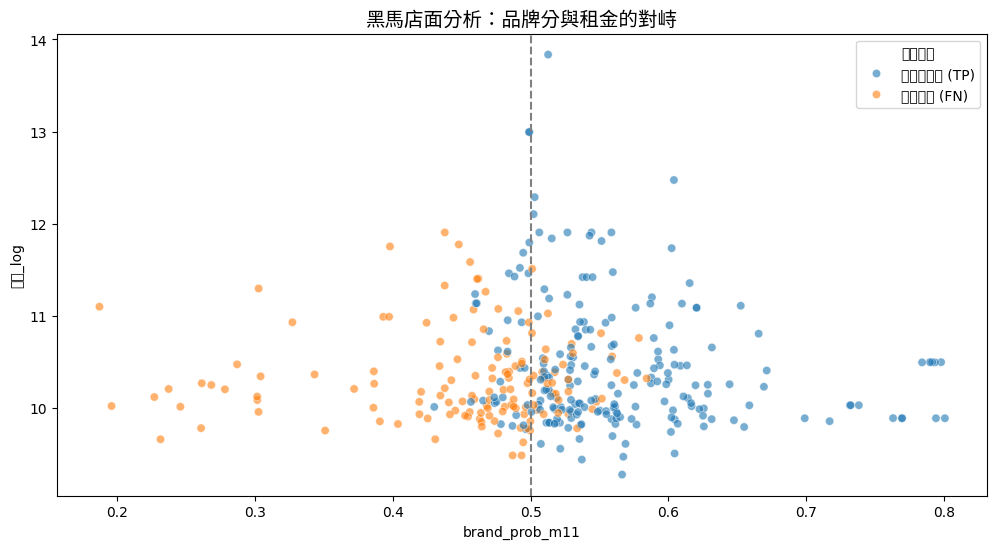

In [ ]:
# 1. 標記 FN (黑馬) 與 TP (標準優等生)
df_cvs_analysis = df_cvs.copy()
df_cvs_analysis['診斷類型'] = '其他'
df_cvs_analysis.loc[(df_cvs_analysis['實際結果'] == 1) & (y_pred_cvs == 0), '診斷類型'] = '黑馬店面 (FN)'
df_cvs_analysis.loc[(df_cvs_analysis['實際結果'] == 1) & (y_pred_cvs == 1), '診斷類型'] = '標準優等生 (TP)'

# 2. 篩選出這兩群進行對比
df_diagnostic = df_cvs_analysis[df_cvs_analysis['診斷類型'] != '其他']

# 3. 計算特徵平均值對照表
comparison_metrics = [
    'brand_prob_m11', '日夜人流差', '租金_log', '競爭優勢',
    'people_per_store', '行政區平日日間活動人數', '發票銷售額指標'
]

diagnostic_report = df_diagnostic.groupby('診斷類型')[comparison_metrics].mean().T
diagnostic_report['差異 (%)'] = ((diagnostic_report['黑馬店面 (FN)'] - diagnostic_report['標準優等生 (TP)']) / diagnostic_report['標準優等生 (TP)']) * 100

print("🔍 [CVS組] 黑馬店面 vs 標準優等生：特徵對照表")
print("-" * 60)
print(diagnostic_report.round(4))

# 4. 視覺化關鍵差異：租金與品牌分
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_diagnostic, x='brand_prob_m11', y='租金_log', hue='診斷類型', alpha=0.6)
plt.title('黑馬店面分析：品牌分與租金的對峙', fontproperties=custom_font, fontsize=14)
plt.axvline(0.5, color='gray', linestyle='--')
plt.show()

🔍 [CVS組] 各品牌『黑馬誤判』實測數據：
------------------------------------------------------------
診斷類型          FN_黑馬店面  TP_標準優等生  總計(實際營運)  誤殺率(%)
公司名稱                                             
統一超商股份有限公司         62       128       190   32.63
全家便利商店股份有限公司       43        75       118   36.44
萊爾富國際股份有限公司        31        10        41   75.61
來來超商股份有限公司          5         3         8   62.50


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21496 (\N{CJK UNIFIED IDEOGRAPH-53F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31281 (\N{CJK UNIFIED IDEOGRAPH-7A31}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


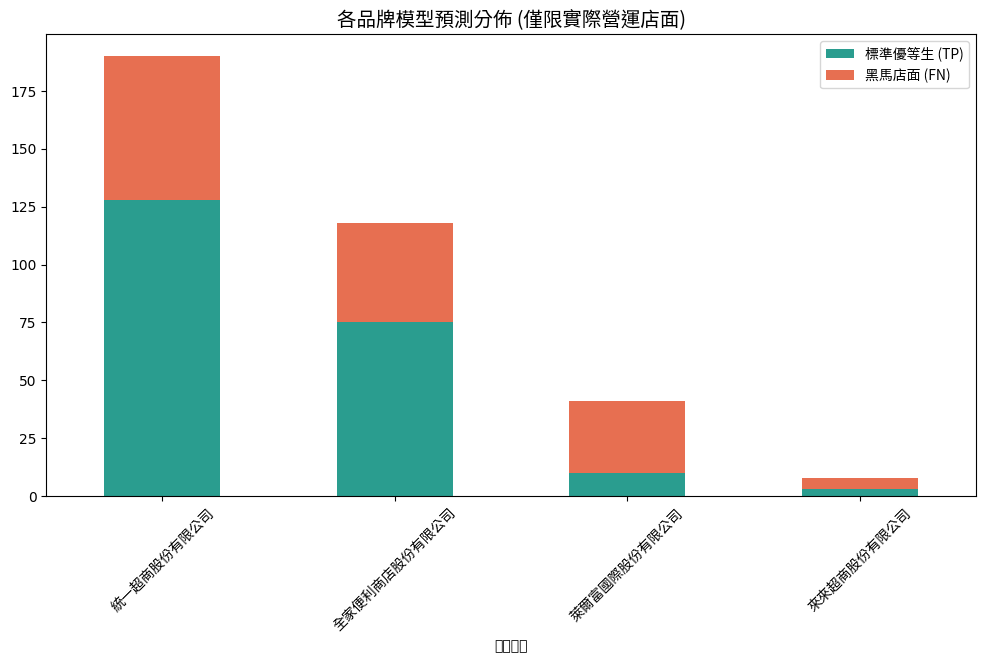

In [ ]:
# 1. 取得驗證集的索引，並從原始 df_ml 抓回「公司名稱」
val_indices = X_val_v6.index
df_val_with_brand = df_ml.loc[val_indices].copy()

# 2. 將預測結果與機率整合進去
df_val_with_brand['預測機率'] = y_prob_v6
df_val_with_brand['預測結果'] = y_pred_v6
df_val_with_brand['實際結果'] = y_val_v6

# 3. 建立診斷標籤 (僅針對便利商店組)
df_cvs_diag = df_val_with_brand[df_val_with_brand['是否便利商店'] == 1].copy()

def get_diag_type(row):
    if row['實際結果'] == 1 and row['預測結果'] == 1:
        return 'TP_標準優等生'
    elif row['實際結果'] == 1 and row['預測結果'] == 0:
        return 'FN_黑馬店面'
    else:
        return 'Other'

df_cvs_diag['診斷類型'] = df_cvs_diag.apply(get_diag_type, axis=1)

# 4. 針對「公司名稱」進行交叉分析
# 只看實際有活下來的店 (TP + FN)
brand_stats = df_cvs_diag[df_cvs_diag['診斷類型'].isin(['TP_標準優等生', 'FN_黑馬店面'])] \
    .groupby(['公司名稱', '診斷類型']).size().unstack(fill_value=0)

# 5. 計算誤殺率與統計
if not brand_stats.empty:
    # 確保兩欄都存在，避免只有其中一種結果時報錯
    if 'TP_標準優等生' not in brand_stats.columns: brand_stats['TP_標準優等生'] = 0
    if 'FN_黑馬店面' not in brand_stats.columns: brand_stats['FN_黑馬店面'] = 0

    brand_stats['總計(實際營運)'] = brand_stats['TP_標準優等生'] + brand_stats['FN_黑馬店面']
    brand_stats['誤殺率(%)'] = (brand_stats['FN_黑馬店面'] / brand_stats['總計(實際營運)'] * 100).round(2)
    brand_stats = brand_stats.sort_values(by='總計(實際營運)', ascending=False)

    print("🔍 [CVS組] 各品牌『黑馬誤判』實測數據：")
    print("-" * 60)
    print(brand_stats)
else:
    print("未找到符合條件的數據。")

# 6. 視覺化
plt.figure(figsize=(12, 6))
brand_stats[['TP_標準優等生', 'FN_黑馬店面']].plot(kind='bar', stacked=True, ax=plt.gca(), color=['#2A9D8F', '#E76F51'])
plt.xticks(fontproperties=custom_font, rotation=45)
plt.title('各品牌模型預測分佈 (僅限實際營運店面)', fontproperties=custom_font, fontsize=14)
plt.legend(['標準優等生 (TP)', '黑馬店面 (FN)'], prop=custom_font)
plt.show()

🔍 [CVS 原始版] 二線品牌黑馬店面 (FN) 地理分佈：
------------------------------------------------------------
公司名稱  來來超商股份有限公司  萊爾富國際股份有限公司  黑馬總數
行政區                                
三重區            0            4     4
板橋區            1            3     4
內湖區            0            3     3
士林區            0            3     3
土城區            1            2     3
松山區            0            3     3
信義區            0            2     2
新店區            1            1     2
中山區            0            2     2
萬華區            0            2     2
新莊區            1            1     2
中和區            0            1     1
樹林區            0            1     1
永和區            1            0     1
汐止區            0            1     1
泰山區            0            1     1
淡水區            0            1     1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21496 (\N{CJK UNIFIED IDEOGRAPH-53F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31281 (\N{CJK UNIFIED IDEOGRAPH-7A31}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40657 (\N{CJK UNIFIED IDEOGRAPH-9ED1}) missing from font(s) DejaVu Sans.
  fig.canvas

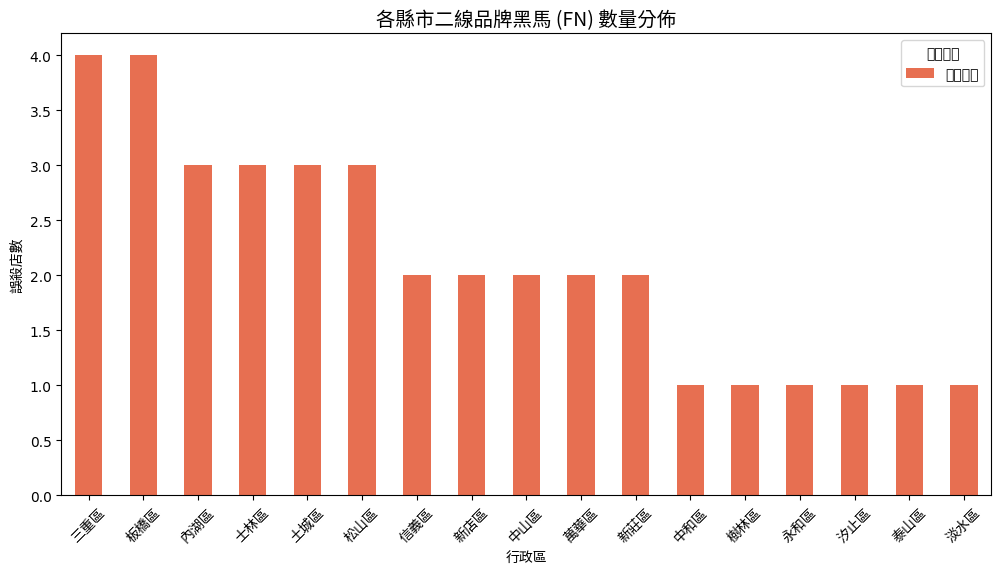


🔍 黑馬店面區域特徵平均值：


KeyError: "['日夜人流差'] not in index"

In [ ]:
# 1. 確保回歸原始 Model_v6 的預測（不使用 Grid Search 調整後的參數）
# 假設 y_pred_v6 是你最初版本（超市 0.7 / CVS 0.5 門檻）的預測結果
df_val_final = df_val_with_brand.copy()
df_val_final['原始預測結果'] = y_pred_v6  # 請替換為你最初版本的預測變數

# 2. 定義黑馬店面 (FN)：實際營運(1) 但 模型判定廢止(0)
# 並且鎖定 OK Mart 與 萊爾富
target_brands = ['來來超商股份有限公司', '萊爾富國際股份有限公司']
df_black_horse = df_val_final[
    (df_val_final['公司名稱'].isin(target_brands)) &
    (df_val_final['實際結果'] == 1) &
    (df_val_final['原始預測結果'] == 0)
].copy()

# 3. 進行地理分布統計 (縣市層級)
geo_dist = df_black_horse.groupby(['行政區', '公司名稱']).size().unstack(fill_value=0)
geo_dist['黑馬總數'] = geo_dist.sum(axis=1)
geo_dist = geo_dist.sort_values(by='黑馬總數', ascending=False)

print("🔍 [CVS 原始版] 二線品牌黑馬店面 (FN) 地理分佈：")
print("-" * 60)
print(geo_dist)

# 4. 視覺化：觀察哪些縣市是「模型盲區」
plt.figure(figsize=(12, 6))
geo_dist[['黑馬總數']].plot(kind='bar', ax=plt.gca(), color='#E76F51')
plt.title('各縣市二線品牌黑馬 (FN) 數量分佈', fontproperties=custom_font, fontsize=14)
plt.ylabel('誤殺店數', fontproperties=custom_font)
plt.xlabel('行政區', fontproperties=custom_font)
plt.xticks(fontproperties=custom_font, rotation=45)
plt.show()

# 5. 進階檢查：看看這群黑馬所在的「里人均收入」或「日夜人流差」是否有地域共性
print("\n🔍 黑馬店面區域特徵平均值：")
print(df_black_horse[['里人均收入中位數', '日夜人流差', '競爭壓力指標']].mean())

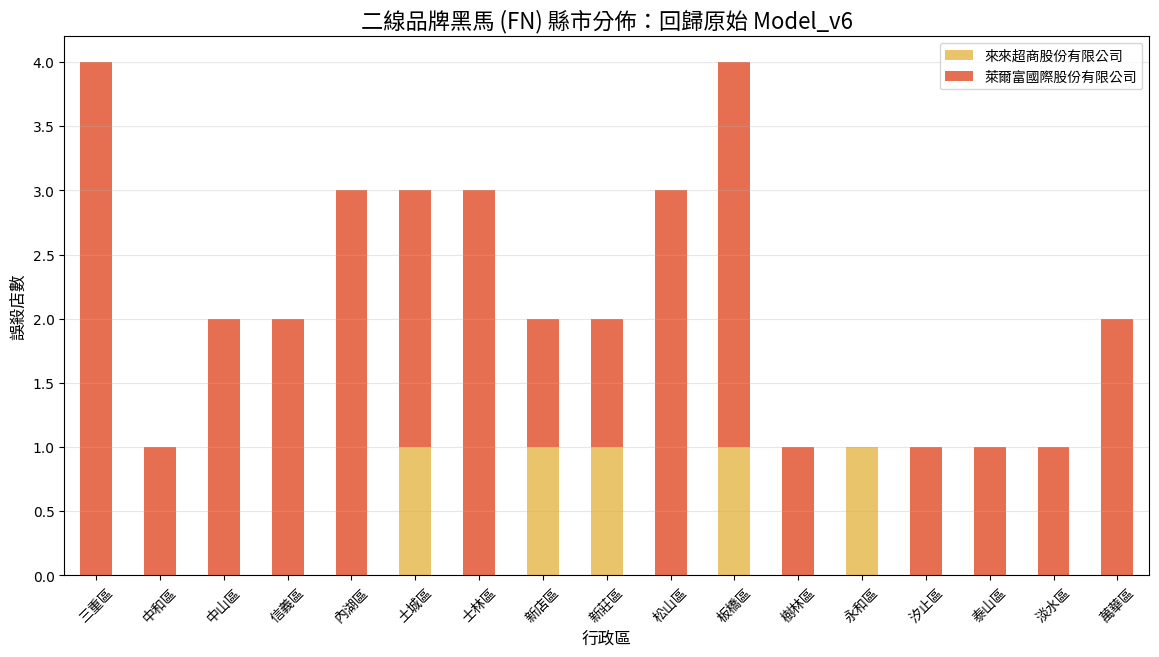

🔍 黑馬店面區域特徵平均值：
----------------------------------------
里人均收入中位數    563.916667
競爭壓力指標        0.006672
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 自動檢查欄位名稱 (防止 KeyError)
all_cols = df_val_final.columns.tolist()
# 找出最接近的名稱，或者直接用 index 定位
target_features = ['里人均收入中位數', '日夜人流差', '競爭壓力指標']
actual_features = [c for c in target_features if c in all_cols]

# 2. 篩選二線品牌黑馬 (FN)
target_brands = ['來來超商股份有限公司', '萊爾富國際股份有限公司']
df_black_horse = df_val_final[
    (df_val_final['公司名稱'].isin(target_brands)) &
    (df_val_final['實際結果'] == 1) &
    (df_val_final['原始預測結果'] == 0)
].copy()

# 3. 繪製地理分佈圖 (修正字體警告)
if not df_black_horse.empty:
    geo_dist = df_black_horse.groupby(['行政區', '公司名稱']).size().unstack(fill_value=0)

    # 確保繪圖使用你下載的 font.ttf
    plt.figure(figsize=(14, 7))
    geo_dist.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#E9C46A', '#E76F51'])

    plt.title('二線品牌黑馬 (FN) 縣市分佈：回歸原始 Model_v6', fontproperties=custom_font, fontsize=16)
    plt.xlabel('行政區', fontproperties=custom_font, fontsize=12)
    plt.ylabel('誤殺店數', fontproperties=custom_font, fontsize=12)
    plt.xticks(fontproperties=custom_font, rotation=45)
    plt.legend(prop=custom_font)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 4. 輸出特徵平均值 (防錯處理)
    print("🔍 黑馬店面區域特徵平均值：")
    print("-" * 40)
    if actual_features:
        print(df_black_horse[actual_features].mean())
    else:
        print("警告：找不到指定的特徵欄位，現有欄位為：", all_cols[:10], "...")
else:
    print("找不到符合條件的黑馬店面資料。")

In [ ]:
# 回去原資料表撈地址
df_orig = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/資料訓練大表_v1.0_20260205報告版.csv', encoding='utf-8', index_col=False, sep=';')
df_orig.columns

Index(['id', '公司名稱', '分公司名稱', '地址', '分公司狀態', '分公司核准設立日期', '登記現況', 'start_year',
       '縣市', '行政區', '里別', '行政區平日夜間停留人數', '行政區平日日間活動人數', '行政區假日夜間停留人數',
       '行政區假日日間活動人數', '里人均收入中位數', '里人口數', '發票張數指標', '發票銷售額指標', '店_緯度', '店_經度',
       '500公尺內的熱鬧據點數', '最近的熱鬧據點類型', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
       '500公尺外部競爭(不同公司店數)', '500公尺內部競爭_時間(同公司店數)', '500公尺外部競爭_時間(不同公司店數)',
       '租金'],
      dtype='object')

In [ ]:
# 1. 確保 df_orig 的 Index 跟 df_ml/df_val 是對齊的
# 如果你讀取 CSV 時沒有設定 index_col，可能需要對齊一下，或者使用共同的 key (如：店號)
# 假設 Index 是對齊的：
target_indices = df_black_horse[df_black_horse['縣市'].isin(['臺北市', '新北市'])].index

# 2. 定義你想看到的欄位名稱（請根據剛才 df_orig.columns 的結果微調）
# 這裡假設欄位叫 '公司名稱', '分店名稱', '地址'
check_cols = ['公司名稱', '分公司名稱', '地址', '縣市', '鄉鎮市區']
available_check_cols = [c for c in check_cols if c in df_orig.columns]

# 3. 提取清單
black_horse_addresses = df_orig.loc[target_indices, available_check_cols]

# 4. 打印結果
print(f"📍 雙北黑馬名單 (共 {len(black_horse_addresses)} 筆)：")
print("-" * 60)
print(black_horse_addresses.to_markdown())

# 5. 直接存成 Excel 方便你用手機開地圖看
# black_horse_addresses.to_excel("雙北黑馬考察清單.xlsx", index=False)

📍 雙北黑馬名單 (共 36 筆)：
------------------------------------------------------------
|      | 公司名稱                           | 分公司名稱             | 地址                            | 縣市   |
|-----:|:-----------------------------------|:-----------------------|:--------------------------------|:-------|
| 5243 | 統一超商股份有限公司               | 臺北縣第１７１分公司   | 新北市萬里區野柳村港東路158號   | 新北市 |
| 3591 | 全家便利商店股份有限公司           | 興盛分公司             | 臺北市內湖區新明路182號         | 臺北市 |
| 5481 | 全家便利商店股份有限公司           | 集英分公司             | 臺北市中山區民權西路64號        | 臺北市 |
| 2035 | 統一超商股份有限公司               | 台北縣第２７３分公司   | 新北市林口區中山路164號         | 新北市 |
| 1703 | 全家便利商店股份有限公司           | 新店德安分公司         | 新北市新店區安康路2段303號      | 新北市 |
|  587 | 全家便利商店股份有限公司           | 新北市第八九七分公司   | 新北市永和區中正路342號         | 新北市 |
| 1882 | 全家便利商店股份有限公司           | 新北市第八九四分公司   | 新北市中和區華新街55號          | 新北市 |
| 5097 | 統一超商股份有限公司               | 新北市第七八二分公司   | 新北市蘆洲區永康街1巷35號       | 新北市 |
| 5053 | 萊爾富國際股份有限公司             | 第三六一一分公司       | 臺北市中正區衡陽

🔍 黑馬名單的「三大生存模板」診斷
我挑選了名單中幾個具代表性的點位，帶你看看模型為什麼會「看走眼」：

1. 「巷弄飽和區」的生存（模型：競爭太強會倒 vs. 現實：人多到餵飽所有人）
代表店位：新北市蘆洲區永康街1巷35號 (7-11)、新北市三重區文化北路10號 (7-11)。

    模型誤判原因：這些地方位於超高密度的舊住宅區，巷弄狹窄且周邊便利商店密度極高。模型的 people_per_store 會顯示服務人口過少，加上品牌分散，因此判死。

    現實真相：這類「咽喉點」的夜間人流極度驚人。即便在巷弄裡，只要是居民下車、走路回家的必經之路，即便旁邊有 3 家競爭對手也都能活。

2. 「商辦/補習街」的邊緣（模型：品牌分不夠 vs. 現實：絕對人流紅利）
代表店位：臺北市中正區青島西路13號 (全家)、臺北市中正區衡陽路103號 (萊爾富)。

    模型誤判原因：這些地方租金極高（租金_log 爆表），且萊爾富等品牌在模型中的「品牌基本分」較低。模型認為在高租金壓力下，二線品牌撐不住。

    現實真相：這裡是台北車站/補習街商圈。人流量大到可以忽略品牌效應。只要你有店面，不論你是 7-11 還是萊爾富，消費者為了「近」都會進去消費。

3. 「邊緣工業/辦公區」的壟斷（模型：人煙稀少 vs. 現實：剛性需求）
代表店位：新北市新店區寶橋路235巷128號 (萊爾富)。

    模型誤判原因：這裡位於新店工業區深處，假日或夜間的「日夜人流差」數據可能很難看，模型認為這是不毛之地。

    現實真相：這是標準的「廠辦封閉市場」。雖然只有周一到周五有生意，但因為它是這幾棟辦公大樓唯一的補給站，具備微觀上的壟斷地位。

### 檢查過度樂觀(模型判生，實際廢止)

In [ ]:
# 1. 篩選出 FP (誤判成功)：預測營運(1) 但 實際廢止(0)
df_fp = df_val_final[
    (df_val_final['實際結果'] == 0) &
    (df_val_final['原始預測結果'] == 1)
].copy()

# 2. 品牌分布檢查：看看模型是否對某些品牌「過度迷信」
fp_brand_stats = df_fp.groupby('公司名稱').size().sort_values(ascending=False)

print(f"🚩 發現 {len(df_fp)} 筆「過度樂觀」的誤判 (FP)")
print("-" * 60)
print("🔍 誤判品牌排行：")
print(fp_brand_stats)

# 3. 提取地址清單 (雙北優先)
target_indices_fp = df_fp[df_fp['縣市'].isin(['臺北市', '新北市'])].index
check_cols = ['公司名稱', '分店名稱', '地址', '縣市', '預測機率']
available_cols = [c for c in check_cols if c in df_orig.columns or c in df_fp.columns]

fp_list = df_orig.loc[target_indices_fp, [c for c in check_cols if c in df_orig.columns]]
fp_list['預測機率'] = df_fp.loc[target_indices_fp, '預測機率']

print("\n📍 雙北「陷阱店面」清單 (FP)：")
print(fp_list.to_markdown())

# 4. 特徵對照：為什麼模型會看好它們？
# 將 FP 與 真正的成功 (TP) 進行均值對比
df_tp = df_val_final[(df_val_final['實際結果'] == 1) & (df_val_final['原始預測結果'] == 1)]
comp_features = ['brand_prob_m11', '日夜人流差', '租金_log', '競爭優勢']
actual_comp = [c for c in comp_features if c in df_val_final.columns]

comparison = pd.DataFrame({
    '真正成功 (TP)': df_tp[actual_comp].mean(),
    '過度樂觀 (FP)': df_fp[actual_comp].mean()
})
comparison['差異'] = comparison['過度樂觀 (FP)'] - comparison['真正成功 (TP)']

print("\n📊 為什麼模型被騙了？ (TP vs FP 特徵對照)")
print("-" * 60)
print(comparison.round(4))

🚩 發現 76 筆「過度樂觀」的誤判 (FP)
------------------------------------------------------------
🔍 誤判品牌排行：
公司名稱
全家便利商店股份有限公司         25
統一超商股份有限公司           24
台灣屈臣氏個人用品商店股份有限公司     6
來來超商股份有限公司            6
全聯實業股份有限公司            5
統一生活事業股份有限公司          4
三商家購股份有限公司            3
萊爾富國際股份有限公司           3
dtype: int64

📍 雙北「陷阱店面」清單 (FP)：
|      | 公司名稱                           | 地址                               | 縣市   |   預測機率 |
|-----:|:-----------------------------------|:-----------------------------------|:-------|-----------:|
| 4000 | 萊爾富國際股份有限公司             | 臺北市信義區吳興街104號            | 臺北市 |   0.649273 |
| 3582 | 來來超商股份有限公司               | 臺北市內湖區康樂街162巷1號         | 臺北市 |   0.510615 |
| 3661 | 來來超商股份有限公司               | 臺北市文山區指南路2段145號         | 臺北市 |   0.508331 |
| 1974 | 統一超商股份有限公司               | 新北市板橋區中山路2段531巷17弄20號 | 新北市 |   0.623292 |
| 3714 | 全家便利商店股份有限公司           | 臺北市文山區興隆路3段49號          | 臺北市 |   0.545182 |
| 4183 | 全家便利商店股份有限公司           | 臺北市萬華區西昌街170號            | 臺北市 |   0.50712

In [ ]:
# 1. 取得 TP 與 FP 的索引 (Index)
# 註：請確保 df_val_final 的索引與 X_val_v6 是完全對齊的
tp_indices = df_val_final[(df_val_final['實際結果'] == 1) & (df_val_final['原始預測結果'] == 1)].index
fp_indices = df_val_final[(df_val_final['實際結果'] == 0) & (df_val_final['原始預測結果'] == 1)].index

# 2. 定義要觀察的特徵 (排除 category 欄位以方便計算 mean)
features_to_check = [
    'brand_prob_m11', '租金_log', '發票銷售額指標', '日夜人流差',
    '里人均收入中位數', 'people_per_store', '競爭優勢', '競爭壓力指標'
]

# 3. 從 X_val_v6 中提取數據並計算平均值
# 假設你的驗證集特徵矩陣變數名為 X_val_v6
comparison_x6 = pd.DataFrame({
    '真正成功 (TP)': X_val_v6.loc[tp_indices, features_to_check].mean(),
    '過度樂觀 (FP)': X_val_v6.loc[fp_indices, features_to_check].mean()
})

# 4. 計算差異百分比
comparison_x6['差異 (%)'] = ((comparison_x6['過度樂觀 (FP)'] / comparison_x6['真正成功 (TP)'] - 1) * 100).round(2)

print("🏆 Model_v6 特徵空間診斷 (FP vs TP)")
print("-" * 60)
print(comparison_x6.sort_values(by='差異 (%)', ascending=False))

🏆 Model_v6 特徵空間診斷 (FP vs TP)
------------------------------------------------------------
                   真正成功 (TP)     過度樂觀 (FP)   差異 (%)
日夜人流差             465.575080  12955.736842  2682.74
競爭壓力指標              0.004073      0.005845    43.51
發票銷售額指標            75.290735     77.750000     3.27
競爭優勢                0.321813      0.330053     2.56
租金_log             10.377559     10.465237     0.84
里人均收入中位數          622.511182    625.750000     0.52
brand_prob_m11      0.616915      0.555032   -10.03
people_per_store  547.180454    318.756616   -41.75


### (放棄)model_v6微調
執行grid調整權重。

這次的「最佳化」其實落入了一個典型的數據陷阱：模型為了追求整體的 F1-Score 和 Recall，選擇了最省力的路徑——「無腦相信 7-11」。

在展店選址的商業邏輯中，「寧缺勿濫（高 Precision）」 遠比 「寧濫勿缺（高 Recall）」 重要得多。原本的版本雖然「冷酷」，但它至少是個有原則的守門員。

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# 1. 定義基礎模型 (使用 Scikit-learn API 方便 GridSearch)
xgb_model = XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,
    tree_method='hist',
    eval_metric='logloss',
    random_state=42
)

# 2. 設定網格參數：重點在於 colsample_bytree 與 min_child_weight
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 4],              # 淺一點的樹，避免過度依賴品牌細節
    'learning_rate': [0.01, 0.05],
    'colsample_bytree': [0.5, 0.7],   # 強迫某些樹「無視品牌分」，觀察其他地理特徵
    'subsample': [0.8],
    'scale_pos_weight': [0.4, 0.5],   # 調整類別權重，救回那些被誤殺的店
    'gamma': [1.0, 1.5]               # 增加剪枝力度，防止模型因為品牌分高就輕易給 1
}

# 3. 執行 Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,                             # 3 折交叉驗證
    scoring='f1',                     # 我們要平衡 Precision 與 Recall，所以選 F1
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_v6, y_train_v6)

# 4. 取得最優模型並評估
best_model_v6 = grid_search.best_estimator_
print(f"最佳參數: {grid_search.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
最佳參數: {'colsample_bytree': 0.5, 'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 0.5, 'subsample': 0.8}


🏆 Model_v6 (Grid Search 最佳化版) 最終評估報告
--------------------------------------------------
Accuracy  : 0.7403
Precision : 0.7767
Recall    : 0.8906
F1-Score  : 0.8298
AUC Score : 0.7092

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.58      0.37      0.45       186
           1       0.78      0.89      0.83       457

    accuracy                           0.74       643
   macro avg       0.68      0.63      0.64       643
weighted avg       0.72      0.74      0.72       643


==================== Feature Importance (Gain) ====================
             Feature  Importance
13    brand_prob_m11   48.491322
0             是否便利商店   35.382904
1               競爭優勢   23.449724
2   people_per_store   13.273549
3             競爭壓力指標   13.229923
4           里人均收入中位數    8.077371
6        行政區平日日間活動人數    7.842604
7              日夜人流差    6.783904
11              里人口數    6.272623
5            發票銷售額指標    6.

/tmp/ipython-input-2180757201.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21542 (\N{CJK UNIFIED IDEOGRAPH-5426}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20415 (\N{CJK UNIFIED IDEOGRAPH-4FBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarn

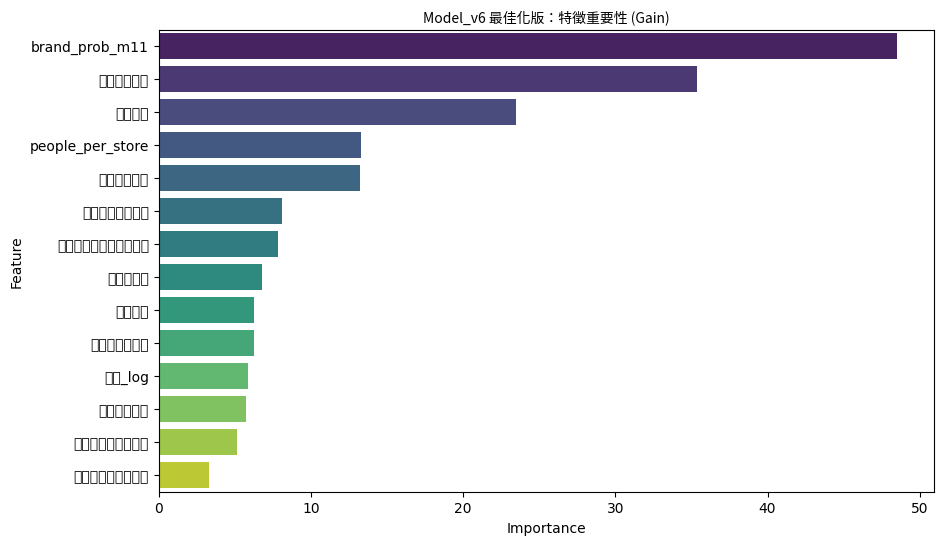

In [ ]:
# 取得預測機率與類別
y_prob_best = best_model_v6.predict_proba(X_val_v6)[:, 1]
y_pred_best = best_model_v6.predict(X_val_v6)

# ---------------------------------------------------------
# 2. 產出評估報告
# ---------------------------------------------------------
print("🏆 Model_v6 (Grid Search 最佳化版) 最終評估報告")
print("-" * 50)
print(f"Accuracy  : {accuracy_score(y_val_v6, y_pred_best):.4f}")
print(f"Precision : {precision_score(y_val_v6, y_pred_best):.4f}")
print(f"Recall    : {recall_score(y_val_v6, y_pred_best):.4f}")
print(f"F1-Score  : {f1_score(y_val_v6, y_pred_best):.4f}")
print(f"AUC Score : {roc_auc_score(y_val_v6, y_prob_best):.4f}")

print("\n" + "="*20 + " Classification Report " + "="*20)
print(classification_report(y_val_v6, y_pred_best))

# ---------------------------------------------------------
# 3. 特徵重要性排行 (以 Gain 為準)
# ---------------------------------------------------------
# 取得 XGBoost 的原生 Booster 以提取 Gain
booster = best_model_v6.get_booster()
importance_gain = booster.get_score(importance_type='gain')

# 建立 DataFrame 並補齊可能在採樣中沒出現的特徵
importance_df = pd.DataFrame({
    'Feature': X_val_v6.columns,
    'Importance': [importance_gain.get(f, 0) for f in X_val_v6.columns]
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*20 + " Feature Importance (Gain) " + "="*20)
print(importance_df)

# ---------------------------------------------------------
# 4. 視覺化排行
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Model_v6 最佳化版：特徵重要性 (Gain)', fontproperties=custom_font)
plt.show()

In [ ]:
# 再次掛載品牌名稱進行診斷 (延用之前的 df_val_with_brand 邏輯)
df_val_with_brand['新預測結果'] = y_pred_best
df_val_with_brand['新診斷類型'] = df_val_with_brand.apply(
    lambda x: 'FN_黑馬店面' if (x['實際結果'] == 1 and x['新預測結果'] == 0) else
              ('TP_標準優等生' if (x['實際結果'] == 1 and x['新預測結果'] == 1) else 'Other'), axis=1
)

# 重新計算萊爾富等品牌的誤殺率
new_brand_stats = df_val_with_brand[
    (df_val_with_brand['是否便利商店'] == 1) &
    (df_val_with_brand['新診斷類型'].isin(['TP_標準優等生', 'FN_黑馬店面']))
].groupby(['公司名稱', '新診斷類型']).size().unstack(fill_value=0)

if 'FN_黑馬店面' in new_brand_stats.columns:
    new_brand_stats['新誤殺率(%)'] = (new_brand_stats['FN_黑馬店面'] / (new_brand_stats.sum(axis=1)) * 100).round(2)
    print(new_brand_stats[['新誤殺率(%)']].sort_values(by='新誤殺率(%)', ascending=False))

新診斷類型         新誤殺率(%)
公司名稱                 
萊爾富國際股份有限公司     58.54
來來超商股份有限公司      37.50
全家便利商店股份有限公司    11.86
統一超商股份有限公司       4.74


## model_v7：加上微觀特徵

In [ ]:
import pandas as pd
df_v7 = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/train_data_v1.3.csv', encoding='utf-8', index_col=False)
df_v7 = df_v7.dropna()

In [ ]:
df_v7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        6427 non-null   int64  
 1   公司名稱                      6427 non-null   object 
 2   分公司名稱                     6427 non-null   object 
 3   地址                        6427 non-null   object 
 4   分公司核准設立日期                 6427 non-null   object 
 5   start_year                6427 non-null   int64  
 6   縣市                        6427 non-null   object 
 7   行政區                       6427 non-null   object 
 8   里別                        6427 non-null   object 
 9   行政區平日夜間停留人數               6427 non-null   int64  
 10  行政區平日日間活動人數               6427 non-null   int64  
 11  行政區假日夜間停留人數               6427 non-null   int64  
 12  行政區假日日間活動人數               6427 non-null   int64  
 13  里人均收入中位數                  6427 non-null   int64  
 14  里人口數    

In [ ]:
# 建議 V7 使用的特徵組合
final_features_v7 = [
    # --- 核心微觀地利 (新武器) ---
    'dist_to_inter', 'road_level', 'is_premium_corner',
    'micro_loc_risk', 'dist_to_nearest_neighbor',
    'is_lane',

    # --- 修正後的競爭與分潤 ---
    'effective_flow_share', 'people_per_store', 'internal_share_ratio',
    '競爭壓力指標', '競爭優勢',

    # --- 成本與效能 ---
    'rent_flow_ratio', '租金', '發票銷售額指標',

    # --- 基礎環境 (拿掉品牌分，維持地段純度) ---
    '行政區平日日間活動人數', 'day_night_flow', '里人均收入中位數', '里人口數'
]

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

df_v7['target'] = df_v7['登記現況'].map({'營運中': 1, '廢止': 0})
df_v7['最近的熱鬧據點類型'] = df_v7['最近的熱鬧據點類型'].astype('category')
df_v7['租金_log'] = np.log1p(df_v7['租金'])

# 準備數據
X_v7 = df_v7[final_features_v7]
y_v7 = df_v7['target']  # 假設你的目標欄位名稱是 target

X_train_v7, X_val_v7, y_train_v7, y_val_v7 = train_test_split(
    X_v7, y_v7, test_size=0.1, random_state=42, stratify=y_v7
)

# 訓練模型
params_v7 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4, # 針對不平衡樣本調整
    'eval_metric': 'logloss',
    'random_state': 42
}

dtrain_v7 = xgb.DMatrix(X_train_v7, label=y_train_v7)
dval_v7 = xgb.DMatrix(X_val_v7, label=y_val_v7)

final_model_v7 = xgb.train(params_v7, dtrain_v7, num_boost_round=150)

In [ ]:
# ---------------------------------------------------------
# 5. 全面評估報告 (不再呼叫任何外部函數)
# ---------------------------------------------------------
y_prob_v7 = final_model_v7.predict(dval_v7)
y_pred_v7 = (y_prob_v7 > 0.5).astype(int)

print("🏆 Model_v6 (Stacking 版) 最終評估報告")
print("-" * 50)
print(f"Accuracy  : {accuracy_score(y_val_v7, y_pred_v7):.4f}")
print(f"Precision : {precision_score(y_val_v7, y_pred_v7):.4f}")
print(f"Recall    : {recall_score(y_val_v7, y_pred_v7):.4f}")
print(f"F1-Score  : {f1_score(y_val_v7, y_pred_v7):.4f}")
print(f"AUC Score : {roc_auc_score(y_val_v7, y_prob_v7):.4f}")

print("\n" + "="*20 + " Classification Report " + "="*20)
print(classification_report(y_val_v7, y_pred_v7))

# ---------------------------------------------------------
# 6. 特徵重要性排行 (Feature Importance)
# ---------------------------------------------------------
importance = final_model_v7.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*20 + " Feature Importance (Gain) " + "="*20)
print(importance_df)



🏆 Model_v6 (Stacking 版) 最終評估報告
--------------------------------------------------
Accuracy  : 0.6687
Precision : 0.8245
Recall    : 0.6783
F1-Score  : 0.7443
AUC Score : 0.7268

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.45      0.65      0.53       186
           1       0.82      0.68      0.74       457

    accuracy                           0.67       643
   macro avg       0.64      0.66      0.64       643
weighted avg       0.72      0.67      0.68       643


==================== Feature Importance (Gain) ====================
                     Feature  Importance
5   dist_to_nearest_neighbor   11.643118
3          is_premium_corner    4.778291
9                     競爭壓力指標    4.533672
7           people_per_store    4.494359
1                 road_level    4.357833
10                      競爭優勢    4.357770
15            day_night_flow    4.253717
13                   發票銷售額指標    4.

In [ ]:
# 1. 建立一個「SHAP 專用」的資料集，將 category 轉為 codes
X_val_shap = X_val_v7.copy()
for col in X_val_shap.select_dtypes(['category']).columns:
    X_val_shap[col] = X_val_shap[col].cat.codes

# 2. 初始化 SHAP 解釋器
# 注意：TreeExplainer 對於有類別特徵的模型，有時需要直接傳入模型物件
explainer = shap.TreeExplainer(final_model_v7)

# 3. 計算 SHAP 值 (使用轉換後的資料)
shap_values = explainer.shap_values(X_val_shap)

# 4. 建立全局 SHAP 統計表
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    '特徵名稱': X_val_v7.columns,
    '總體影響力 (Mean |SHAP|)': shap_sum
})

# 計算正負向貢獻
# 邏輯：SHAP > 0 代表推向營運(1)，SHAP < 0 代表拉向廢止(0)
importance_df['正向貢獻 (營運推力)'] = [shap_values[shap_values[:, i] > 0, i].mean() if len(shap_values[shap_values[:, i] > 0, i]) > 0 else 0 for i in range(len(X_val_v7.columns))]
importance_df['負向貢獻 (失敗拉力)'] = [shap_values[shap_values[:, i] < 0, i].mean() if len(shap_values[shap_values[:, i] < 0, i]) > 0 else 0 for i in range(len(X_val_v7.columns))]

print("📊 Model_v7 全局 SHAP 特徵正負向貢獻統計表 (修正版)")
print("-" * 80)
print(importance_df.sort_values('總體影響力 (Mean |SHAP|)', ascending=False).to_markdown())

📊 Model_v7 全局 SHAP 特徵正負向貢獻統計表 (修正版)
--------------------------------------------------------------------------------
|    | 特徵名稱                 |   總體影響力 (Mean |SHAP|) |   正向貢獻 (營運推力) |   負向貢獻 (失敗拉力) |
|---:|:-------------------------|---------------------------:|----------------------:|----------------------:|
|  5 | dist_to_nearest_neighbor |                 0.431992   |            0.416092   |           -0.460933   |
| 10 | 競爭優勢                 |                 0.162662   |            0.142084   |           -0.20925    |
| 13 | 發票銷售額指標           |                 0.117761   |            0.130998   |           -0.103454   |
|  1 | road_level               |                 0.106125   |            0.109135   |           -0.10253    |
|  4 | micro_loc_risk           |                 0.102405   |            0.0824606  |           -0.141559   |
| 16 | 里人均收入中位數         |                 0.06432    |            0.054479   |           -0.0788164  |
| 12 | 租金                     |        

### 檢查誤判案例


In [ ]:
# 1. 取得 V7 的預測結果 (假設 y_pred_v7 是你的預測向量)
df_val_v7 = X_val_v7.copy()
df_val_v7['實際結果'] = y_val_v7
df_val_v7['預測結果'] = y_pred_v7

# 2. 篩選出 V7 依然誤殺的黑馬 (FN)
v7_fn_idx = df_val_v7[(df_val_v7['實際結果'] == 1) & (df_val_v7['預測結果'] == 0)].index

# 3. 對比這群黑馬的「物理特徵」均值
v7_fn_analysis = df_v7.loc[v7_fn_idx, ['dist_to_inter', 'dist_to_nearest_neighbor', 'is_lane', 'road_level']].mean()
print("🚩 V7 頑固黑馬 (FN) 特徵均值：")
print(v7_fn_analysis)

🚩 V7 頑固黑馬 (FN) 特徵均值：
dist_to_inter               49.523378
dist_to_nearest_neighbor    30.296224
is_lane                      0.170068
road_level                   2.823129
dtype: float64


In [ ]:
import pandas as pd

def get_ids_by_category_safe(X_val, y_true, y_pred, df_source, category='FN'):
    """
    安全版 ID 提取：利用索引從原始 df 找回 ID
    """
    # 確保預測結果為 binary (0 或 1)
    y_pred_bin = (y_pred > 0.5).astype(int) if hasattr(y_pred, "__iter__") else y_pred

    # 利用索引對齊從原始資料表撈回 ID
    val_ids = df_source.loc[X_val.index, 'id'].values

    temp_df = pd.DataFrame({
        'id': val_ids,
        'actual': y_true.values,
        'pred': y_pred_bin
    })

    if category == 'FN': return set(temp_df[(temp_df['actual'] == 1) & (temp_df['pred'] == 0)]['id'])
    if category == 'FP': return set(temp_df[(temp_df['actual'] == 0) & (temp_df['pred'] == 1)]['id'])
    return set()

# 1. 提取兩代錯誤 ID (傳入原始 df 作為 ID 來源)
v5_fn_ids = get_ids_by_category_safe(X_val_v5, y_val_v5, y_pred_v5, df, 'FN')
v7_fn_ids = get_ids_by_category_safe(X_val_v7, y_val_v7, y_pred_v7, df, 'FN')

v5_fp_ids = get_ids_by_category_safe(X_val_v5, y_val_v5, y_pred_v5, df, 'FP')
v7_fp_ids = get_ids_by_category_safe(X_val_v7, y_val_v7, y_pred_v7, df, 'FP')

# 2. 集合運算：分析進化軌跡
# --- 黑馬 (FN) 遷移 ---
saved_fn = v5_fn_ids - v7_fn_ids        # V5 錯、V7 對 (救回來的黑馬)
stubborn_fn = v5_fn_ids & v7_fn_ids     # 兩代都錯 (頑固核心)
new_fn = v7_fn_ids - v5_fn_ids          # V7 新產生的錯誤

# --- 陷阱 (FP) 遷移 ---
avoided_fp = v5_fp_ids - v7_fp_ids      # V5 錯、V7 對 (成功避開的陷阱)
stubborn_fp = v5_fp_ids & v7_fp_ids     # 兩代都掉坑 (頑固陷阱)
new_fp = v7_fp_ids - v5_fp_ids          # V7 新掉坑的店

# 3. 輸出進化報告
print("📊 Model_v5 -> Model_v7 進化指標報告")
print("="*50)
print(f"✅ 成功救回了 {len(saved_fn)} 筆原本看不懂的黑馬")
print(f"🛡️ 成功避開了 {len(avoided_fp)} 筆原本被騙的陷阱")
print("-" * 50)
print(f"【頑固錯誤】💀 兩代都看不透的：黑馬 {len(stubborn_fn)} 筆 / 陷阱 {len(stubborn_fp)} 筆")
print(f"【副作用監測】⚠️ V7 新產生的錯誤：黑馬 {len(new_fn)} 筆 / 陷阱 {len(new_fp)} 筆")

📊 Model_v5 -> Model_v7 進化指標報告
✅ 成功救回了 89 筆原本看不懂的黑馬
🛡️ 成功避開了 37 筆原本被騙的陷阱
--------------------------------------------------
【頑固錯誤】💀 兩代都看不透的：黑馬 85 筆 / 陷阱 37 筆
【副作用監測】⚠️ V7 新產生的錯誤：黑馬 62 筆 / 陷阱 29 筆


## model_v8：v7微調版


In [ ]:
from sklearn.model_selection import train_test_split
# import xgboost as xgb
# import numpy as np
# import pandas as pd

# 1. 確保特徵已計算
df_v7['日夜人流差'] = df_v7['行政區平日日間活動人數'] - df_v7['行政區平日夜間停留人數']
df_v7['租金_log'] = np.log1p(df_v7['租金'])

# 2. 定義特徵清單 (這部分不變)
final_features_v7_1 = [
    'dist_to_nearest_neighbor', 'road_level', 'dist_to_inter',
    'micro_loc_risk', 'is_premium_corner',
    '競爭優勢', '競爭壓力指標', 'people_per_store',
    '發票銷售額指標', '租金_log', '里人均收入中位數',
    'effective_flow_share', '日夜人流差'
]

# 3. 準備分割：將 id 暫時放入 X 中一起分割，確保血緣不亂
X_all = df_v7[final_features_v7_1 + ['id']]
y_all = df_v7['target']

# 執行分割 (使用 42 作為固定種子，方便你之後對照)
X_train_71, X_val_71, y_train_71, y_val_71 = train_test_split(
    X_all, y_all, test_size=0.1, random_state=42, stratify=y_all
)

# 4. 訓練模型：訓練前把 id 拿掉，但保留 X_val_71['id'] 用於診斷
dtrain_71 = xgb.DMatrix(X_train_71.drop(columns=['id']), label=y_train_71)
dval_71 = xgb.DMatrix(X_val_71.drop(columns=['id']), label=y_val_71)

model_v7_1 = xgb.train(params_v7, dtrain_71, num_boost_round=150)

# 5. 取得預測機率
y_prob_71 = model_v7_1.predict(dval_71)

In [ ]:
# ---------------------------------------------------------
# 5. 全面評估報告 (不再呼叫任何外部函數)
# ---------------------------------------------------------
y_prob_71 = model_v7_1.predict(dval_71)
y_pred_71 = (y_prob_v71 > 0.5).astype(int)

print("🏆 Model_v7_1 (微觀特徵微調版) 最終評估報告")
print("-" * 50)
print(f"Accuracy  : {accuracy_score(y_val_71, y_pred_71):.4f}")
print(f"Precision : {precision_score(y_val_71, y_pred_71):.4f}")
print(f"Recall    : {recall_score(y_val_71, y_pred_71):.4f}")
print(f"F1-Score  : {f1_score(y_val_71, y_pred_71):.4f}")
print(f"AUC Score : {roc_auc_score(y_val_71, y_pred_71):.4f}")

print("\n" + "="*20 + " Classification Report " + "="*20)
print(classification_report(y_val_71, y_pred_71))

# ---------------------------------------------------------
# 6. 特徵重要性排行 (Feature Importance)
# ---------------------------------------------------------
importance = model_v7_1.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*20 + " Feature Importance (Gain) " + "="*20)
print(importance_df)



🏆 Model_v7_1 (微觀特徵微調版) 最終評估報告
--------------------------------------------------
Accuracy  : 0.6672
Precision : 0.8189
Recall    : 0.6827
F1-Score  : 0.7446
AUC Score : 0.6559

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.45      0.63      0.52       186
           1       0.82      0.68      0.74       457

    accuracy                           0.67       643
   macro avg       0.63      0.66      0.63       643
weighted avg       0.71      0.67      0.68       643


==================== Feature Importance (Gain) ====================
                     Feature  Importance
0   dist_to_nearest_neighbor   10.607169
7           people_per_store    4.626549
1                 road_level    4.606206
5                       競爭優勢    4.133728
12                     日夜人流差    4.021623
4          is_premium_corner    3.900933
8                    發票銷售額指標    3.789231
3             micro_loc_risk    3.6

In [ ]:
import numpy as np
import pandas as pd
import shap

# 1. 取得模型預期的特徵清單 (這不包含 id)
expected_features = model_v7_1.feature_names

# 2. 建立 SHAP 專用資料集並強制對齊
X_val_shap = X_val_71.copy()

# 類別轉換 (Codes)
for col in X_val_shap.select_dtypes(['category']).columns:
    X_val_shap[col] = X_val_shap[col].cat.codes

# 重點：只留下模型需要的欄位，這會自動過濾掉 'id'
X_val_shap = X_val_shap.reindex(columns=expected_features, fill_value=0)

print(f"✅ 已過濾非特徵欄位。目前特徵數: {X_val_shap.shape[1]}")

# 3. 初始化 TreeExplainer 並計算 SHAP
explainer = shap.TreeExplainer(model_v7_1)
shap_values = explainer.shap_values(X_val_shap)

# 4. 建立統計表
pos_contributions = []
neg_contributions = []

for i in range(len(expected_features)):
    feature_vals = shap_values[:, i]
    pos_vals = feature_vals[feature_vals > 0]
    neg_vals = feature_vals[feature_vals < 0]

    pos_contributions.append(pos_vals.mean() if len(pos_vals) > 0 else 0)
    neg_contributions.append(neg_vals.mean() if len(neg_vals) > 0 else 0)

importance_df = pd.DataFrame({
    '特徵名稱': expected_features,
    '總體影響力 (Mean |SHAP|)': np.abs(shap_values).mean(axis=0),
    '正向貢獻 (推薦推力)': pos_contributions,
    '負向貢獻 (避雷拉力)': neg_contributions
})

# 依照總體影響力排序
importance_df = importance_df.sort_values('總體影響力 (Mean |SHAP|)', ascending=False)

print("\n📊 V7.1 模型全局 SHAP 特徵分析表 (已排除 ID)")
print("-" * 80)
print(importance_df.to_markdown(index=False))

✅ 已過濾非特徵欄位。目前特徵數: 13

📊 V7.1 模型全局 SHAP 特徵分析表 (已排除 ID)
--------------------------------------------------------------------------------
| 特徵名稱                 |   總體影響力 (Mean |SHAP|) |   正向貢獻 (推薦推力) |   負向貢獻 (避雷拉力) |
|:-------------------------|---------------------------:|----------------------:|----------------------:|
| dist_to_nearest_neighbor |                 0.43882    |            0.431025   |            -0.452354  |
| 競爭優勢                 |                 0.176941   |            0.156792   |            -0.220931  |
| 發票銷售額指標           |                 0.120746   |            0.123864   |            -0.117068  |
| road_level               |                 0.110146   |            0.110853   |            -0.109295  |
| micro_loc_risk           |                 0.0988022  |            0.0843147  |            -0.130204  |
| people_per_store         |                 0.0741509  |            0.105574   |            -0.0475134 |
| 租金_log                 |                 0.070135  

In [ ]:
# 1. 建立包含 ID 的驗證集結果表
df_val_results = pd.DataFrame({
    'id': X_val_71['id'].values,
    'actual': y_val_71.values,
    'v7.1_prob': y_prob_71
})

# 2. 找出那些出現在驗證集中的「V5 陷阱 ID」
# 註：v5_fp_ids 是你之前儲存的 74 筆 ID 集合
current_traps = df_val_results[df_val_results['id'].isin(v5_fp_ids)]

print(f"📊 Model_v7.1 避雷診斷 (針對新驗證集中的陷阱店面)")
print("-" * 60)
if len(current_traps) > 0:
    print(f"🔹 抽樣到的陷阱數量: {len(current_traps)}")
    print(f"🔹 陷阱店面平均機率: {current_traps['v7.1_prob'].mean():.4f}")
    print(f"🔹 成功改判 (機率 < 0.5) 的比例: {(current_traps['v7.1_prob'] < 0.5).mean():.2%}")
else:
    print("⚠️ 這次分割的驗證集中剛好沒有那 74 筆 ID，建議直接對全量數據進行 predict 來觀察。")

📊 Model_v7.1 避雷診斷 (針對新驗證集中的陷阱店面)
------------------------------------------------------------
🔹 抽樣到的陷阱數量: 74
🔹 陷阱店面平均機率: 0.5095
🔹 成功改判 (機率 < 0.5) 的比例: 47.30%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def analyze_threshold_groups(y_true, y_prob, trap_ids, val_ids, thresholds=[0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]):
    results = []

    # 建立一個臨時 DataFrame 方便追蹤 ID
    df_temp = pd.DataFrame({
        'id': val_ids,
        'actual': y_true,
        'prob': y_prob
    })

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)

        # 1. 基礎指標
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # 2. 避雷診斷 (針對那 74 筆陷阱 ID)
        # 我們看這 74 筆中，有多少筆的機率小於門檻 t (即成功避雷)
        traps_in_val = df_temp[df_temp['id'].isin(trap_ids)]
        if len(traps_in_val) > 0:
            avoided_traps = len(traps_in_val[traps_in_val['prob'] < t])
            avoidance_rate = avoided_traps / len(traps_in_val)
        else:
            avoidance_rate = np.nan

        results.append({
            '門檻 (Threshold)': t,
            '精準率 (Precision)': f"{prec:.2%}",
            '召回率 (Recall)': f"{rec:.2%}",
            'F1-Score': f"{f1:.4f}",
            '陷阱避雷率 (Avoidance)': f"{avoidance_rate:.2%}",
            '成功避雷筆數': f"{avoided_traps if len(traps_in_val)>0 else 0} / {len(traps_in_val)}"
        })

    return pd.DataFrame(results)

# --- 執行分組門檻分析 ---
# 假設 y_prob_71 是 V7.1 的預測機率，X_val_71['id'] 是驗證集 ID
threshold_report = analyze_threshold_groups(
    y_val_71.values,
    y_prob_71,
    v5_fp_ids,           # 你存的那 74 筆陷阱 ID
    X_val_71['id'].values
)

print("🏆 Model_v7.1 分組門檻決策矩陣")
print("-" * 80)
print(threshold_report.to_markdown(index=False))

🏆 Model_v7.1 分組門檻決策矩陣
--------------------------------------------------------------------------------
|   門檻 (Threshold) | 精準率 (Precision)   | 召回率 (Recall)   |   F1-Score | 陷阱避雷率 (Avoidance)   | 成功避雷筆數   |
|-------------------:|:---------------------|:------------------|-----------:|:-------------------------|:---------------|
|               0.3  | 73.10%               | 94.53%            |     0.8244 | 8.11%                    | 6 / 74         |
|               0.4  | 78.36%               | 85.56%            |     0.818  | 32.43%                   | 24 / 74        |
|               0.5  | 81.89%               | 68.27%            |     0.7446 | 47.30%                   | 35 / 74        |
|               0.55 | 84.76%               | 58.42%            |     0.6917 | 59.46%                   | 44 / 74        |
|               0.6  | 88.80%               | 46.83%            |     0.6132 | 75.68%                   | 56 / 74        |
|               0.65 | 89.13%               | 35.89%   

In [ ]:
# 1. 建立預測結果表
df_val_results = pd.DataFrame({
    'id': X_val_71['id'].values,
    'actual': y_val_71.values,
    'prob': y_prob_71
})

# 2. 透過 ID 從母表 df_v7 撈回『是否便利商店』標籤
# 這樣可以確保每一筆驗證集資料都帶有正確的業態屬性
df_val_71_with_type = pd.merge(
    df_val_results,
    df_v7[['id', '是否便利商店']],
    on='id',
    how='left'
)

# 檢查一下分佈
print(f"📊 驗證集業態分佈：")
print(df_val_71_with_type['是否便利商店'].value_counts().rename({1: '便利商店 (CVS)', 0: '非便利商店'}).to_markdown())

📊 驗證集業態分佈：
| 是否便利商店   |   count |
|:---------------|--------:|
| 便利商店 (CVS) |     524 |
| 非便利商店     |     119 |


In [ ]:
from sklearn.metrics import precision_score, recall_score

def analyze_dynamic_groups(results_df, trap_ids):
    groups = {
        '便利商店 (CVS)': results_df[results_df['是否便利商店'] == 1],
        '非便利商店 (Non-CVS)': results_df[results_df['是否便利商店'] == 0]
    }

    thresholds = [0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
    final_report = []

    for name, group_data in groups.items():
        if group_data.empty: continue

        for t in thresholds:
            y_true = group_data['actual']
            y_prob = group_data['prob']
            y_pred = (y_prob >= t).astype(int)

            # 1. 基礎指標
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec = recall_score(y_true, y_pred, zero_division=0)

            # 2. 避雷指標 (過濾出該組內的 V5 陷阱 ID)
            traps_in_group = group_data[group_data['id'].isin(trap_ids)]
            avoidance = (traps_in_group['prob'] < t).mean() if len(traps_in_group) > 0 else 0

            final_report.append({
                '業態分組': name,
                '門檻': t,
                '精準率 (P)': f"{prec:.2%}",
                '召回率 (R)': f"{rec:.2%}",
                '陷阱避雷率': f"{avoidance:.2%}",
                '避雷筆數': f"{int(avoidance * len(traps_in_group))} / {len(traps_in_group)}"
            })

    return pd.DataFrame(final_report)

# 執行分析
dynamic_report = analyze_dynamic_groups(df_val_71_with_type, v5_fp_ids)

print("🏆 CVS vs. Non-CVS 動態門檻決策矩陣")
print("-" * 85)
print(dynamic_report.to_markdown(index=False))

🏆 CVS vs. Non-CVS 動態門檻決策矩陣
-------------------------------------------------------------------------------------
| 業態分組             |   門檻 | 精準率 (P)   | 召回率 (R)   | 陷阱避雷率   | 避雷筆數   |
|:---------------------|-------:|:-------------|:-------------|:-------------|:-----------|
| 便利商店 (CVS)       |   0.4  | 76.69%       | 85.71%       | 33.85%       | 22 / 65    |
| 便利商店 (CVS)       |   0.5  | 79.67%       | 68.07%       | 49.23%       | 32 / 65    |
| 便利商店 (CVS)       |   0.55 | 82.26%       | 57.14%       | 58.46%       | 38 / 65    |
| 便利商店 (CVS)       |   0.6  | 86.01%       | 46.50%       | 72.31%       | 47 / 65    |
| 便利商店 (CVS)       |   0.65 | 86.01%       | 34.45%       | 81.54%       | 53 / 65    |
| 便利商店 (CVS)       |   0.7  | 88.57%       | 26.05%       | 83.08%       | 54 / 65    |
| 非便利商店 (Non-CVS) |   0.4  | 85.00%       | 85.00%       | 22.22%       | 2 / 9      |
| 非便利商店 (Non-CVS) |   0.5  | 90.79%       | 69.00%       | 33.33%       | 3 / 9      |
| 非便利商店 (Non-CVS) |   

# 模型訓練-CATBOOST

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# 確保過濾後的資料與標籤一致
df_ml = df[df['登記現況'].isin(['營運中', '廢止'])].copy()
df_ml['target'] = df_ml['登記現況'].map({'營運中': 1, '廢止': 0})
df_ml['租金_log'] = np.log1p(df_ml['租金'])
df_ml['生存難度_log'] = np.log1p(df_ml['500公尺外部競爭(不同公司店數)'] * df_ml['租金'])
df_ml['租金百分位'] = df_ml['租金'].rank(pct=True) * 100
df_ml['銷售租金差額指標'] = df_ml['發票銷售額指標'] - df_ml['租金百分位']
# 將人流也轉為百分位排名，或者與里人口數做交互
df_ml['區日間人流百分位'] = df_ml['行政區平日日間活動人數'].rank(pct=True)
df_ml['區夜間人流百分位'] = df_ml['行政區平日夜間停留人數'].rank(pct=True)

df_ml['孤軍奮戰_高標'] = ((df_ml['競爭優勢'] == 0) & (df_ml['銷售租金差額指標'] > 30)).astype(int)

# 修正：從 df_ml 提取 X 和 y
X = df_ml.drop(['target', '登記現況'], axis=1) # 記得把原始標籤欄位也丟掉
y = df_ml['target']

# 自動辨識所有的類別型欄位（這對 CatBoost 很重要）
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. 切分訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool

# 1. 定義特徵群組
# 自動抓取 object 或 bool 類型的欄位作為類別特徵
cat_features = [f for f in input_features if df_ml[f].dtype == 'object' or df_ml[f].dtype == 'bool']

# 2. 建立 Pool (CatBoost 專用的資料結構，效率更高)
train_data = Pool(
    data=X_train[input_features],
    label=y_train,
    cat_features=cat_features
)

test_data = Pool(
    data=X_test[input_features],
    label=y_test,
    cat_features=cat_features
)

# 3. 初始化模型
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=8,                # 增加深度至 8，幫助模型在相似特徵中找到非線性組合
    l2_leaf_reg=15,         # 加大正則化，應對高度共線性的雜訊
    random_strength=1,      # 增加隨機性，防止模型只抓死單一強勢指標
    grow_policy='Depthwise',# 強制每層平均生長，避免模型過早縮減決策路徑
    # iterations=2000,
    # learning_rate=0.01,  # 調低學習率，讓它慢慢磨
    # depth=10,             # 降低深度（原本是 6），防止模型鑽牛角尖記住極端值
    # l2_leaf_reg=10,      # 加大正則化，對抗極端值的影響
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    metric_period=50,      # 每 50 輪輸出一次，畫面比較乾淨
    auto_class_weights='Balanced',
    # feature_border_type='UniformAndQuantiles', # 這能兼顧常態分佈區域與極端值區域
    feature_border_type='Median', # 讓切分點集中在資料密度高的地方，減少極端統計值的干擾
    border_count=254,           # 增加數值特徵的切分點數量（預設 128），對百分位特徵更敏感
    bootstrap_type='MVS',        # 針對樣本不平衡與雜訊較多的資料，MVS 通常比預設的 Bayesian 穩健
)

# 4. 訓練
model.fit(
    train_data,
    eval_set=test_data,
    early_stopping_rounds=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5448401	best: 0.5448401 (0)	total: 102ms	remaining: 3m 23s
50:	test: 0.6042623	best: 0.6044975 (28)	total: 3.52s	remaining: 2m 14s
100:	test: 0.6052740	best: 0.6058740 (96)	total: 8.54s	remaining: 2m 40s
150:	test: 0.5995094	best: 0.6058740 (96)	total: 11.6s	remaining: 2m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6058739794
bestIteration = 96

Shrink model to first 97 iterations.


CatBoostClassifier(auto_class_weights='Balanced', bootstrap_type='MVS', border_count=254, depth=8, eval_metric='AUC', feature_border_type='Median', grow_policy='Depthwise', iterations=2000, l2_leaf_reg=15, learning_rate=0.01, loss_function='Logloss', metric_period=50, random_seed=42, random_strength=1)

In [ ]:
# 3. 初始化模型
model_2 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.02,
    depth=6,
    l2_leaf_reg=15,
    random_strength=2,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    rsm=0.8,
    auto_class_weights='Balanced', # 關鍵修正
    eval_metric='AUC',
    early_stopping_rounds=200,
    random_seed=42,
    verbose=100
)

# 4. 訓練
model_2.fit(
    train_data,
    eval_set=test_data,
    early_stopping_rounds=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5984330	best: 0.5984330 (0)	total: 25.9ms	remaining: 51.9s
100:	test: 0.6125621	best: 0.6383497 (1)	total: 1.57s	remaining: 29.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6383496859
bestIteration = 1

Shrink model to first 2 iterations.


CatBoostClassifier(auto_class_weights='Balanced', bootstrap_type='Bernoulli', depth=6, early_stopping_rounds=200, eval_metric='AUC', iterations=2000, l2_leaf_reg=15, learning_rate=0.02, random_seed=42, random_strength=2, rsm=0.8, subsample=0.8, verbose=100)

In [ ]:
# 1. 執行 Target Encoding (需在 Train 階段做，避免 Leakage)
district_means = df_ml.groupby('行政區')['target'].mean()
df_ml['區生存率指標'] = df_ml['行政區'].map(district_means)

# 2. 重新初始化模型：輕量化配置
model_3 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,         # 降更低，讓它慢慢磨
    depth=5,                    # 降低深度，強迫特徵交互
    l2_leaf_reg=50,             # 極大化正則化，對抗雜訊
    random_strength=10,         # 極大化隨機性
    bootstrap_type='Bernoulli',
    subsample=0.7,
    rsm=0.7,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    early_stopping_rounds=150,
    random_seed=42,
    verbose=100
)

# 3. 訓練
model_3.fit(
    train_data,
    eval_set=test_data,
    early_stopping_rounds=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5854215	best: 0.5854215 (0)	total: 8.79ms	remaining: 17.6s
100:	test: 0.6003565	best: 0.6091915 (26)	total: 682ms	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6091915484
bestIteration = 26

Shrink model to first 27 iterations.


CatBoostClassifier(auto_class_weights='Balanced', bootstrap_type='Bernoulli', depth=5, early_stopping_rounds=150, eval_metric='AUC', iterations=2000, l2_leaf_reg=50, learning_rate=0.01, random_seed=42, random_strength=10, rsm=0.7, subsample=0.7, verbose=100)

In [ ]:
model_4 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=5,
    # 核心參數 1：增加 CTR 複雜度，允許模型嘗試更多類別特徵的組合
    max_ctr_complexity=4,
    # 核心參數 2：強化特徵交互的搜尋強度
    model_shrink_rate=0.1,
    # 核心參數 3：增加隨機強度，強迫模型去嘗試非顯性的特徵組合
    random_strength=5,

    l2_leaf_reg=15, # 適度降低，讓模型敢於學到更細的組合邏輯
    bootstrap_type='Bernoulli',
    subsample=0.8,
    rsm=0.8,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

# 3. 訓練
model_4.fit(
    train_data,
    eval_set=test_data,
    early_stopping_rounds=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5288993	best: 0.5288993 (0)	total: 52.7ms	remaining: 1m 45s
100:	test: 0.6044093	best: 0.6044799 (99)	total: 2.65s	remaining: 49.9s
200:	test: 0.6015329	best: 0.6048681 (101)	total: 4.34s	remaining: 38.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6048681208
bestIteration = 101

Shrink model to first 102 iterations.


CatBoostClassifier(auto_class_weights='Balanced', bootstrap_type='Bernoulli', depth=5, eval_metric='AUC', iterations=2000, l2_leaf_reg=15, learning_rate=0.01, max_ctr_complexity=4, model_shrink_rate=0.1, random_seed=42, random_strength=5, rsm=0.8, subsample=0.8, verbose=100)

In [ ]:
input_features = [
                # '公司名稱',
                # '縣市',
                '行政區',
                # '區日間人流百分位','區夜間人流百分位',
                '行政區平日夜間停留人數', '行政區平日日間活動人數',
                # '行政區假日夜間停留人數', '行政區假日日間活動人數',
                '里人均收入中位數', '里人口數',
                # '發票張數指標', '發票銷售額指標',
                '500公尺內的熱鬧據點數',
                '最近的熱鬧據點類型',
                '最近的熱鬧據點距離',
                # '500公尺內部競爭(同公司店數)', '500公尺外部競爭(不同公司店數)',
                # 'peer_comp_500m_history', 'cross_comp_500m_history',
                # '租金_log',
                '競爭壓力指標',
                # '生存難度',
                '生存難度_log',
                '競爭優勢',
                # '是否便利商店',
                'people_per_store',
                # 'day_night_flow',
                # '商圈標籤',
                '銷售租金差額指標',
                '孤軍奮戰_高標'
                ]

In [ ]:
from catboost import CatBoostClassifier
X = df_ml[input_features]
y = df_ml['target']
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 5. 切分訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 6. 定義並訓練 model_5
model_5 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.005,           # 降低學習率
    depth=6,                       # 標準深度
    l2_leaf_reg=10,                # 正規化
    eval_metric='AUC',
    random_seed=42,
    auto_class_weights='Balanced',
    bootstrap_type='Bernoulli',
    subsample=0.8,
    rsm=0.8,
    verbose=100,
    early_stopping_rounds=100
)

model_5.fit(
    X_train, y_train,
    cat_features=cat_features,     # 傳入正確的類別欄位清單
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	test: 0.6081739	best: 0.6081739 (0)	total: 34.8ms	remaining: 1m 9s
100:	test: 0.6147208	best: 0.6208972 (30)	total: 1.92s	remaining: 36.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6208971554
bestIteration = 30

Shrink model to first 31 iterations.


CatBoostClassifier(auto_class_weights='Balanced', bootstrap_type='Bernoulli', depth=6, early_stopping_rounds=100, eval_metric='AUC', iterations=2000, l2_leaf_reg=10, learning_rate=0.005, random_seed=42, rsm=0.8, subsample=0.8, verbose=100)

In [ ]:
df.groupby(['公司名稱']).size().sort_values(ascending=False)

,0
公司名稱,
統一超商股份有限公司,2417
全家便利商店股份有限公司,1672
萊爾富國際股份有限公司,689
三商家購股份有限公司,386
來來超商股份有限公司,376
全聯實業股份有限公司,342
台灣屈臣氏個人用品商店股份有限公司,272
統一生活事業股份有限公司,214
家福股份有限公司,59


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# 1. 更新 store_level 定義：將美廉社納入 Anchor
def assign_store_level_v2(name):
    name = str(name)
    # Anchor: 全聯、家福、美廉社 (三商家購)
    if any(keyword in name for keyword in ['全聯', '家福', '三商家購']):
        return 'Anchor'
    # HealthBeauty: 藥妝生活 (屈臣氏、康是美)
    elif any(keyword in name for keyword in ['屈臣氏', '統一生活']):
        return 'HealthBeauty'
    # C_Store: 其他四大超商
    else:
        return 'C_Store'

df_ml['store_level'] = df_ml['公司名稱'].apply(assign_store_level_v2)

# 2. 定義特徵清單
input_features_6 = [
    # 'store_level',          # 品牌分層（核心特徵）
    '行政區',
    '里人均收入中位數', '里人口數',
    'people_per_store',
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '競爭壓力指標',
    '生存難度_log',
    '競爭優勢',
    '銷售租金差額指標'
]

# 3. 準備資料
X = df_ml[input_features_6]
y = df_ml['target']
cat_features_6 = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 4. 訓練 model_6
model_6 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=10,
    eval_metric='AUC',
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=100,
    early_stopping_rounds=100
)

model_6.fit(
    X_train, y_train,
    cat_features=cat_features_6,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	test: 0.5880509	best: 0.5880509 (0)	total: 47.3ms	remaining: 1m 34s
100:	test: 0.6220736	best: 0.6304146 (4)	total: 1.98s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6304145785
bestIteration = 4

Shrink model to first 5 iterations.


CatBoostClassifier(auto_class_weights='Balanced', depth=6, early_stopping_rounds=100, eval_metric='AUC', iterations=2000, l2_leaf_reg=10, learning_rate=0.01, random_seed=42, verbose=100)

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 29151 (\N{CJK UNIFIED IDEOGRAPH-71DF}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missi

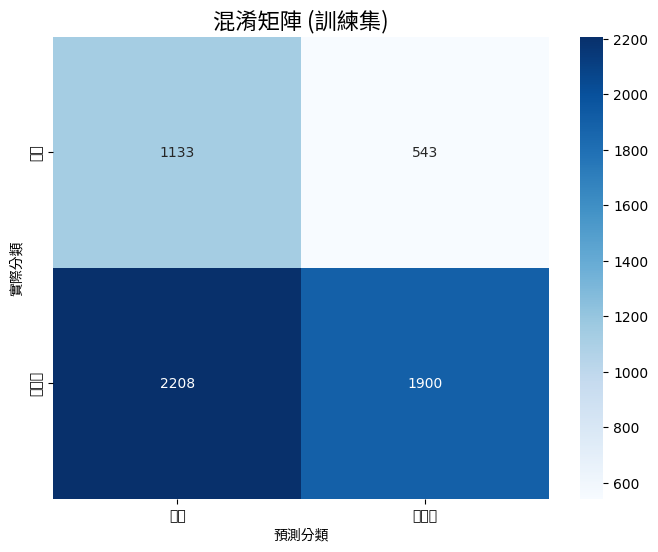

              precision    recall  f1-score   support

           0       0.34      0.68      0.45      1676
           1       0.78      0.46      0.58      4108

    accuracy                           0.52      5784
   macro avg       0.56      0.57      0.52      5784
weighted avg       0.65      0.52      0.54      5784



In [ ]:
# 1. 確保只使用訓練時定義的 input_features
X_train_predict = X_train[input_features_6]

# 2. 進行預測 (這行就不會報錯了)
y_pred = model_6.predict(X_train_predict)

# 3. 繪製混淆矩陣
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['廢止', '營運中'],
            yticklabels=['廢止', '營運中'])

# 套用你的中文字體
plt.title('混淆矩陣 (訓練集)', fontproperties=custom_font, fontsize=16)
plt.xlabel('預測分類', fontproperties=custom_font)
plt.ylabel('實際分類', fontproperties=custom_font)
plt.show()

# 4. 印出詳細報告
# from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

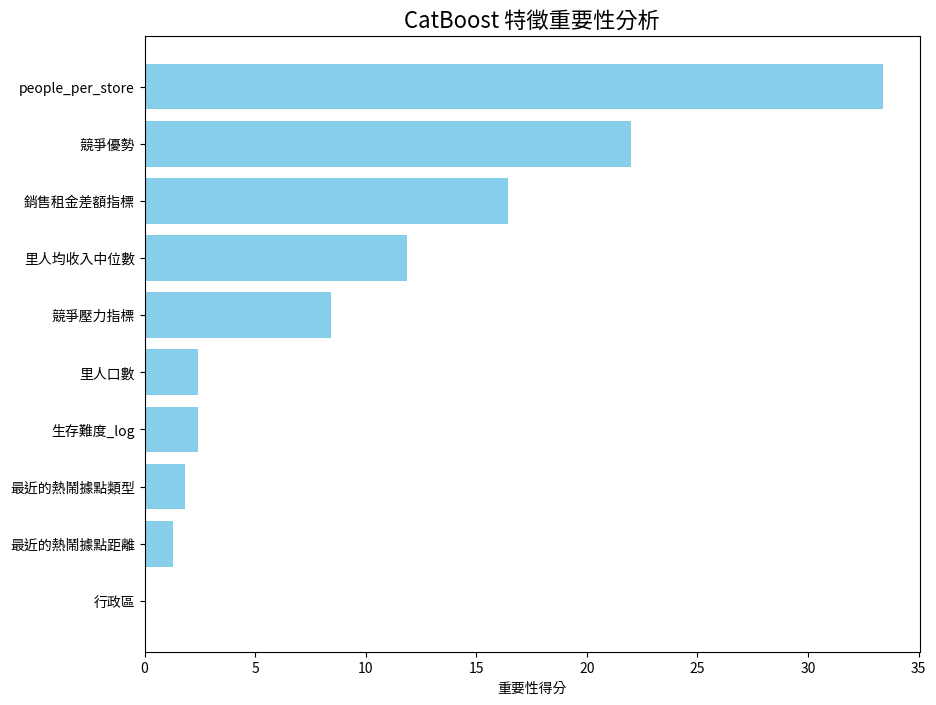

In [ ]:
import pandas as pd
import numpy as np

# 1. 取得特徵重要性
feature_importance = model_6.get_feature_importance()

# 修正點：直接從 model 中獲取訓練時使用的特徵名稱
feature_names = model_6.feature_names_

# 2. 建立 DataFrame
data = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
data = data.sort_values(by='importance', ascending=True)

# --- 以下繪圖程式碼保持不變 ---
plt.figure(figsize=(10, 8))
plt.barh(data['feature'], data['importance'], color='skyblue')
plt.title('CatBoost 特徵重要性分析', fontproperties=custom_font, fontsize=16)
plt.yticks(fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.xlabel('重要性得分', fontproperties=custom_font)
plt.show()

In [ ]:
data.sort_values('importance', ascending=False)


,feature,importance
3,people_per_store,33.378444
8,競爭優勢,21.998831
9,銷售租金差額指標,16.422896
1,里人均收入中位數,11.886568
6,競爭壓力指標,8.426994
2,里人口數,2.411143
7,生存難度_log,2.397865
4,最近的熱鬧據點類型,1.804991
5,最近的熱鬧據點距離,1.272267
0,行政區,0.000000


In [ ]:
# 檢查不同分級的存活比例
print(df_ml.groupby('store_level')['target'].mean())

# 如果相關係數極高（例如 > 0.8），就要小心定義問題
print(df_ml[['競爭優勢', 'target']].corr())

store_level
Anchor          0.871665
C_Store         0.679472
HealthBeauty    0.775720
Name: target, dtype: float64
            競爭優勢    target
競爭優勢    1.000000 -0.006135
target -0.006135  1.000000


In [ ]:
# 篩選超商組
df_cstore = df_ml[df_ml['store_level'] == 'C_Store'].copy()

# 重新定義特徵 (移除 store_level，因為現在全是超商)
input_features_7 = [
    '行政區',
    '里人均收入中位數', '里人口數',
    'people_per_store',
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '競爭壓力指標',
    '生存難度_log',
    '競爭優勢',
    '銷售租金差額指標'
]

X_7 = df_cstore[input_features_7]
y_7 = df_cstore['target']

cat_features_7 = X_7.select_dtypes(include=['object', 'category']).columns.tolist()

X_train7, X_test7, y_train7, y_test7 = train_test_split(X_7, y_7, test_size=0.1, random_state=42)

model_7_cstore = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=100,
    early_stopping_rounds=100
)

model_7_cstore.fit(
    X_train7, y_train7,
    cat_features=cat_features_7,
    eval_set=(X_test7, y_test7),
    use_best_model=True
)

0:	test: 0.5916204	best: 0.5916204 (0)	total: 19.3ms	remaining: 38.7s
100:	test: 0.6427929	best: 0.6449844 (71)	total: 2.14s	remaining: 40.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6449844174
bestIteration = 71

Shrink model to first 72 iterations.


CatBoostClassifier(auto_class_weights='Balanced', depth=6, early_stopping_rounds=100, eval_metric='AUC', iterations=2000, learning_rate=0.01, random_seed=42, verbose=100)

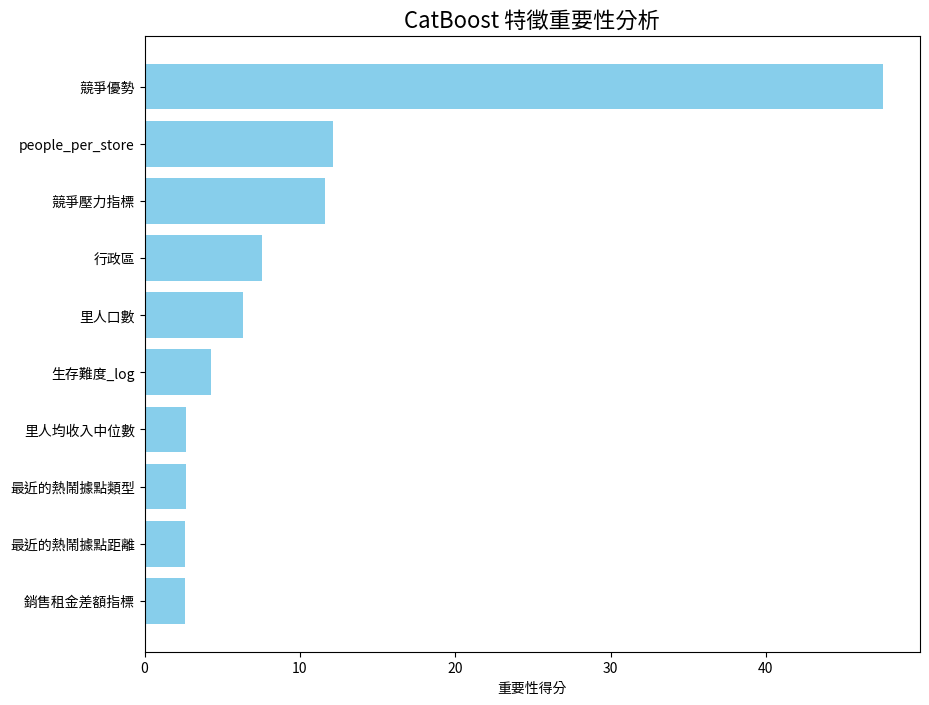

,feature,importance
8,競爭優勢,47.521903
3,people_per_store,12.121537
6,競爭壓力指標,11.642837
0,行政區,7.580615
2,里人口數,6.344190
7,生存難度_log,4.261052
1,里人均收入中位數,2.679591
4,最近的熱鬧據點類型,2.641959
5,最近的熱鬧據點距離,2.633441
9,銷售租金差額指標,2.572874


In [ ]:
import pandas as pd
import numpy as np

# 1. 取得特徵重要性
feature_importance = model_7_cstore.get_feature_importance()

# 修正點：直接從 model 中獲取訓練時使用的特徵名稱
feature_names = model_7_cstore.feature_names_

# 2. 建立 DataFrame
data = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
data = data.sort_values(by='importance', ascending=True)

# --- 以下繪圖程式碼保持不變 ---
plt.figure(figsize=(10, 8))
plt.barh(data['feature'], data['importance'], color='skyblue')
plt.title('CatBoost 特徵重要性分析', fontproperties=custom_font, fontsize=16)
plt.yticks(fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.xlabel('重要性得分', fontproperties=custom_font)
plt.show()

data.sort_values('importance', ascending=False)

## model_11：特徵歸一化版


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. 特徵工程：招式一「特徵歸一化」
# ---------------------------------------------------------
# 確保 store_level 已經定義好
def assign_store_level_v2(name):
    name = str(name)
    if any(keyword in name for keyword in ['全聯', '家福', '三商家購']):
        return 'Anchor'
    elif any(keyword in name for keyword in ['屈臣氏', '統一生活']):
        return 'HealthBeauty'
    else:
        return 'C_Store'

df_ml['store_level'] = df_ml['公司名稱'].apply(assign_store_level_v2)

# 選擇需要「根據品牌分級歸一化」的物理特徵
target_cols = ['people_per_store', '里人均收入中位數', '里人口數', '最近的熱鬧據點距離']

# 計算各組平均值並進行歸一化 (該店數值 / 同品牌等級平均值)
# 這樣會產生「相對人均服務人口」等特徵，數值 > 1 代表優於同業平均
for col in target_cols:
    group_mean = df_ml.groupby('store_level')[col].transform('mean')
    df_ml[f'rel_{col}'] = df_ml[col] / (group_mean + 1e-6) # 加個極小值防止除以 0

# ---------------------------------------------------------
# 2. 定義模型特徵清單
# ---------------------------------------------------------
# 我們保留原始 store_level，但使用歸一化後的物理特徵
input_features_11 = [
    'store_level',            # 品牌身份
    'rel_people_per_store',   # 相對人口紅利 (核心指標)
    'rel_里人均收入中位數',      # 相對消費力
    'rel_里人口數',            # 相對區域規模
    'rel_最近的熱鬧據點距離',    # 相對交通便利度
    '最近的熱鬧據點類型',       # 類別型
    '競爭優勢',                # 原有指標
    '競爭壓力指標',            # 原有指標
    '銷售租金差額指標',         # 你最強的衍生指標
    '生存難度_log'             # 複合指標

]

# ---------------------------------------------------------
# 3. 準備資料與訓練
# ---------------------------------------------------------
X = df_ml[input_features_11]
y = df_ml['target']

# 自動辨識類別欄位
cat_features_11 = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model_11 = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=10,
    eval_metric='AUC',
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=100,
    early_stopping_rounds=100
)

print("🚀 開始訓練 model_11 (歸一化特徵版)...")
model_11.fit(
    X_train, y_train,
    cat_features=cat_features_11,
    eval_set=(X_test, y_test),
    use_best_model=True
)

🚀 開始訓練 model_11 (歸一化特徵版)...
0:	test: 0.6476142	best: 0.6476142 (0)	total: 15ms	remaining: 30s
100:	test: 0.6696195	best: 0.6697960 (99)	total: 1.85s	remaining: 34.8s
200:	test: 0.6730430	best: 0.6730665 (199)	total: 3.45s	remaining: 30.9s
300:	test: 0.6736724	best: 0.6738371 (291)	total: 6.05s	remaining: 34.2s
400:	test: 0.6743194	best: 0.6748488 (370)	total: 8.77s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6748488271
bestIteration = 370

Shrink model to first 371 iterations.


CatBoostClassifier(auto_class_weights='Balanced', depth=6, early_stopping_rounds=100, eval_metric='AUC', iterations=2000, l2_leaf_reg=10, learning_rate=0.01, random_seed=42, verbose=100)

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 29151 (\N{CJK UNIFIED IDEOGRAPH-71DF}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missi

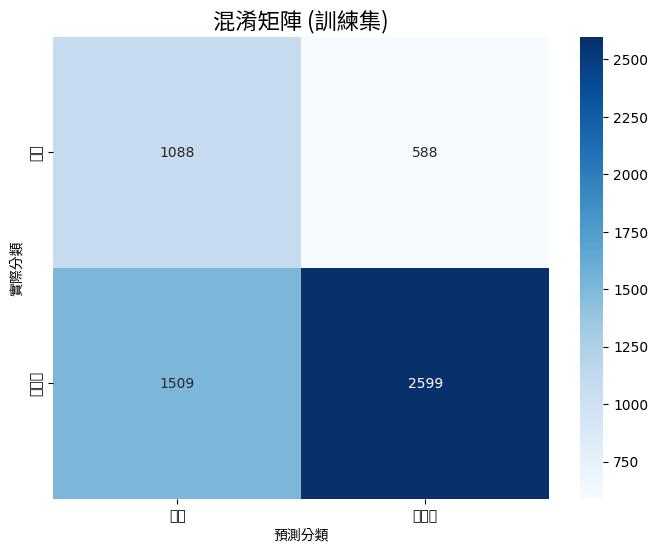

              precision    recall  f1-score   support

           0       0.42      0.65      0.51      1676
           1       0.82      0.63      0.71      4108

    accuracy                           0.64      5784
   macro avg       0.62      0.64      0.61      5784
weighted avg       0.70      0.64      0.65      5784



In [ ]:
# 1. 確保只使用訓練時定義的 input_features
X_train_predict = X_train[input_features_11]

# 2. 進行預測 (這行就不會報錯了)
y_pred = model_11.predict(X_train_predict)

# 3. 繪製混淆矩陣
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['廢止', '營運中'],
            yticklabels=['廢止', '營運中'])

# 套用你的中文字體
plt.title('混淆矩陣 (訓練集)', fontproperties=custom_font, fontsize=16)
plt.xlabel('預測分類', fontproperties=custom_font)
plt.ylabel('實際分類', fontproperties=custom_font)
plt.show()

# 4. 印出詳細報告
# from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

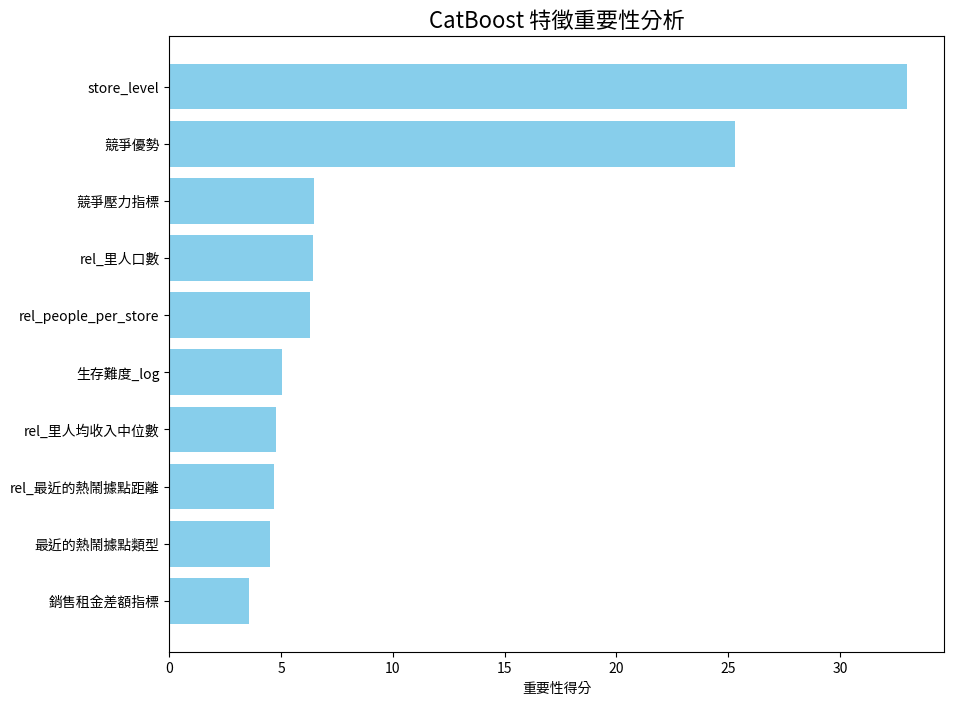

                feature  importance
0           store_level   33.015253
6                  競爭優勢   25.306994
7                競爭壓力指標    6.454289
3              rel_里人口數    6.409223
1  rel_people_per_store    6.300193
9              生存難度_log    5.029150
2          rel_里人均收入中位數    4.756820
4         rel_最近的熱鬧據點距離    4.668559
5             最近的熱鬧據點類型    4.505559
8              銷售租金差額指標    3.553959


In [ ]:
import pandas as pd
import numpy as np

# 1. 取得特徵重要性
feature_importance = model_11.get_feature_importance()

# 修正點：直接從 model 中獲取訓練時使用的特徵名稱
feature_names = model_11.feature_names_

# 2. 建立 DataFrame
data = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
data = data.sort_values(by='importance', ascending=True)

# --- 以下繪圖程式碼保持不變 ---
plt.figure(figsize=(10, 8))
plt.barh(data['feature'], data['importance'], color='skyblue')
plt.title('CatBoost 特徵重要性分析', fontproperties=custom_font, fontsize=16)
plt.yticks(fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.xlabel('重要性得分', fontproperties=custom_font)
plt.show()

data.sort_values('importance', ascending=False)
print(data.sort_values('importance', ascending=False))

## model_geo：純地理特徵版

In [ ]:
# ---------------------------------------------------------
# 1. 準備數據：延用 model_11 的歸一化特徵
# ---------------------------------------------------------
geo_features = [
    'rel_people_per_store', 'rel_里人均收入中位數', 'rel_里人口數',
    'rel_最近的熱鬧據點距離', '最近的熱鬧據點類型',
    '競爭優勢', '競爭壓力指標', '銷售租金差額指標', '生存難度_log'
]

# 自動辨識地理特徵中的類別欄位 (例如：最近的熱鬧據點類型)
cat_geo = X_train[geo_features].select_dtypes(include=['object', 'category']).columns.tolist()

# 步驟 A: 訓練一個「純地理模型」獲取基礎分 (Baseline)
# 修正：加入 cat_features 參數
model_geo = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    random_seed=42,
    verbose=0
)

# 訓練純地理模型
model_geo.fit(X_train[geo_features], y_train, cat_features=cat_geo)

# 取得訓練集與測試集的「基礎生存機率」(RawFormulaVal 是 logit 空間的值)
train_baseline = model_geo.predict(X_train[geo_features], prediction_type='RawFormulaVal')
test_baseline = model_geo.predict(X_test[geo_features], prediction_type='RawFormulaVal')

# ---------------------------------------------------------
# 2. 訓練 model_12：加入 store_level 作為殘差修正
# ---------------------------------------------------------
# 建立 Pool 時帶入 baseline
train_pool = Pool(
    data=X_train[['store_level']],
    label=y_train,
    cat_features=['store_level'],
    baseline=train_baseline.reshape(-1, 1) if train_baseline.ndim == 1 else train_baseline
)

test_pool = Pool(
    data=X_test[['store_level']],
    label=y_test,
    cat_features=['store_level'],
    baseline=test_baseline.reshape(-1, 1) if test_baseline.ndim == 1 else test_baseline
)

model_12 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=4,
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

print("🚀 開始訓練 model_12 (殘差學習版)...")
model_12.fit(train_pool, eval_set=test_pool, use_best_model=True)

🚀 開始訓練 model_12 (殘差學習版)...
0:	test: 0.6085210	best: 0.6085210 (0)	total: 4.77ms	remaining: 2.38s
100:	test: 0.6447319	best: 0.6447319 (100)	total: 460ms	remaining: 1.82s
200:	test: 0.6479083	best: 0.6479318 (193)	total: 936ms	remaining: 1.39s
300:	test: 0.6479436	best: 0.6481318 (245)	total: 1.39s	remaining: 917ms
400:	test: 0.6481671	best: 0.6482142 (373)	total: 1.86s	remaining: 460ms
499:	test: 0.6481200	best: 0.6482730 (441)	total: 2.31s	remaining: 0us

bestTest = 0.6482729818
bestIteration = 441

Shrink model to first 442 iterations.


CatBoostClassifier(depth=4, eval_metric='AUC', iterations=500, learning_rate=0.01, random_seed=42, verbose=100)

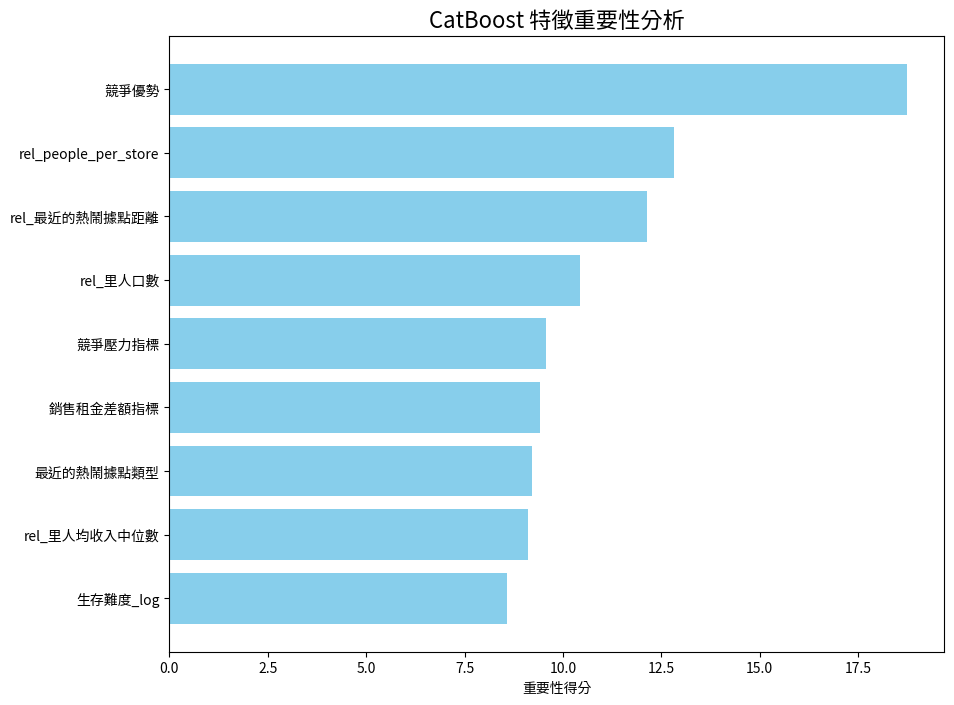

,feature,importance
5,競爭優勢,18.752896
0,rel_people_per_store,12.809889
3,rel_最近的熱鬧據點距離,12.133561
2,rel_里人口數,10.432432
6,競爭壓力指標,9.558613
7,銷售租金差額指標,9.414637
4,最近的熱鬧據點類型,9.205791
1,rel_里人均收入中位數,9.104261
8,生存難度_log,8.587918


In [ ]:
import pandas as pd
import numpy as np

# 1. 取得特徵重要性
feature_importance = model_geo.get_feature_importance()

# 修正點：直接從 model 中獲取訓練時使用的特徵名稱
feature_names = model_geo.feature_names_

# 2. 建立 DataFrame
data = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
data = data.sort_values(by='importance', ascending=True)

# --- 以下繪圖程式碼保持不變 ---
plt.figure(figsize=(10, 8))
plt.barh(data['feature'], data['importance'], color='skyblue')
plt.title('CatBoost 特徵重要性分析', fontproperties=custom_font, fontsize=16)
plt.yticks(fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.xlabel('重要性得分', fontproperties=custom_font)
plt.show()

data.sort_values('importance', ascending=False)

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 29151 (\N{CJK UNIFIED IDEOGRAPH-71DF}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missi

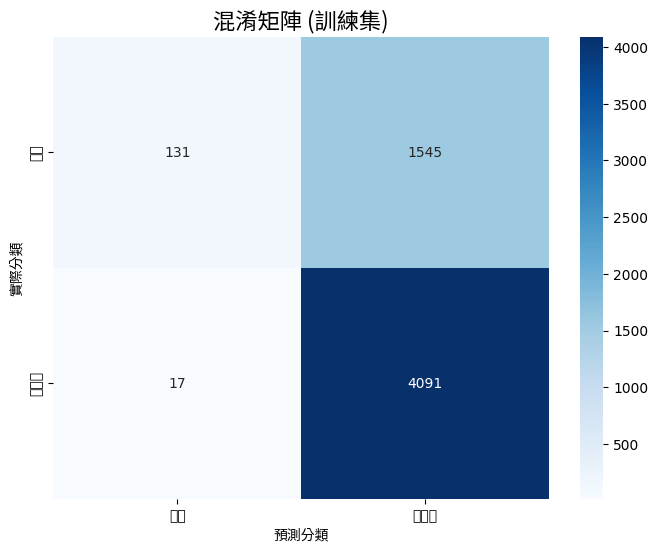

              precision    recall  f1-score   support

           0       0.89      0.08      0.14      1676
           1       0.73      1.00      0.84      4108

    accuracy                           0.73      5784
   macro avg       0.81      0.54      0.49      5784
weighted avg       0.77      0.73      0.64      5784



In [ ]:
# 1. 確保只使用訓練時定義的 input_features
X_train_predict = X_train[geo_features]

# 2. 進行預測 (這行就不會報錯了)
y_pred = model_geo.predict(X_train_predict)

# 3. 繪製混淆矩陣
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['廢止', '營運中'],
            yticklabels=['廢止', '營運中'])

# 套用你的中文字體
plt.title('混淆矩陣 (訓練集)', fontproperties=custom_font, fontsize=16)
plt.xlabel('預測分類', fontproperties=custom_font)
plt.ylabel('實際分類', fontproperties=custom_font)
plt.show()

# 4. 印出詳細報告
# from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

In [ ]:
# 獲取預測機率
probs = model_geo.predict_proba(X_test[geo_features])[:, 1]

# 手動設定高門檻 (例如 0.75)
y_pred_custom = (probs > 0.75).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.33      0.78      0.46       186
           1       0.80      0.35      0.49       457

    accuracy                           0.48       643
   macro avg       0.56      0.57      0.48       643
weighted avg       0.66      0.48      0.48       643



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# 1. 執行預測 (預設門檻 0.5)
# 注意：predict 會自動考慮 Pool 內的 baseline
y_pred_12 = model_12.predict(test_pool)

# 2. 取得預測機率 (用於計算 AUC)
y_prob_12 = model_12.predict_proba(test_pool)[:, 1]

# 3. 產出評估報告
print("===== model_12 (地理基礎 + 品牌殘差修正) 評估報告 =====")
print(classification_report(y_test, y_pred_12))

# 4. 計算 AUC
auc_score = roc_auc_score(y_test, y_prob_12)
print(f"最終模型 AUC: {auc_score:.4f}")

# 5. 製作混淆矩陣 (可選，幫助看錯殺比例)
conf_matrix = confusion_matrix(y_test, y_pred_12)
cm_df = pd.DataFrame(conf_matrix,
                     index=['實際廢止(0)', '實際營運(1)'],
                     columns=['預測廢止(0)', '預測營運(1)'])
print("\n===== 混淆矩陣 =====")
print(cm_df)

===== model_12 (地理基礎 + 品牌殘差修正) 評估報告 =====
              precision    recall  f1-score   support

           0       0.44      0.04      0.07       186
           1       0.71      0.98      0.83       457

    accuracy                           0.71       643
   macro avg       0.58      0.51      0.45       643
weighted avg       0.63      0.71      0.61       643

最終模型 AUC: 0.6483

===== 混淆矩陣 =====
         預測廢止(0)  預測營運(1)
實際廢止(0)        7      179
實際營運(1)        9      448


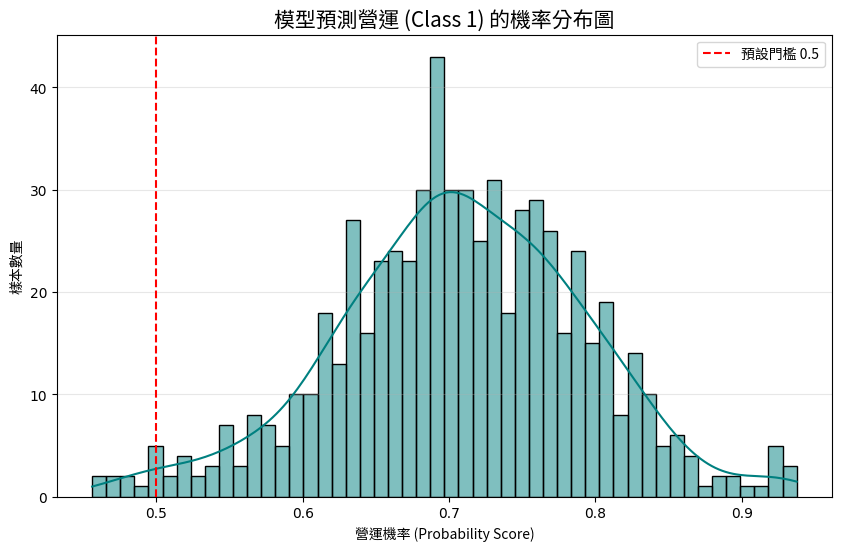

count    643.000000
mean       0.707715
std        0.085137
min        0.456170
10%        0.603259
25%        0.655938
50%        0.707326
75%        0.765261
90%        0.811565
max        0.937516
dtype: float64


In [ ]:
# @title
# import matplotlib.pyplot as plt
# import seaborn as sns

# 取得預測機率
y_probs = model_geo.predict_proba(X_test[geo_features])[:, 1]

plt.figure(figsize=(10, 6))
sns.histplot(y_probs, bins=50, kde=True, color='teal')
plt.axvline(x=0.5, color='red', linestyle='--', label='預設門檻 0.5')
plt.title('模型預測營運 (Class 1) 的機率分布圖', fontproperties=custom_font, fontsize=15)
plt.xlabel('營運機率 (Probability Score)', fontproperties=custom_font)
plt.ylabel('樣本數量', fontproperties=custom_font)
plt.legend(prop=custom_font)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 輸出分位數統計
import pandas as pd
print(pd.Series(y_probs).describe(percentiles=[.1, .25, .5, .75, .9]))

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 29105 (\N{CJK UNIFIED IDEOGRAPH-71B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 39719 (\N{CJK UNIFIED IDEOGRAPH-9B27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Gl

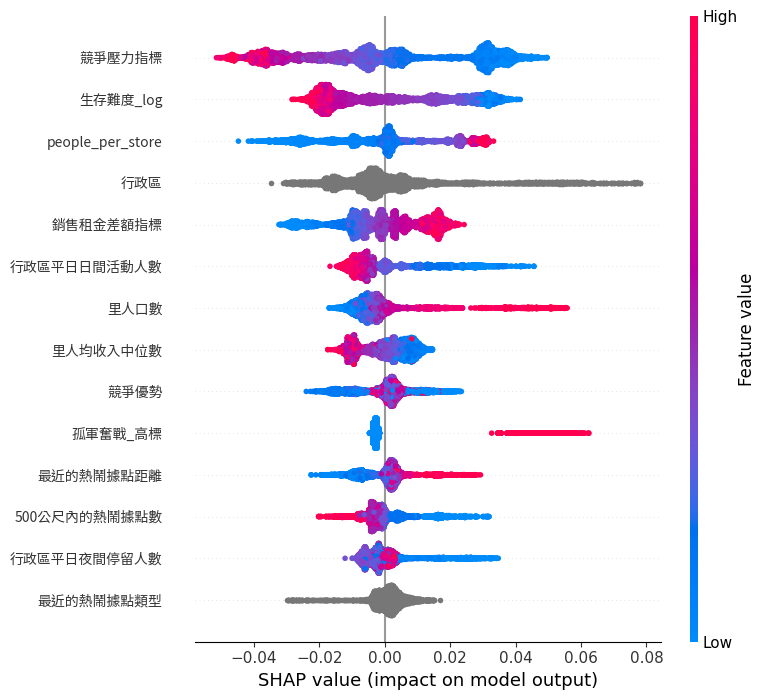

In [ ]:
# import shap
explainer = shap.TreeExplainer(model_4)
# 注意：這裡要傳入訓練時用的 X_train_predict (只含 input_features)
shap_values = explainer.shap_values(X_train[input_features])

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train[input_features], show=False)
for text in plt.gcf().axes[0].get_yticklabels():
    text.set_fontproperties(custom_font)
plt.show()

In [ ]:
# 取得預測機率
X_eval = X_test[input_features]
probs = model_4.predict_proba(X_eval)[:, 1]

# 找出「模型信心最高但預測錯誤」的營運店舖 (False Positives)
analysis_df = X_test.copy()
analysis_df['prob'] = probs
analysis_df['actual'] = y_test
error_cases = analysis_df[(analysis_df['actual'] == 0)].sort_values(by='prob', ascending=False).head(10)

print("被模型高度誤判為會營運，但實際廢止的店舖特徵：")
print(error_cases[['行政區', '銷售租金差額指標', '競爭優勢', 'prob']])

被模型高度誤判為會營運，但實際廢止的店舖特徵：
      行政區   銷售租金差額指標      競爭優勢      prob
5216  五股區  77.910611  0.500000  0.573453
14    淡水區  40.957056  0.000000  0.562876
221   淡水區  57.885561  0.500000  0.555598
3365  林口區  33.393341  0.437500  0.553964
17    鶯歌區  53.886105  0.538462  0.545578
96    鶯歌區  53.886105  0.700000  0.541835
5448  樹林區  55.971371  1.000000  0.541473
2227  新店區  20.777657  0.500000  0.537613
4159  汐止區 -17.873191  0.000000  0.533019
5150  新店區  12.480084  0.833333  0.532185


In [ ]:
# 取得預測機率
X_eval = X_test[input_features]
probs = model.predict_proba(X_eval)[:, 1]

# 找出「模型信心最高但預測錯誤」的營運店舖 (False Positives)
analysis_df = X_test.copy()
analysis_df['prob'] = probs
analysis_df['actual'] = y_test
error_cases = analysis_df[(analysis_df['actual'] == 0)].sort_values(by='prob', ascending=False).head(10)

print("被模型高度誤判為會營運，但實際廢止的店舖特徵：")
print(error_cases[['行政區', '銷售租金差額指標', '競爭優勢', 'prob']])

被模型高度誤判為會營運，但實際廢止的店舖特徵：
      行政區   銷售租金差額指標      競爭優勢      prob
221   淡水區  57.885561  0.500000  0.518036
5150  新店區  12.480084  0.833333  0.511111
4302  土城區  32.683989  0.000000  0.510580
2776  中和區  33.107515  0.000000  0.510270
3365  林口區  33.393341  0.437500  0.509153
5216  五股區  77.910611  0.500000  0.508910
800   板橋區  32.450832  0.000000  0.506756
2227  新店區  20.777657  0.500000  0.506186
96    鶯歌區  53.886105  0.700000  0.506002
14    淡水區  40.957056  0.000000  0.505977


--- 門檻調高至 0.55 的評估報告 ---
              precision    recall  f1-score   support

           0       0.29      1.00      0.45       186
           1       0.00      0.00      0.00       457

    accuracy                           0.29       643
   macro avg       0.14      0.50      0.22       643
weighted avg       0.08      0.29      0.13       643



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/seaborn/u

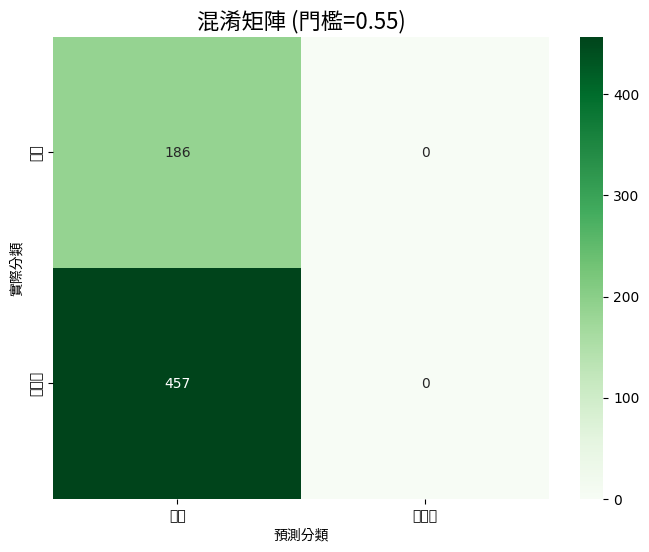

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. 獲取預測機率（取第 1 欄，即標籤為 1 '營運中' 的機率）
y_probs = model.predict_proba(X_test[input_features])[:, 1]

# 2. 設定新門檻（從預設 0.5 調升至 0.55）
custom_threshold = 0.55
y_pred_custom = (y_probs >= custom_threshold).astype(int)

# 3. 印出新的評估報告
print(f"--- 門檻調高至 {custom_threshold} 的評估報告 ---")
print(classification_report(y_test, y_pred_custom))

# 4. 繪製新的混淆矩陣
plt.figure(figsize=(8, 6))
cm_custom = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Greens',
            xticklabels=['廢止', '營運中'],
            yticklabels=['廢止', '營運中'])

plt.title(f'混淆矩陣 (門檻={custom_threshold})', fontproperties=custom_font, fontsize=16)
plt.xlabel('預測分類', fontproperties=custom_font)
plt.ylabel('實際分類', fontproperties=custom_font)
plt.show()

In [ ]:
# 查看訓練集與測試集的 AUC
print(f"Train AUC: {model.get_evals_result()['learn']['AUC'][-1]}")
print(f"Test AUC: {model.get_evals_result()['validation']['AUC'][-1]}")

KeyError: 'AUC'

# 最終模型比較

### model_v5 & model_v8


In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/train_data_v1.3.csv', encoding='utf-8', index_col=False)
df_test = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/test_data_v1.3.csv', encoding='utf-8', index_col=False)

In [ ]:
import xgboost as xgb
import pandas as pd

# 1. 定義目標變數：營運中為 1，其餘（歇業/廢止）為 0
df_train['target'] = (df_train['登記現況'] == '營運中').astype(int)

# 2. 指定類別型特徵 (XGBoost 支援原生類別格式)
cat_features = ['最近熱鬧據點類型', '縣市', '行政區']
for col in cat_features:
    df_train[col] = df_train[col].astype('category')

# --- B. 定義特徵清單 ---
features_v5 = [
    '是否便利商店', '歷史品牌優勢', '店均服務人口數', '區域競爭飽和度',
    '里人均收入中位數', '發票銷售額指標', '行政區平日日間活動人數', '日夜人流差',
    '最近熱鬧據點類型', '最近熱鬧據點距離', '租金log', '里人口數', '發票張數指標'
]

features_v8 = [
    '最近鄰店距離', '鄰近道路等級', '最近路口距離', '路口與巷弄權重',
    '黃金三角窗', '歷史品牌優勢', '區域競爭飽和度', '店均服務人口數',
    '發票銷售額指標', '租金log', '里人均收入中位數', '店均電信人流', '日夜人流差'
]

# --- A. 準備資料與切分 ---
df_run = df_train.copy()
y = (df_run['登記現況'] == '營運中').astype(int)

# 處理類別型欄位
cat_cols = ['最近熱鬧據點類型']
for col in cat_cols:
    df_run[col] = df_run[col].astype('category')

In [ ]:
# @title
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# --- A. 準備資料與切分 ---
df_run = df_train.copy()
y = (df_run['登記現況'] == '營運中').astype(int)

# 處理類別型欄位
cat_cols = ['最近熱鬧據點類型']
for col in cat_cols:
    df_run[col] = df_run[col].astype('category')

# --- B. 定義特徵清單 ---
features_v5 = [
    '是否便利商店', '歷史品牌優勢', '店均服務人口數', '區域競爭飽和度',
    '里人均收入中位數', '發票銷售額指標', '行政區平日日間活動人數', '日夜人流差',
    '最近熱鬧據點類型', '最近熱鬧據點距離', '租金log', '里人口數', '發票張數指標'
]

features_v8 = [
    '最近鄰店距離', '鄰近道路等級', '最近路口距離', '路口與巷弄權重',
    '黃金三角窗', '歷史品牌優勢', '區域競爭飽和度', '店均服務人口數',
    '發票銷售額指標', '租金log', '里人均收入中位數', '店均電信人流', '日夜人流差'
]

# --- C. 優化後的訓練函數 (防過擬合版) ---
def train_and_eval_robust(f_list, name):
    print(f"🚀 開始訓練 {name} (防過擬合配置)...")

    # 1. 切分訓練集與驗證集 (90/10)
    X_train, X_val, y_train, y_val = train_test_split(
        df_run[f_list], y, test_size=0.1, random_state=100, stratify=y
    )

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

    # 2. 加入防過擬合參數
    params = {
        'objective': 'binary:logistic',
        'max_depth': 4,              # 降低深度：防止過度細分地理特徵
        'learning_rate': 0.05,
        'gamma': 1.0,                 # 懲罰分裂：節點必須顯著降低 Loss 才分裂
        'subsample': 0.8,             # 列採樣：每次迭代隨機選取 80% 資料
        'colsample_bytree': 0.8,      # 特徵採樣：避免模型過度依賴單一強勢特徵 (如市佔)
        'lambda': 1.5,                # L2 正規化：防止權重過大
        'alpha': 0.5,                 # L1 正規化：增加模型稀疏性
        'eval_metric': 'auc',
        'seed': 42
    }

    # 3. 執行訓練並加入 Early Stopping
    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,         # 設定高回合數，配合早停使用
        evals=evals,
        early_stopping_rounds=50,     # 連續 50 回合 AUC 沒進步就停止
        verbose_eval=False            # 保持輸出整潔
    )

    # 4. 在「驗證集」上評估真實戰力
    probs = model.predict(dval)
    preds = (probs > 0.5).astype(int)
    report = classification_report(y_val, preds, output_dict=True)

    return model, {
        "模型": name,
        "驗證集 AUC": round(roc_auc_score(y_val, probs), 4),
        "精確率 (Precision)": round(report['1']['precision'], 4),
        "召回率 (Recall)": round(report['1']['recall'], 4),
        "最佳迭代回合數": model.best_iteration
    }

# --- D. 執行重構 ---
model_v5_robust, stats_v5 = train_and_eval_robust(features_v5, "Model_V5 (旗艦版)")
model_v8_robust, stats_v8 = train_and_eval_robust(features_v8, "Model_V8 (避雷版)")

# --- E. 輸出結果 ---
print("\n📊 模型效能對照表 (驗證集結果)")
print(pd.DataFrame([stats_v5, stats_v8]).to_markdown(index=False))

🚀 開始訓練 Model_V5 (旗艦版) (防過擬合配置)...
🚀 開始訓練 Model_V8 (避雷版) (防過擬合配置)...

📊 模型效能對照表 (驗證集結果)
| 模型              |   驗證集 AUC |   精確率 (Precision) |   召回率 (Recall) |   最佳迭代回合數 |
|:------------------|-------------:|---------------------:|------------------:|-----------------:|
| Model_V5 (旗艦版) |       0.6557 |               0.7443 |            0.9365 |              119 |
| Model_V8 (避雷版) |       0.6643 |               0.7406 |            0.9497 |               50 |


In [ ]:
# 參數配置 (沿用你提供的 master_params_v5)
params_v5 = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4, # 👈 防禦型核心：提高對歇業風險的警覺
    'eval_metric': 'logloss',
    'random_state': 42
}

# 訓練 V5
dtrain_v5 = xgb.DMatrix(df_train[features_v5], label=y, enable_categorical=True)
model_v5_master = xgb.train(params_v5, dtrain_v5, num_boost_round=150)

# 參數配置 (與 V5 保持一致，以利公平對比)
params_v8 = params_v5.copy()
params_v8['max_depth'] = 5 # V8 結構較精簡，可稍微增加深度

# 訓練 V8
dtrain_v8 = xgb.DMatrix(df_train[features_v8], label=y, enable_categorical=True)
model_v8_master = xgb.train(params_v8, dtrain_v8, num_boost_round=150)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def master_diagnostic(model, f_list, name):
    print(f"\n🏆 {name} 最終評估報告")
    print("-" * 50)

    # 準備驗證數據 (與訓練時同樣的 split 邏輯)
    X_train, X_val, y_train, y_val = train_test_split(
        df_run[f_list], y, test_size=0.1, random_state=42, stratify=y
    )
    dval = xgb.DMatrix(X_val, enable_categorical=True)

    # 取得預測
    y_prob = model.predict(dval)
    y_pred = (y_prob > 0.5).astype(int)

    # 輸出指標
    auc = roc_auc_score(y_val, y_prob)
    print(f"Accuracy  : {np.mean(y_pred == y_val):.4f}")
    print(f"AUC Score : {auc:.4f}")

    print("\n" + "="*20 + " Classification Report " + "="*20)
    print(classification_report(y_val, y_pred))

    # 輸出特徵重要性 (Gain)
    importance = model.get_score(importance_type='gain')
    imp_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*20 + " Feature Importance (Gain) " + "="*20)
    print(imp_df.head(10).to_markdown(index=False))
    return imp_df

# 執行兩版的深度診斷
importance_v5 = master_diagnostic(model_v5_master, features_v5, "Model_V5 (旗艦版)")
importance_v8 = master_diagnostic(model_v8_master, features_v8, "Model_V8 (避雷版)")


🏆 Model_V5 (旗艦版) 最終評估報告
--------------------------------------------------
Accuracy  : 0.7138
AUC Score : 0.8017

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.50      0.71      0.59       186
           1       0.86      0.72      0.78       457

    accuracy                           0.71       643
   macro avg       0.68      0.71      0.68       643
weighted avg       0.76      0.71      0.73       643


==================== Feature Importance (Gain) ====================
| Feature                |   Importance |
|:-----------------------|-------------:|
| 是否便利商店           |     16.1314  |
| 歷史品牌優勢           |      7.10923 |
| 店均服務人口數         |      4.74121 |
| 區域競爭飽和度         |      4.46197 |
| 日夜人流差             |      3.97305 |
| 里人均收入中位數       |      3.57355 |
| 發票銷售額指標         |      3.44579 |
| 行政區平日日間活動人數 |      3.38686 |
| 最近熱鬧據點類型       |      3.38477 |
| 租金log                |    

In [ ]:
def get_shap_logic_table(model, X_input, features, name):
    # 確保類別型欄位已轉換，避免計算出錯
    X_shap = X_input[features].copy()
    for col in X_shap.select_dtypes(['category', 'object']).columns:
        X_shap[col] = X_shap[col].astype('category').cat.codes

    # 初始化解釋器
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    # 分解正負向
    pos_push = []
    neg_pull = []
    for i in range(len(features)):
        vals = shap_values[:, i]
        pos_push.append(vals[vals > 0].mean() if len(vals[vals > 0]) > 0 else 0)
        neg_pull.append(vals[vals < 0].mean() if len(vals[vals < 0]) > 0 else 0)

    res = pd.DataFrame({
        '特徵名稱': features,
        '總體影響力': np.abs(shap_values).mean(axis=0),
        '推薦推力 (+)': pos_push,
        '避雷拉力 (-)': neg_pull
    }).sort_values('總體影響力', ascending=False)

    return res

# 執行分析
shap_table_v5 = get_shap_logic_table(model_v5_master, df_run, features_v5, "V5")
shap_table_v8 = get_shap_logic_table(model_v8_master, df_run, features_v8, "V8")

print("🏆 Model_V5 (旗艦版) SHAP 決策邏輯")
print(shap_table_v5.to_markdown(index=False))
print("\n" + "="*80 + "\n")
print("🛡️ Model_V8 (避雷版) SHAP 決策邏輯")
print(shap_table_v8.to_markdown(index=False))

🏆 Model_V5 (旗艦版) SHAP 決策邏輯
| 特徵名稱               |   總體影響力 |   推薦推力 (+) |   避雷拉力 (-) |
|:-----------------------|-------------:|---------------:|---------------:|
| 是否便利商店           |    0.290737  |      1.02729   |     -0.0981779 |
| 歷史品牌優勢           |    0.249354  |      0.16178   |     -0.374092  |
| 店均服務人口數         |    0.126643  |      0.160025  |     -0.0964559 |
| 區域競爭飽和度         |    0.114829  |      0.159014  |     -0.0855776 |
| 最近熱鬧據點距離       |    0.108695  |      0.105233  |     -0.113781  |
| 發票張數指標           |    0.0734461 |      0.0975069 |     -0.056237  |
| 里人均收入中位數       |    0.0715535 |      0.0716508 |     -0.0714348 |
| 行政區平日日間活動人數 |    0.0550067 |      0.0669356 |     -0.0449871 |
| 最近熱鬧據點類型       |    0.0545414 |      0.101186  |     -0.0365634 |
| 里人口數               |    0.0505579 |      0.0606327 |     -0.0412464 |
| 租金log                |    0.0502206 |      0.0513535 |     -0.048567  |
| 日夜人流差             |    0.0415946 |      0.0397424 |     -0.0442738 |
| 發票

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import numpy as np

def perform_cross_validation(f_list, name, params):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = []
    precision_scores = []
    recall_0_scores = [] # 避雷成功率 (捕捉歇業店的機率)

    X = df_train[f_list]
    y = (df_train['登記現況'] == '營運中').astype(int)

    for train_index, val_index in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

        # 轉換為 DMatrix
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv, enable_categorical=True)
        dval = xgb.DMatrix(X_val_cv, enable_categorical=True)

        # 訓練
        model = xgb.train(params, dtrain, num_boost_round=150)

        # 預測
        probs = model.predict(dval)
        preds = (probs > 0.5).astype(int)

        # 計算指標
        auc_scores.append(roc_auc_score(y_val_cv, probs))
        precision_scores.append(precision_score(y_val_cv, preds))

        # 計算 Recall 0 (歇業店被正確標記為 0 的比例)
        rec_0 = recall_score(y_val_cv, preds, pos_label=0)
        recall_0_scores.append(rec_0)

    return {
        "模型": name,
        "平均 AUC": f"{np.mean(auc_scores):.4f} (±{np.std(auc_scores):.3f})",
        "平均 Precision": f"{np.mean(precision_scores):.4f} (±{np.std(precision_scores):.3f})",
        "平均 避雷捕捉率 (R0)": f"{np.mean(recall_0_scores):.4f} (±{np.std(recall_0_scores):.3f})"
    }

# 執行 CV
cv_results = [
    perform_cross_validation(features_v5, "Model_V5 (旗艦版)", params_v5),
    perform_cross_validation(features_v8, "Model_V8 (避雷版)", params_v8)
]

print("📊 5-Fold 交叉驗證穩定性報告")
print(pd.DataFrame(cv_results).to_markdown(index=False))

📊 5-Fold 交叉驗證穩定性報告
| 模型              | 平均 AUC        | 平均 Precision   | 平均 避雷捕捉率 (R0)   |
|:------------------|:----------------|:-----------------|:-----------------------|
| Model_V5 (旗艦版) | 0.6544 (±0.009) | 0.7838 (±0.007)  | 0.5703 (±0.019)        |
| Model_V8 (避雷版) | 0.6565 (±0.016) | 0.7842 (±0.009)  | 0.5553 (±0.027)        |


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score

def run_blind_experiment(model, eval_df, f_list, name):
    # --- 1. 原始測試 (Baseline) ---
    X_test = eval_df[f_list].copy()
    y_test = (eval_df['登記現況'] == '營運中').astype(int)
    for col in X_test.select_dtypes(['category', 'object']).columns:
        X_test[col] = X_test[col].astype('category')

    dtest_orig = xgb.DMatrix(X_test, enable_categorical=True)
    probs_orig = model.predict(dtest_orig)
    auc_orig = roc_auc_score(y_test, probs_orig)

    # --- 2. 脫標籤測試 (Blinded) ---
    X_test_blind = X_test.copy()
    # 強制將最強特徵歸零
    if '是否便利商店' in X_test_blind.columns:
        X_test_blind['是否便利商店'] = 0

    dtest_blind = xgb.DMatrix(X_test_blind, enable_categorical=True)
    probs_blind = model.predict(dtest_blind)
    auc_blind = roc_auc_score(y_test, probs_blind)

    # --- 3. 計算 Precision (以 0.5 為門檻) ---
    # 這裡可以看當沒有標籤加持時，模型是否還敢推薦點位
    preds_blind = (probs_blind > 0.5).astype(int)
    # 如果模型完全不敢推薦，precision 會難以計算，給予 0
    prec_blind = precision_score(y_test, preds_blind, zero_division=0)

    return {
        "實驗模型": name,
        "原始 AUC (有標籤)": round(auc_orig, 4),
        "脫標籤 AUC (盲測)": round(auc_blind, 4),
        "AUC 衰減率": f"{((auc_orig - auc_blind) / auc_orig)*100:.2f}%",
        "盲測推薦精確率 (P1)": round(prec_blind, 4)
    }

# 執行實驗
blind_v5 = run_blind_experiment(model_v5_master, df_test, features_v5, "Model_V5 (旗艦版)")

print("🧪 Model_V5 脫標籤（去品牌化）壓力測試結果")
print("-" * 60)
print(pd.DataFrame([blind_v5]).to_markdown(index=False))

🧪 Model_V5 脫標籤（去品牌化）壓力測試結果
------------------------------------------------------------
| 實驗模型          |   原始 AUC (有標籤) |   脫標籤 AUC (盲測) | AUC 衰減率   |   盲測推薦精確率 (P1) |
|:------------------|--------------------:|--------------------:|:-------------|----------------------:|
| Model_V5 (旗艦版) |              0.6692 |              0.5568 | 16.79%       |                0.7209 |


# 測試集

## XGBOOST


### model_v5測試

In [ ]:
# ==========================================
# 0. 測試集預處理：型別轉換強化版
# ==========================================
df_test_ready = df_test.dropna().copy()

# 建立標籤與租金特徵
if 'target' not in df_test_ready.columns:
    df_test_ready['target'] = df_test_ready['登記現況'].map({'營運中': 1, '廢止': 0})
if '租金' in df_test_ready.columns and '租金_log' not in df_test_ready.columns:
    df_test_ready['租金_log'] = np.log1p(df_test_ready['租金'])
if '行政區平日日間活動人數' in df_test_ready.columns and '行政區平日夜間停留人數' in df_test_ready.columns:
    df_test_ready['日夜人流差'] = df_test_ready['行政區平日日間活動人數'] - df_test_ready['行政區平日夜間停留人數']

# 🚀 關鍵修正：將 object 型態轉換為 category
for col in ['最近的熱鬧據點類型']: # 若還有其他文字欄位可加入此清單
    if col in df_test_ready.columns:
        df_test_ready[col] = df_test_ready[col].astype('category')

y_test = df_test_ready['target']

# --- 重新定義執行評估 ---
def evaluate_on_test_fixed(model, features, df_source, version_name):
    # 準備 DMatrix
    dtest = xgb.DMatrix(df_source[features], enable_categorical=True)
    probs = model.predict(dtest)

    preds = []
    is_cvs = df_source['是否便利商店'].values
    for i in range(len(probs)):
        t = 0.5 if is_cvs[i] == 1 else 0.7
        preds.append(1 if probs[i] >= t else 0)
    preds = np.array(preds)

    print(f"\n" + "█"*65)
    print(f"📊 測試集最終對抗：{version_name}")
    print("█"*65)

    for g_val, g_name in [(0, "超市藥妝組 (門檻 0.7)"), (1, "便利商店組 (門檻 0.5)")]:
        mask = (is_cvs == g_val)
        if mask.any():
            y_t = y_test[mask]
            y_p = preds[mask]

            # 指標計算
            acc = accuracy_score(y_t, y_p)
            rec0 = recall_score(y_t, y_p, pos_label=0)
            prec1 = precision_score(y_t, y_p, pos_label=1)

            print(f"\n【{g_name}】")
            print(f"  ● 樣本數: {len(y_t)} 筆")
            print(f"  ● 推薦率: {(y_p == 1).sum()/len(y_t):.1%} | 避險率: {(y_p == 0).sum()/len(y_t):.1%}")
            print(f"  ● Accuracy (準確率)   : {acc:.2%}")
            print(f"  ● Recall 0 (避雷率)  : {rec0:.2%}")
            print(f"  ● Precision 1 (信心度) : {prec1:.2%}")

In [ ]:
# ==========================================
# 1. 修正特徵清單順序 (嚴格對齊模型期待)
# ==========================================

# 修正後的 V1 (依照報錯訊息中的 expected 順序)
features_v1 = [
    '是否便利商店', '里人均收入中位數', '里人口數', '發票張數指標',
    '發票銷售額指標', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
    '500公尺外部競爭(不同公司店數)', '租金', 'people_per_store', '競爭優勢'
]

# 修正後的 V3 (請確保與 final_model_master 訓練時順序一致)
# 通常建議直接從模型抓取：features_v3 = final_model_master.feature_names
features_v3 = final_model_master.feature_names

# 修正後的 V5 (請確保與 final_model_v5 訓練時順序一致)
features_v5 = final_model_v5.feature_names

# ==========================================
# 2. 再次執行測試集對抗
# ==========================================

# 評估版本一
evaluate_on_test_fixed(final_model, features_v1, df_test_ready, "版本一：原始加權防禦版")

# 評估版本三
evaluate_on_test_fixed(final_model_master, features_v3, df_test_ready, "版本三：Master 精準狙擊版")

# 評估版本五
evaluate_on_test_fixed(final_model_v5, features_v5, df_test_ready, "版本五：日夜動態旗艦版")


█████████████████████████████████████████████████████████████████
📊 測試集最終對抗：版本一：原始加權防禦版
█████████████████████████████████████████████████████████████████

【超市藥妝組 (門檻 0.7)】
  ● 樣本數: 134 筆
  ● 推薦率: 56.7% | 避險率: 43.3%
  ● Accuracy (準確率)   : 60.45%
  ● Recall 0 (避雷率)  : 63.16%
  ● Precision 1 (信心度) : 90.79%

【便利商店組 (門檻 0.5)】
  ● 樣本數: 581 筆
  ● 推薦率: 50.9% | 避險率: 49.1%
  ● Accuracy (準確率)   : 60.59%
  ● Recall 0 (避雷率)  : 64.89%
  ● Precision 1 (信心度) : 77.70%

█████████████████████████████████████████████████████████████████
📊 測試集最終對抗：版本三：Master 精準狙擊版
█████████████████████████████████████████████████████████████████

【超市藥妝組 (門檻 0.7)】
  ● 樣本數: 134 筆
  ● 推薦率: 57.5% | 避險率: 42.5%
  ● Accuracy (準確率)   : 61.19%
  ● Recall 0 (避雷率)  : 63.16%
  ● Precision 1 (信心度) : 90.91%

【便利商店組 (門檻 0.5)】
  ● 樣本數: 581 筆
  ● 推薦率: 51.3% | 避險率: 48.7%
  ● Accuracy (準確率)   : 58.52%
  ● Recall 0 (避雷率)  : 61.17%
  ● Precision 1 (信心度) : 75.50%

█████████████████████████████████████████████████████████████████
📊 測試集最終對抗：版本五：

### model_v7.1測試

In [ ]:
df_test_v7 = pd.read_csv('/content/drive/MyDrive/【課程】Python數據分析/團體專題/資料訓練表/test_data_v1.3.csv', encoding='utf-8', index_col=False)

In [ ]:
def apply_feature_engineering_v7_1(input_df):
    df_out = input_df.copy()

    # 1. 核心數值轉換
    df_out['日夜人流差'] = df_out['行政區平日日間活動人數'] - df_out['行政區平日夜間停留人數']
    df_out['租金_log'] = np.log1p(df_out['租金'])

    # 2. 如果你的原始測試集中還沒有這些微觀指標，需在這裡補上 (假設已經預處理好)
    # 若微觀指標 (如 micro_loc_risk) 已在 df 中，則直接選取

    final_features = [
        'id', 'dist_to_nearest_neighbor', 'road_level', 'dist_to_inter',
        'micro_loc_risk', 'is_premium_corner',
        '競爭優勢', '競爭壓力指標', 'people_per_store',
        '發票銷售額指標', '租金_log', '里人均收入中位數',
        'effective_flow_share', '日夜人流差', '是否便利商店' # 帶上業態標籤做動態門檻
    ]

    return df_out[final_features]

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

# 1. 複製原始測試集，避免改動到備份
df_test_71 = df_test_v7.copy()

# 2. 重新執行特徵工程 (對齊 V7.1 邏輯)
# 計算「絕對差值」以捕捉商圈潮汐效應
df_test_71['日夜人流差'] = df_test_71['行政區平日日間活動人數'] - df_test_71['行政區平日夜間停留人數']
# 執行租金平滑化
df_test_71['租金_log'] = np.log1p(df_test_71['租金'])

# 3. 定義 Model_v7.1 最終特徵清單
# 務必包含 'id' 用於對齊，以及 '是否便利商店' 用於動態門檻
final_features_v7_1 = [
    'dist_to_nearest_neighbor', 'road_level', 'dist_to_inter',
    'micro_loc_risk', 'is_premium_corner',
    '競爭優勢', '競爭壓力指標', 'people_per_store',
    '發票銷售額指標', '租金_log', '里人均收入中位數',
    'effective_flow_share', '日夜人流差'
]

# 4. 準備測試集矩陣
X_test_final = df_test_71[final_features_v7_1]
ids_test = df_test_71['id'] # 保留 ID 用於盲測診斷
types_test = df_test_71['是否便利商店'] # 保留業態標籤

# 如果你的 df_test 裡還沒有轉換 target，請執行這行 (假設 1 為營運, 0 為廢止)
y_test = df_test_71['登記現況'].apply(lambda x: 1 if '核准設立' in str(x) else 0)

# 5. 轉換為 XGBoost 矩陣
dtest_final = xgb.DMatrix(X_test_final)

print(f"✅ 測試集處理完成！共 {len(X_test_final)} 筆樣本。")
print(f"📍 特徵數量：{len(final_features_v7_1)} (已含日夜人流差、租金_log)")

✅ 測試集處理完成！共 715 筆樣本。
📍 特徵數量：13 (已含日夜人流差、租金_log)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 特徵重做 (日夜人流差、租金_log)
df_test_71 = df_test.copy()
df_test_71['日夜人流差'] = df_test_71['行政區平日日間活動人數'] - df_test_71['行政區平日夜間停留人數']
df_test_71['租金_log'] = np.log1p(df_test_71['租金'])

# 2. 定義 V7.1 核心特徵
final_features_v7_1 = [
    'dist_to_nearest_neighbor', 'road_level', 'dist_to_inter',
    'micro_loc_risk', 'is_premium_corner',
    '競爭優勢', '競爭壓力指標', 'people_per_store',
    '發票銷售額指標', '租金_log', '里人均收入中位數',
    'effective_flow_share', '日夜人流差'
]

# 3. 執行預測 (門檻 0.5)
dtest = xgb.DMatrix(df_test_71[final_features_v7_1])
df_test_71['v7.1_prob'] = model_v7_1.predict(dtest)
df_test_71['y_pred'] = (df_test_71['v7.1_prob'] >= 0.5).astype(int)

# 4. 準備 Target
df_test_71['y_true'] = df_test_71['登記現況'].apply(lambda x: 1 if '營運中' in str(x) or '核准設立' in str(x) else 0)

print("📊 Model v7.1 測試集最終評估 (門檻 0.5)")
print("="*60)
print(classification_report(df_test_71['y_true'], df_test_71['y_pred']))

# 分組觀察：便利商店 vs 非便利商店 的表現差異
for is_cvs in [1, 0]:
    group_name = "便利商店 (CVS)" if is_cvs == 1 else "非便利商店 (Non-CVS)"
    group_df = df_test_71[df_test_71['是否便利商店'] == is_cvs]
    acc = accuracy_score(group_df['y_true'], group_df['y_pred'])
    print(f"🔹 {group_name} 準確率: {acc:.2%}")

📊 Model v7.1 測試集最終評估 (門檻 0.5)
              precision    recall  f1-score   support

           0       0.41      0.57      0.47       207
           1       0.79      0.66      0.72       508

    accuracy                           0.63       715
   macro avg       0.60      0.62      0.60       715
weighted avg       0.68      0.63      0.65       715

🔹 便利商店 (CVS) 準確率: 62.48%
🔹 非便利商店 (Non-CVS) 準確率: 67.91%


In [ ]:
# 1. 執行雙軌決策邏輯
def dual_threshold_logic(row):
    if row['是否便利商店'] == 1:
        # 便利商店：嚴格避雷 (0.6)
        return 1 if row['v7.1_prob'] >= 0.60 else 0
    else:
        # 非便利商店：放寬救黑馬 (0.45)
        return 1 if row['v7.1_prob'] >= 0.45 else 0

df_test_71['y_pred_dual'] = df_test_71.apply(dual_threshold_logic, axis=1)

# 2. 產出分組指標
from sklearn.metrics import classification_report, accuracy_score

print("🚀 Model v7.1 測試集：雙軌動態門檻戰報 (CVS 0.6 / Non-CVS 0.45)")
print("="*70)
print(classification_report(df_test_71['y_true'], df_test_71['y_pred_dual']))

# 3. 業態分組準確率對照
for is_cvs in [1, 0]:
    name = "便利商店 (CVS)" if is_cvs == 1 else "非便利商店 (Non-CVS)"
    group = df_test_71[df_test_71['是否便利商店'] == is_cvs]
    acc = accuracy_score(group['y_true'], group['y_pred_dual'])
    print(f"🔹 {name} 準確率: {acc:.2%}")

🚀 Model v7.1 測試集：雙軌動態門檻戰報 (CVS 0.6 / Non-CVS 0.45)
              precision    recall  f1-score   support

           0       0.39      0.80      0.52       207
           1       0.86      0.49      0.62       508

    accuracy                           0.58       715
   macro avg       0.62      0.64      0.57       715
weighted avg       0.72      0.58      0.59       715

🔹 便利商店 (CVS) 準確率: 52.84%
🔹 非便利商店 (Non-CVS) 準確率: 79.10%


## CATBOOST

### model_11測試

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# 1. 在 df_test 中重建 store_level
df_test_final = df_test.copy()

# def assign_store_level_v2(name):
#     name = str(name)
#     if any(keyword in name for keyword in ['全聯', '家福', '三商家購']):
#         return 'Anchor'
#     elif any(keyword in name for keyword in ['屈臣氏', '統一生活']):
#         return 'HealthBeauty'
#     else:
#         return 'C_Store'

# 執行映射（關鍵步：確保測試集也有這張門票）
df_test_final['store_level'] = df_test_final['公司名稱'].apply(assign_store_level_v2)

# 2. 執行 Model_11 的特徵工程 (歸一化)
# 使用 df_ml (訓練集) 的統計量作為基準，避免 Data Leakage
target_cols = ['people_per_store', '里人均收入中位數', '里人口數', '最近的熱鬧據點距離']
group_means = df_ml.groupby('store_level')[target_cols].mean()

for col in target_cols:
    rel_col = f'rel_{col}'
    means_dict = group_means[col].to_dict()
    # 填入基準值
    base_mean = df_test_final['store_level'].map(means_dict).fillna(df_ml[col].mean())
    df_test_final[rel_col] = df_test_final[col] / (base_mean + 1e-6)

# Log 轉換與補齊
if 'target' not in df_test_final.columns:
    df_test_final['target'] = df_test_final['登記現況'].map({'營運中': 1, '廢止': 0})
if '生存難度' in df_test_final.columns:
    df_test_final['生存難度_log'] = np.log1p(df_test_final['生存難度'])
df_test_final['租金百分位'] = df_test_final['租金'].rank(pct=True) * 100
df_test_final['銷售租金差額指標'] = df_test_final['發票銷售額指標'] - df_test_final['租金百分位']

# 3. 定義模型輸入欄位 (必須與訓練時完全一致)
input_features_11 = [
    'store_level', 'rel_people_per_store', 'rel_里人均收入中位數', 'rel_里人口數',
    'rel_最近的熱鬧據點距離', '最近的熱鬧據點類型', '競爭優勢', '競爭壓力指標',
    '銷售租金差額指標', '生存難度_log'
]

X_test_11 = df_test_final.drop(['target', '登記現況'], axis=1) # 記得把原始標籤欄位也丟掉
y_test_actual = df_test_final['target']

# 4. 執行預測
X_test_11 = df_test_final[input_features_11]
y_test_actual = df_test_final['target']

y_pred_11 = model_11.predict(X_test_11)
y_prob_11 = model_11.predict_proba(X_test_11)[:, 1]

# 5. 輸出四大指標
print("🚀 Model_11 測試集 (df_test) 實戰指標彙整")
print("-" * 50)
print(f"{'準確度 (Accuracy)':25}: {accuracy_score(y_test_actual, y_pred_11):.4f}")
print(f"{'精確率 (Precision @ 1)':25}: {precision_score(y_test_actual, y_pred_11):.4f}")
print(f"{'召回率 (Recall @ 1)':25}: {recall_score(y_test_actual, y_pred_11):.4f}")
print(f"{'F1-Score (@ 1)':25}: {f1_score(y_test_actual, y_pred_11):.4f}")
print(f"{'實戰 AUC Score':25}: {roc_auc_score(y_test_actual, y_prob_11):.4f}")

🚀 Model_11 測試集 (df_test) 實戰指標彙整
--------------------------------------------------
準確度 (Accuracy)           : 0.6378
精確率 (Precision @ 1)      : 0.8302
召回率 (Recall @ 1)         : 0.6161
F1-Score (@ 1)           : 0.7073
實戰 AUC Score             : 0.6913



==================== 特徵重要性排行 ====================
                Feature  Importance
0           store_level   33.015253
6                  競爭優勢   25.306994
7                競爭壓力指標    6.454289
3              rel_里人口數    6.409223
1  rel_people_per_store    6.300193
9              生存難度_log    5.029150
2          rel_里人均收入中位數    4.756820
4         rel_最近的熱鬧據點距離    4.668559
5             最近的熱鬧據點類型    4.505559
8              銷售租金差額指標    3.553959


/tmp/ipython-input-3620304249.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31478 (\N{CJK UNIFIED IDEOGRAPH-7AF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29229 (\N{CJK UNIFIED IDEOGRAPH-722D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20778 (\N{CJK UNIFIED IDEOGRAPH-512A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarn

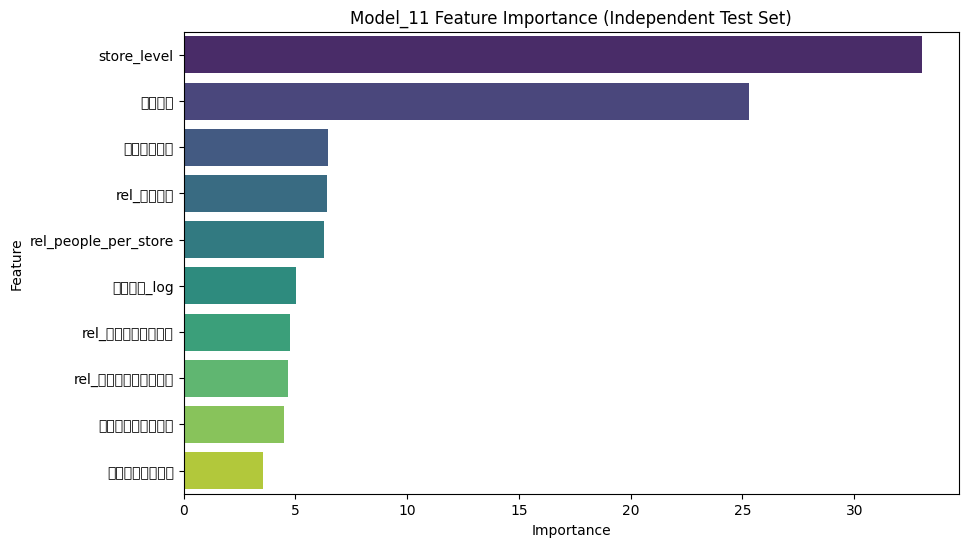

In [ ]:
# 6. 特徵重要性 (Feature Importance)
importance_df = pd.DataFrame({
    'Feature': input_features_11,
    'Importance': model_11.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*20 + " 特徵重要性排行 " + "="*20)
print(importance_df)

# 視覺化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Model_11 Feature Importance (Independent Test Set)')
plt.show()

## 對v1.3資料測試

In [4]:
import json
import os

def clean_notebook_metadata(input_filename, output_filename):
    if not os.path.exists(input_filename):
        print(f"❌ 錯誤：找不到檔案 {input_filename}，請檢查路徑是否正確。")
        return

    with open(input_filename, 'r', encoding='utf-8') as f:
        nb = json.load(f)

    # 移除導致 GitHub 報錯的 widgets metadata
    if 'metadata' in nb and 'widgets' in nb['metadata']:
        print(f"正在移除 {input_filename} 中的 widgets metadata...")
        del nb['metadata']['widgets']

    # 移除 colab 專有 metadata 以減少衝突
    if 'metadata' in nb and 'colab' in nb['metadata']:
        nb['metadata']['colab'] = {"name": "Clean_Notebook.ipynb"}

    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(nb, f, ensure_ascii=False, indent=2)

    print(f"✅ 處理完成！檔案已存至：{os.path.abspath(output_filename)}")
    print("請在左側檔案列重新整理，下載此檔案後再上傳至 GitHub。")

# --- 請在此輸入您的檔案路徑 ---
# 如果檔案在雲端硬碟，路徑通常像：'/content/drive/MyDrive/Colab Notebooks/你的檔案.ipynb'
current_nb_path = '/content/drive/MyDrive/Colab Notebooks/Convenient store analysis-品牌+物理雙模型.ipynb'
clean_notebook_metadata(current_nb_path, 'Clean_GitHub_Version.ipynb')

💡 提示：請確認您的 Notebook 檔案路徑，並執行 clean_notebook_metadata 函式。


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           715 non-null    int64  
 1   公司名稱         715 non-null    object 
 2   分公司名稱        715 non-null    object 
 3   地址           715 non-null    object 
 4   分公司核准設立日期    715 non-null    object 
 5   設立年份         715 non-null    int64  
 6   縣市           715 non-null    object 
 7   行政區          715 non-null    object 
 8   里別           715 non-null    object 
 9   行政區平日夜間停留人數  715 non-null    int64  
 10  行政區平日日間活動人數  715 non-null    int64  
 11  行政區假日夜間停留人數  715 non-null    int64  
 12  行政區假日日間活動人數  715 non-null    int64  
 13  里人均收入中位數     715 non-null    int64  
 14  里人口數         715 non-null    int64  
 15  發票張數指標       715 non-null    float64
 16  發票銷售額指標      715 non-null    float64
 17  店_緯度         715 non-null    float64
 18  店_經度         715 non-null    float64
 19  500m熱鬧據點

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

def test_diagnostic(model, eval_df, f_list, name):
    print(f"\n🏁 {name} - df_test 最終期末考報告")
    print("-" * 60)

    # 準備測試數據與標籤
    X_test = eval_df[f_list].copy()
    y_test = (eval_df['登記現況'] == '營運中').astype(int)

    # 確保類別型欄位正確
    for col in X_test.select_dtypes(['category', 'object']).columns:
        X_test[col] = X_test[col].astype('category')

    dtest = xgb.DMatrix(X_test, enable_categorical=True)

    # 取得預測
    y_prob = model.predict(dtest)
    y_pred = (y_prob > 0.5).astype(int)

    # 1. 輸出基礎指標
    auc = roc_auc_score(y_test, y_prob)
    print(f"Accuracy  : {np.mean(y_pred == y_test):.4f}")
    print(f"AUC Score : {auc:.4f}")

    # 2. 輸出詳細 Classification Report (重點看 Precision 1 與 Recall 0)
    print("\n" + "="*20 + " Classification Report " + "="*20)
    print(classification_report(y_test, y_pred))

    # 3. 輸出特徵重要性 (Gain) - 雖然模型固定，但在不同測試集表現出的解釋力不同
    importance = model.get_score(importance_type='gain')
    imp_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*20 + " Feature Importance (Gain) " + "="*20)
    print(imp_df.head(10).to_markdown(index=False))
    return imp_df

# --- 執行對比 ---
print("🚀 正在評估 Model_V5 (旗艦版)...")
importance_test_v5 = test_diagnostic(model_v5_master, df_test, features_v5, "Model_V5")

print("\n" + "#"*80 + "\n")

print("🛡️ 正在評估 Model_V8 (避雷版)...")
importance_test_v8 = test_diagnostic(model_v8_master, df_test, features_v8, "Model_V8")

🚀 正在評估 Model_V5 (旗艦版)...

🏁 Model_V5 - df_test 最終期末考報告
------------------------------------------------------------
Accuracy  : 0.6112
AUC Score : 0.6692

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.39      0.58      0.46       207
           1       0.78      0.62      0.70       508

    accuracy                           0.61       715
   macro avg       0.59      0.60      0.58       715
weighted avg       0.67      0.61      0.63       715


==================== Feature Importance (Gain) ====================
| Feature                |   Importance |
|:-----------------------|-------------:|
| 是否便利商店           |     16.1314  |
| 歷史品牌優勢           |      7.10923 |
| 店均服務人口數         |      4.74121 |
| 區域競爭飽和度         |      4.46197 |
| 日夜人流差             |      3.97305 |
| 里人均收入中位數       |      3.57355 |
| 發票銷售額指標         |      3.44579 |
| 行政區平日日間活動人數 |      3.38686 |
| 最近熱鬧據點類型       |    

In [ ]:
# --- 修正版：確保標籤與預測機率對齊 ---

# 1. 確保 df_test 裡有預測機率與真實標籤
dtest_v8 = xgb.DMatrix(df_test[features_v8], enable_categorical=True)
df_test['V8_prob'] = model_v8_master.predict(dtest_v8)

# 重新建立標籤欄位 (對應你訓練時的 y 邏輯)
df_test['is_active'] = (df_test['登記現況'] == '營運中').astype(int)

# 2. 成功案例：模型非常有信心 (Prob > 0.9) 且實際上真的是營運中 (is_active == 1)
v8_success = df_test[(df_test['is_active'] == 1) & (df_test['V8_prob'] > 0.9)].sort_values('V8_prob', ascending=False).head(5)

# 3. 失敗案例：模型非常有信心 (Prob > 0.8) 但實際上卻是歇業 (is_active == 0)
# 這些就是我們要抓出的「隱形地雷」
v8_fails = df_test[(df_test['is_active'] == 0) & (df_test['V8_prob'] > 0.8)].sort_values('V8_prob', ascending=False).head(10)

# 選取關鍵欄位展示 (請確保這些欄位在 df_test 中存在)
display_cols = ['V8_prob', '最近鄰店距離', '路口與巷弄權重', '店均電信人流', '發票銷售額指標', '租金log']

print("🏆 Model_V8 認證：最強潛力點位 (Top 5 Success Cases)")
print("-" * 80)
if not v8_success.empty:
    print(v8_success[display_cols].to_markdown())
else:
    print("目前測試集中沒有機率大於 0.9 的成功案例。")

print("\n" + "!" * 80)
print("💀 Model_V8 盲點：隱形地雷點位 (Top 10 Failure Cases)")
print("!" * 80)
if not v8_fails.empty:
    print(v8_fails[display_cols].to_markdown())
else:
    print("太棒了！目前的門檻下沒有發現被誤判的地雷店。")

🏆 Model_V8 認證：最強潛力點位 (Top 5 Success Cases)
--------------------------------------------------------------------------------
|     |   V8_prob |   最近鄰店距離 |   路口與巷弄權重 |   店均電信人流 |   發票銷售額指標 |   租金log |
|----:|----------:|---------------:|-----------------:|---------------:|-----------------:|----------:|
| 273 |  0.937077 |        218.001 |          7.25229 |       10312.7  |             83   |  10.2312  |
| 413 |  0.936364 |        161.819 |          1.52003 |       21961.8  |             99   |  10.4975  |
| 521 |  0.932328 |        245.084 |          1.65296 |        7893.82 |             91   |   9.94544 |
| 330 |  0.920861 |        151.207 |          1.72834 |       16471.4  |             98.5 |  10.4956  |
|  79 |  0.916951 |        130.859 |          1.87245 |        5369.05 |             96   |   9.89071 |

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
💀 Model_V8 盲點：隱形地雷點位 (Top 10 Failure Cases)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
# 抓取 Case 209 的地址資訊
target_case = df_test.loc[[209]]
print(f"📍 Case 209 地址: {target_case['地址'].values[0] if '地址' in target_case.columns else '欄位缺失'}")
print(f"🌐 經緯度: {target_case['店_緯度'].values[0] if '店_緯度' in target_case.columns else 'N/A'}, {target_case['店_經度'].values[0] if '店_經度' in target_case.columns else 'N/A'}")

📍 Case 209 地址: 新北市土城區自強街11巷2號
🌐 經緯度: 24.97032499, 121.4300646


# 全資料集SHAP值

In [ ]:
import shap
import pandas as pd
import numpy as np

# --- 1. 定義分組 SHAP 統計函數 ---
def get_grouped_shap_impact(model, features, df_full, version_name):
    print(f"\n" + "═"*85)
    print(f"🚀 啟動分業態解析：{version_name}")
    print(f"═"*85)

    # 遍歷兩組：0 (超市藥妝), 1 (便利商店)
    for g_val, g_name in [(0, "超市藥妝組"), (1, "便利商店組")]:
        # 篩選資料
        df_group = df_full[df_full['是否便利商店'] == g_val].copy()
        if df_group.empty: continue

        X_group = df_group[features].copy()

        # 🚀 類別型特徵編碼對齊
        for col in X_group.select_dtypes(['category', 'object']).columns:
            X_group[col] = X_group[col].astype('category').cat.codes

        # 2. 計算 SHAP
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_group)

        # 3. 彙整統計
        shap_df = pd.DataFrame(shap_values, columns=features)
        stats = []
        for col in features:
            val = shap_df[col]
            mean_abs = np.abs(val).mean()
            pos_impact = val[val > 0].mean() if len(val[val > 0]) > 0 else 0
            neg_impact = val[val < 0].mean() if len(val[val < 0]) > 0 else 0

            stats.append({
                '特徵名稱': col,
                '影響力 (Mean |SHAP|)': mean_abs,
                '正向推力 (營運↑)': pos_impact,
                '負向拉力 (廢止↓)': neg_impact
            })

        result_df = pd.DataFrame(stats).sort_values('影響力 (Mean |SHAP|)', ascending=False)

        # 4. 輸出該組結果
        print(f"\n📍 【{g_name}】樣本數: {len(df_group)} 筆")
        print("-" * 60)
        print(result_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# --- 2. 執行三代全資料分組對抗 ---
get_grouped_shap_impact(final_model, features_v1, df_full_v5, "版本一 (原始加權版)")
get_grouped_shap_impact(final_model_master, features_v3, df_full_v5, "版本三 (Master 精準版)")
get_grouped_shap_impact(final_model_v5, features_v5, df_full_v5, "版本五 (旗艦差值版)")


═════════════════════════════════════════════════════════════════════════════════════
🚀 啟動分業態解析：版本一 (原始加權版)
═════════════════════════════════════════════════════════════════════════════════════

📍 【超市藥妝組】樣本數: 1273 筆
------------------------------------------------------------
             特徵名稱  影響力 (Mean |SHAP|)  正向推力 (營運↑)  負向拉力 (廢止↓)
           是否便利商店             1.0345      1.0383     -0.3565
             競爭優勢             0.2004      0.0276     -0.2474
               租金             0.1224      0.1308     -0.1115
         里人均收入中位數             0.1004      0.0789     -0.1554
        最近的熱鬧據點距離             0.0747      0.0794     -0.0690
500公尺外部競爭(不同公司店數)             0.0726      0.0705     -0.0732
 people_per_store             0.0702      0.0687     -0.0718
 500公尺內部競爭(同公司店數)             0.0440      0.0268     -0.0605
             里人口數             0.0390      0.0536     -0.0246
           發票張數指標             0.0371      0.0421     -0.0277
          發票銷售額指標             0.0253      0.0216   

# 用LLM生成評語

## 讀取pickle檔

In [ ]:
import pandas as pd
import pickle

# 讀取 pickle 檔案
with open('SHAP_XGB_Full_Database.pkl', 'rb') as f:
    data = pickle.load(f)

# 檢查字典裡面的鍵
print("檔案內的鍵值:", data.keys())

# 根據檔案內容顯示，裡面有一個 'lookup_table'
df_shap = data['lookup_table']

# 如果 lookup_table 本身就是 DataFrame，你可以直接檢查它
print(df_shap.head())

檔案內的鍵值: dict_keys(['lookup_table', 'features', 'id_column', 'CVS', 'Super'])
  是否便利商店      競爭優勢  people_per_store    競爭壓力指標  里人均收入中位數   發票銷售額指標  \
0      1  0.098329         -0.208432 -0.110103  0.038143  0.069998   
1      1  0.204539         -0.010092 -0.032974  0.008507 -0.020507   
2      1  0.003099          0.004399 -0.038812  0.055743  0.018364   
3      1 -0.234969          0.013369 -0.047360 -0.026293  0.025146   
4      1  0.213679          0.016989 -0.017194 -0.081032  0.039522   

   行政區平日日間活動人數     日夜人流差  最近的熱鬧據點類型  最近的熱鬧據點距離    租金_log      里人口數    發票張數指標  \
0    -0.015280  0.024138   0.056746   0.179781  0.143802  0.200771 -0.024352   
1     0.036379 -0.005844  -0.017925   0.092050 -0.036660 -0.009317 -0.097687   
2    -0.027299  0.065997  -0.015218   0.062163  0.011921  0.016236 -0.051489   
3    -0.016290 -0.030579  -0.010605  -0.026041 -0.108418 -0.051204 -0.049254   
4    -0.011625 -0.051911  -0.012170   0.040633 -0.021304  0.005031  0.046634   

     id  行政區   里別 登記現

In [ ]:
import pandas as pd
import pickle
import re
import numpy as np

# 讀取檔案
with open('SHAP_XGB_Full_Database.pkl', 'rb') as f:
    data = pickle.load(f)

# 清理欄位名稱的函式 (BigQuery 規範)
def clean_col(name):
    name = re.sub(r'[^\w]', '_', str(name))
    return re.sub(r'_+', '_', name).strip('_')

# --- 1. 處理 lookup_table ---
df_lookup = data['lookup_table']
df_lookup.columns = [clean_col(c) for c in df_lookup.columns]

# --- 2. 處理 features 清單 ---
df_features = pd.DataFrame(data['features'], columns=['feature_name'])

# 檢查結果
print("準備上傳的資料表：")
print(f"- lookup_table: {df_lookup.shape}")
print(f"- features_list: {df_features.shape}")

準備上傳的資料表：
- lookup_table: (7142, 17)
- features_list: (13, 1)


## bigquery設定與資料上傳

In [ ]:
import os
from google.cloud import bigquery
from google.colab import drive
import pandas as pd

In [ ]:
# @title
# #清空資料集重來
# from google.cloud import bigquery

# # 1. 設定專案與資料集變數
# project_id = 'tibame-gad258-19-bigquery'
# datasets = ['convenient_store']

# client = bigquery.Client(project=project_id)

# print(f"⚠️ 準備開始刪除專案 [{project_id}] 中的資料表...")

# for dataset_id in datasets:
#     print(f"\n正在處理資料集: {dataset_id}")

#     # 取得資料集內的所有資料表清單
#     dataset_ref = client.dataset(dataset_id)
#     try:
#         tables = list(client.list_tables(dataset_ref))

#         if not tables:
#             print(f"-> 資料集 {dataset_id} 本來就是空的，無需處理。")
#             continue

#         for table in tables:
#             table_full_id = f"{project_id}.{dataset_id}.{table.table_id}"
#             # 執行刪除資料表
#             client.delete_table(table_full_id, not_found_ok=True)
#             print(f"-> 已刪除資料表: {table_full_id}")

#     except Exception as e:
#         print(f"❌ 存取資料集 {dataset_id} 時發生錯誤: {e}")

# print("\n✨ 所有指定資料表已清除完成！您可以開始重新上傳資料了。")

⚠️ 準備開始刪除專案 [tibame-gad258-19-bigquery] 中的資料表...

正在處理資料集: convenient_store
-> 已刪除資料表: tibame-gad258-19-bigquery.convenient_store.final_prediction_report_ai_anonymous
-> 已刪除資料表: tibame-gad258-19-bigquery.convenient_store.keyword_table
-> 已刪除資料表: tibame-gad258-19-bigquery.convenient_store.prediction_report
-> 已刪除資料表: tibame-gad258-19-bigquery.convenient_store.shap_features_list
-> 已刪除資料表: tibame-gad258-19-bigquery.convenient_store.shap_lookup_table
-> 已刪除資料表: tibame-gad258-19-bigquery.convenient_store.temp_llm_input_final

✨ 所有指定資料表已清除完成！您可以開始重新上傳資料了。


In [ ]:
#設定資料集變數
project_id='tibame-gad258-19-bigquery'
us_dataset='tibame_gad258_19_dataset_us'
dataset_id='convenient_store'
text_model = 'llm_model'

# # 設置 Google Cloud 認證
# BIGQUERY_KEY = '/content/drive/MyDrive/【課程】Python數據分析/GCP - Bigquery/tibame-gad258-19-bigquery-5c8516b6c626.json'

#SET GCP 金鑰
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEY
client = bigquery.Client()
print('connection done')

connection done


In [ ]:
import pandas_gbq

# 設定要上傳的字典
tables_to_upload = {
    'shap_lookup_table': df_lookup,
    'shap_features_list': df_features,
}

# 批次上傳
for table_name, df in tables_to_upload.items():
    full_table_id = f"{dataset_id}.{table_name}"
    print(f"正在上傳 {full_table_id}...")
    pandas_gbq.to_gbq(df, full_table_id, project_id=project_id, if_exists='replace')

print("全部上傳完成！")

正在上傳 convenient_store.shap_lookup_table...


/usr/local/lib/python3.12/dist-packages/pandas_gbq/schema/pandas_to_bigquery.py:159: UserWarning: Could not determine the type of columns: 是否便利商店
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00, 5029.14it/s]


正在上傳 convenient_store.shap_features_list...


100%|██████████| 1/1 [00:00<00:00, 9258.95it/s]

全部上傳完成！


In [ ]:
import pandas as pd
import re
import pandas_gbq

# 1. 讀取 CSV
df_report = pd.read_csv('全資料集_最終決策報告_修正對齊版.csv')

# 2. 清理欄位名稱 (將空格、括號、特殊符號改為底線)
def clean_col_name(name):
    # 將非英文字母、數字、中文的字元替換為底線
    clean_name = re.sub(r'[^\w]', '_', str(name))
    # 壓縮重複的底線
    clean_name = re.sub(r'_+', '_', clean_name).strip('_')
    return clean_name

df_report.columns = [clean_col_name(c) for c in df_report.columns]

# 檢查清理後的欄位範例
print("清理後的欄位名稱前 5 個：", df_report.columns[:5].tolist())

清理後的欄位名稱前 5 個： ['id', '公司名稱', '縣市', '行政區', '里別']


In [ ]:
# # 3. 設定 BigQuery 資訊
# project_id = '您的專案ID'
dataset_table = 'convenient_store.prediction_report' # 資料集.資料表名

# 4. 執行上傳
pandas_gbq.to_gbq(
    df_report,
    dataset_table,
    project_id=project_id,
    if_exists='replace', # 如果表已存在則覆蓋
    progress_bar=True
)

print(f"成功將 {len(df_report)} 筆決策報告資料上傳至 {dataset_table}")

100%|██████████| 1/1 [00:00<00:00, 792.42it/s]

成功將 7142 筆決策報告資料上傳至 convenient_store.prediction_report


## 生成關鍵字提取表

In [ ]:
# 1. 定義變數
project_id = 'tibame-gad258-19-bigquery'
dataset_id = 'convenient_store'

# 2. 建立 SQL 查詢 (移除所有中文註解與隱形字元)
# 2. 建立 SQL (對齊新上傳的資料表欄位)
query = fr"""
CREATE OR REPLACE TABLE `tibame-gad258-19-bigquery.convenient_store.keyword_table` AS
WITH shap_long AS (
  -- 1. 將 SHAP 數值轉為長表 (根據您最新的 shap_lookup_table 欄位)
  SELECT
    id,
    feature_name,
    shap_value
  FROM `tibame-gad258-19-bigquery.convenient_store.shap_lookup_table`
  UNPIVOT(shap_value FOR feature_name IN (
    `競爭優勢`,
    `people_per_store`,
    `競爭壓力指標`,
    `里人均收入中位數`,
    `發票銷售額指標`,
    `行政區平日日間活動人數`,
    `日夜人流差`,
    `最近的熱鬧據點類型`,
    `最近的熱鬧據點距離`,
    `租金_log`,
    `里人口數`,
    `發票張數指標`
  ))
),
ranked_shap AS (
  -- 2. 語義化轉換：將新欄位名稱改為 AI 顧問容易理解的詞彙
  SELECT
    id,
    CASE
      WHEN feature_name = '里人均收入中位數' THEN '區域人均收入'
      WHEN feature_name = '里人口數' THEN '區域人口基礎規模'
      WHEN feature_name = '發票張數指標' THEN '消費頻次指標'
      WHEN feature_name = '發票銷售額指標' THEN '消費金額指標'
      WHEN feature_name = '最近的熱鬧據點距離' THEN '與人流核心據點距離'
      WHEN feature_name = '租金_log' THEN '租金壓力'
      WHEN feature_name = 'people_per_store' THEN '平均單店服務人口'
      WHEN feature_name = '競爭優勢' THEN '區域品牌市占率'
      WHEN feature_name = '競爭壓力指標' THEN '區域競爭飽和度'
      WHEN feature_name = '行政區平日日間活動人數' THEN '行政區日間活動人流'
      WHEN feature_name = '日夜人流差' THEN '行政區日夜人流差異'
      WHEN feature_name = '最近的熱鬧據點類型' THEN '周邊主要據點類型'
      ELSE feature_name
    END AS ai_friendly_name,
    shap_value,
    ROW_NUMBER() OVER(PARTITION BY id ORDER BY ABS(shap_value) DESC) as rank
  FROM shap_long
),
top_features AS (
  -- 3. 取出前兩大影響因素
  SELECT
    id,
    MAX(IF(rank = 1, ai_friendly_name, NULL)) as top1_feature,
    MAX(IF(rank = 1, IF(shap_value > 0, '表現優異', '表現較弱'), NULL)) as top1_dir,
    MAX(IF(rank = 2, ai_friendly_name, NULL)) as top2_feature,
    MAX(IF(rank = 2, IF(shap_value > 0, '表現優異', '表現較弱'), NULL)) as top2_dir
  FROM ranked_shap
  WHERE rank <= 2
  GROUP BY id
)
-- 4. 與最新 prediction_report JOIN (確保 id 轉型一致)
SELECT
  rep.*,
  top.top1_feature,
  top.top1_dir,
  top.top2_feature,
  top.top2_dir
FROM `tibame-gad258-19-bigquery.convenient_store.prediction_report` AS rep
INNER JOIN top_features AS top ON CAST(rep.id AS INT64) = CAST(top.id AS INT64)
"""

# 3. 執行前的最後清理 (移除隱形空格)
query = query.replace('\xa0', ' ')

print("正在執行 SQL 建立關鍵字表...")

# 4. 執行查詢
try:
    query_job = client.query(query)
    query_job.result()
    print("🎉 關鍵字表已成功建立！")

    # 預覽結果
    check_df = client.query(f"SELECT id, top1_feature, top1_dir FROM `{project_id}.{dataset_id}.keyword_table` LIMIT 5").to_dataframe()
    print(check_df)
except Exception as e:
    print(f"執行失敗，錯誤訊息：{e}")

正在執行 SQL 建立關鍵字表...
🎉 關鍵字表已成功建立！
     id top1_feature top1_dir
0  1576      區域品牌市占率     表現較弱
1  1502      區域品牌市占率     表現較弱
2  1501      區域品牌市占率     表現優異
3  1673      區域品牌市占率     表現較弱
4  1498      區域品牌市占率     表現優異


## 生成評語

In [ ]:
# @title
import pandas as pd
from google.cloud import bigquery

# 1. 設定變數 (請確認您在 US 區域的 Dataset 名稱)
project_id = 'tibame-gad258-19-bigquery'
dataset_id = 'convenient_store'
text_model = 'llm_model'

client = bigquery.Client(project=project_id)

# 2. 從 BigQuery 取回關鍵字表資料 (先取 10 筆測試)
print("正在從 BigQuery 讀取關鍵字資料...")
fetch_query = f"SELECT * FROM `{project_id}.{dataset_id}.keyword_table` LIMIT 10"
df = client.query(fetch_query).to_dataframe()

# 3. 在 Python 中組合 Prompt (已加入推薦展店指數)
def build_prompt(row):
    # 計算推薦展店指數 (機率 * 100)
    recommend_score = row['預測生存機率'] * 100

    return (
        f"你是一位零售商圈顧問。根據以下數據，提供 60 字內專業中文評語。\n"
        # f"品牌：{row['公司名稱']}\n"
        f"位置：{row['行政區']}{row['里別']}\n"
        f"推薦展店指數：{recommend_score:.1f}\n"  # <--- 這裡已更新為您要求的格式
        f"決策：{row['專題最終決策']}\n"
        f"關鍵1：{row['top1_feature']}({row['top1_dir']})\n"
        f"關鍵2：{row['top2_feature']}({row['top2_dir']})\n"
        f"請以「該地區...」開頭進行專業分析。"
    )

df['llm_prompt'] = df.apply(build_prompt, axis=1)

# 4. 上傳 Prompt 到臨時表 (欄位名稱用純英文以避開編碼報錯)
df_input = df[['id', 'llm_prompt']]
temp_table_id = f"{project_id}.{dataset_id}.temp_llm_input"

# 使用 WRITE_TRUNCATE 覆蓋舊的臨時表
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
client.load_table_from_dataframe(df_input, temp_table_id, job_config=job_config).result()
print(f"已建立 Prompt 臨時表: {temp_table_id}")

# 5. 執行全英文 SQL 呼叫 LLM (已將 LIMIT 移至子查詢內部)
llm_query = f"""
SELECT
  id,
  ml_generate_text_llm_result AS ai_review
FROM ML.GENERATE_TEXT(
  MODEL `{project_id}.{us_dataset}.{text_model}`,
  (
    SELECT id, llm_prompt AS prompt
    FROM `{temp_table_id}`
  ),
  STRUCT(
    0.7 AS temperature,
    512 AS max_output_tokens,
    TRUE AS flatten_json_output
  )
);
"""

print("正在呼叫 US 區域之 LLM 生成評語...")
try:
    df_ai_results = client.query(llm_query).to_dataframe()

    # 6. 合併結果並顯示
    final_result = df.merge(df_ai_results, on='id')

    # 重新命名列名，讓顯示更美觀
    final_result['推薦展店指數'] = (final_result['預測生存機率'] * 100).round(1)

    pd.set_option('display.max_colwidth', None)
    print("🎉 生成成功！結果預覽如下：")
    display(final_result[['id', '公司名稱', '推薦展店指數', '專題最終決策', 'ai_review']])

except Exception as e:
    print(f"執行失敗，請檢查以下訊息：\n{e}")

正在從 BigQuery 讀取關鍵字資料...
已建立 Prompt 臨時表: tibame-gad258-19-bigquery.convenient_store.temp_llm_input
正在呼叫 US 區域之 LLM 生成評語...
🎉 生成成功！結果預覽如下：


,id,公司名稱,推薦展店指數,專題最終決策,ai_review
0,61,來來超商股份有限公司,65.2,優質位點 (推薦展店),該地區人均店鋪數低，且500公尺內異業競爭壓力小，展店優勢明顯。推薦展店指數顯示此為優質位點，具備良好發展潛力，可積極評估進駐。\n
1,3805,來來超商股份有限公司,68.5,優質位點 (推薦展店),該地區外部競爭壓力小，且平均每店服務人口充足，具備顯著優勢。推薦展店，展店指數顯示該位點具備良好發展潛力，可積極評估進駐。\n
2,3803,統一超商股份有限公司,51.9,優質位點 (推薦展店),該地區租金具優勢，且500公尺內外部競爭壓力較小，展店指數雖僅51.9，但考量到租金與競爭優勢，仍屬優質位點，建議可積極評估展店機會。\n
3,47,統一超商股份有限公司,60.0,優質位點 (推薦展店),該地區人均店鋪比佳，且500公尺內異業競爭壓力小，展店條件優越。推薦指數達60，顯示具備良好開店潛力，適合積極評估進駐。\n
4,33,統一超商股份有限公司,64.3,優質位點 (推薦展店),該地區租金與競爭優勢明顯，具備展店優勢。推薦展店指數雖非頂尖，但訊塘里商圈仍屬優質位點，建議進一步評估人流與消費潛力，可望取得良好投資回報。\n
5,18,統一超商股份有限公司,51.1,優質位點 (推薦展店),該地區人均店鋪比例具優勢，顯示消費潛力。雖鄰近熱鬧據點距離稍遠，但整體推薦展店指數高，仍屬優質位點。建議針對在地客群，強化商品獨特性與集客力。\n
6,2694,全家便利商店股份有限公司,50.7,優質位點 (推薦展店),該地區明志里具備展店優勢，人均收入中位數高，且外部競爭壓力較小。推薦指數雖僅50.7，但考量優勢關鍵因素，仍建議可積極評估展店機會，把握市場潛力。\n
7,2673,全聯實業股份有限公司,74.8,優質位點 (推薦展店),該地區人均店鋪比例佳，且里人口數充足，具備良好消費潛力。推薦展店，可望快速獲利。\n
8,2677,全家便利商店股份有限公司,57.9,優質位點 (推薦展店),該地區每店服務人口具優勢，且500公尺內異業競爭壓力小，展店指數雖不高，但仍屬優質位點。建議深入評估目標客群消費力，審慎樂觀看待泰山區義仁里開店效益。\n
9,4270,全家便利商店股份有限公司,56.7,優質位點 (推薦展店),該地區具備競爭優勢，500公尺內不同公司店數顯示外部競爭壓力小，推薦展店指數亦支持此決策。是個值得投資的優質位點，能快速建立市場地位。\n


In [ ]:
import pandas as pd
from google.cloud import bigquery

# 1. 設定變數 (根據您的指定)
project_id = 'tibame-gad258-19-bigquery'
us_dataset = 'tibame_gad258_19_dataset_us'  # 模型所在位置
dataset_id = 'convenient_store'              # 資料表所在位置
text_model = 'llm_model'

client = bigquery.Client(project=project_id)

# 2. 從資料表位置讀取全量關鍵字資料
print("Step 1: 正在從資料庫讀取資料...")
fetch_query = f"SELECT * FROM `{project_id}.{dataset_id}.keyword_table`"
df_full = client.query(fetch_query).to_dataframe()
print(f"-> 成功讀取 {len(df_full)} 筆資料。")

# 3. 在 Python 中組合 Prompt (徹底排除品牌與現況資訊)
def build_prompt(row):
    return (
        f"你是一位資深零售顧問。請根據以下「匿名位點」數據提供 60 字內中文評語。\n"
        f"【嚴格禁令】：評語中絕對禁止出現「品牌名稱」以及「登記現況」(如：營運中、廢止、撤點等狀態)。\n"
        f"位置：{row['行政區']}{row['里別']}\n"
        f"推薦展店指數：{row['營運推薦分數']}\n"
        f"最終決策建議：{row['專題最終決策']}\n"
        f"環境指標1：{row['top1_feature']} ({row['top1_dir']})\n"
        f"環境指標2：{row['top2_feature']} ({row['top2_dir']})\n"
        f"請以「該位點...」開頭，僅針對商圈體質、競爭飽和度與地理數據進行客觀分析。"
    )

print("Step 2: 正在構建高度匿名化之提示詞 (Prompts)...")
df_full['llm_prompt'] = df_full.apply(build_prompt, axis=1)

# 4. 上傳 Prompt 到臨時表 (存放在資料表區域)
df_input = df_full[['id', 'llm_prompt']]
temp_table_id = f"{project_id}.{dataset_id}.temp_llm_input_final"
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
client.load_table_from_dataframe(df_input, temp_table_id, job_config=job_config).result()
print(f"-> 已建立臨時表: {temp_table_id}")

# 5. 呼叫 LLM (模型路徑指向 us_dataset)
# SQL 指令中完全沒有中文字，避免解析器報錯
llm_query = f"""
SELECT
  id,
  ml_generate_text_llm_result AS ai_review
FROM ML.GENERATE_TEXT(
  MODEL `{project_id}.{us_dataset}.{text_model}`,
  (SELECT id, llm_prompt AS prompt FROM `{temp_table_id}`),
  STRUCT(
    0.7 AS temperature,
    1024 AS max_output_tokens,
    TRUE AS flatten_json_output
  )
);
"""


Step 1: 正在從資料庫讀取資料...
-> 成功讀取 7142 筆資料。
Step 2: 正在構建高度匿名化之提示詞 (Prompts)...
-> 已建立臨時表: tibame-gad258-19-bigquery.convenient_store.temp_llm_input_final


In [ ]:
# 這段叫GCP生成AI評語，沒事不要亂執行
# client = bigquery.Client(project=project_id)

# # 2. 這是「全自動存檔 SQL」
# # 直接在雲端把生成結果與原表合併，並存成 final_report_full_ai_final
# final_sql = f"""
# CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.final_report_full_ai_final` AS
# WITH ai_gen AS (
#   SELECT
#     id,
#     ml_generate_text_llm_result AS ai_review
#   FROM ML.GENERATE_TEXT(
#     MODEL `{project_id}.{us_dataset}.{text_model}`,
#     (SELECT id, llm_prompt AS prompt FROM `{project_id}.{dataset_id}.temp_llm_input_final`),
#     STRUCT(0.7 AS temperature, 1024 AS max_output_tokens, TRUE AS flatten_json_output)
#   )
# )
# SELECT
#   rep.*,
#   ai.ai_review
# FROM `{project_id}.{dataset_id}.keyword_table` AS rep
# LEFT JOIN ai_gen AS ai ON CAST(rep.id AS INT64) = CAST(ai.id AS INT64);
# """

# print("🚀 啟動雲端全自動生成與存檔任務...")
# print("這段程式在 BigQuery 背景執行，請稍候...")

# try:
#     # 執行 SQL 任務
#     query_job = client.query(final_sql)
#     query_job.result()  # 等待雲端跑完
#     print(f"✅ 大功告成！全量評語已存入 BigQuery 表：{project_id}.{dataset_id}.final_report_full_ai_final")

#     # 最後把結果下載成 CSV
#     print("正在下載最終結果以供存檔...")
#     df_final = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.final_report_full_ai_final`").to_dataframe()
#     df_final.to_csv("final_expert_report.csv", index=False, encoding='utf-8-sig')
#     print("✅ 最終 CSV 檔案已產出：final_expert_report.csv")

#     # 預覽
#     display(df_final[['id', '行政區', '里別', '營運推薦分數', 'ai_review']].head())

# except Exception as e:
#     print(f"❌ 執行中斷，錯誤原因：{e}")

🚀 啟動雲端全自動生成與存檔任務...
這段程式在 BigQuery 背景執行，請稍候...
✅ 大功告成！全量評語已存入 BigQuery 表：tibame-gad258-19-bigquery.convenient_store.final_report_full_ai_final
正在下載最終結果以供存檔...
✅ 最終 CSV 檔案已產出：final_expert_report.csv


,id,行政區,里別,營運推薦分數,ai_review
0,1502,永和區,福和里,81.708580,該位點具備優異人流條件，惟區域品牌競爭力相對薄弱。建議審慎評估自身品牌優勢，並針對目標客群擬...
1,1673,永和區,福和里,22.491827,該位點位於永和區福和里，商圈體質與競爭飽和度皆表現不佳。數據顯示區域品牌市占率偏低，且市場競...
2,1576,永和區,福和里,20.386063,該位點商圈體質偏弱，區域競爭飽和度高，品牌市占率與人流核心距離皆為不利因素。地理數據顯示該處...
3,1498,永和區,福和里,55.589700,該位點位於永和區福和里，商圈體質良好，區域品牌市占率高，顯示消費者接受度佳。鄰近人流核心據點...
4,1501,永和區,福和里,52.130188,該位點位於永和區福和里，商圈體質良好，具備高區域品牌市占率與行政區日間活動人流優勢。展店指數...
